## KGB Model LN Auto V2 - Non Asset Ownership

In [2]:
!pip install xgboost

  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
Train = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Train_Funded_Data_250324.csv')
Test = pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Test_Funded_Data_250324.csv')
Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_Oot_Funded_Data_250324.csv')
TTD= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/2_LN_Auto_V2_TTD_Data_250324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 347), (62938, 347), (37121, 345), (700580, 345))

In [6]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

130

In [7]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols
len(all_cols)

144

In [8]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum()})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum()})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum()})

{'Length': 146855.0, 'Bads': 2227.0}
{'Length': 62938.0, 'Bads': 959.0}
{'Length': 37121.0, 'Bads': 545.0}


In [9]:
Train.shape, Test.shape, Oot.shape

((146855, 347), (62938, 347), (37121, 345))

In [10]:
print(TTD.shape)
TTD= TTD[TTD['client']!= 'CPM'].reset_index(drop= True)
print(TTD.shape)
# TTD_Oot= TTD_Oot[TTD_Oot['client']!= 'CPM'].reset_index(drop= True)

(700580, 345)
(685215, 345)


In [11]:
Train= Train[all_cols + ['weight']]
Test= Test[all_cols + ['weight']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((146855, 145), (62938, 145), (37121, 144), (685215, 144))

In [12]:
Train.rename(columns= {'weight': 'wt2'}, inplace= True)
Test.rename(columns= {'weight': 'wt2'}, inplace= True)

In [13]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.015164618160770828, 0.015237217579204931, 0.01468171654858436)

In [14]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(200148.0, 146855, 62938)

In [15]:
all_funded= pd.concat([Train, Test]).reset_index(drop= True)
all_funded.shape

(209793, 145)

In [16]:
all_funded['client'].value_counts(dropna= False)

client
Tower       42966
Arkansas    39869
GESA        28069
Guardian    27406
Numerica    25791
SECU        18365
Bethpage    11837
CPM          9645
HFCU         2895
Hawaii       2077
NCU           873
Name: count, dtype: int64

In [17]:
all_funded['bad_flag'].mean()

0.015186398020906322

In [18]:
def get_segment(d):
    if (d['derogcount']> 0):
        return 'Derog'
    elif ((d['derogcount']== 0) and (d['assetprop']> 0)):
        return 'Property Owner'
    elif ((d['derogcount']== 0) and (d['assetprop']== 0)):
        return 'Non Property Owner'
    else:
        return 'Missing'

In [19]:
%%time
all_funded['segment']= all_funded.apply(lambda x: get_segment(x), axis= 1)
all_funded['segment'].value_counts(dropna= False)

CPU times: user 3.07 s, sys: 1.1 ms, total: 3.07 s
Wall time: 3.35 s


segment
Property Owner        117191
Non Property Owner     69928
Derog                  22674
Name: count, dtype: int64

In [20]:
all_funded.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [21]:
%%time
TTD['segment']= TTD.apply(lambda x: get_segment(x), axis= 1)
TTD['segment'].value_counts(dropna= False)

CPU times: user 9.74 s, sys: 1.52 s, total: 11.3 s
Wall time: 11.5 s


segment
Property Owner        303020
Non Property Owner    275182
Derog                 107013
Name: count, dtype: int64

In [22]:
TTD.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  52.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [23]:
%%time
Oot['segment']= Oot.apply(lambda x: get_segment(x), axis= 1)
Oot['segment'].value_counts(dropna= False)

CPU times: user 522 ms, sys: 430 µs, total: 522 ms
Wall time: 521 ms


segment
Property Owner        20750
Non Property Owner    12460
Derog                  3911
Name: count, dtype: int64

In [24]:
Oot.groupby('segment')[['derogcount', 'assetprop']].agg(['min', 'max'])

derogcount       assetprop     
                          min   max       min  max
segment                                           
Derog                     1.0  51.0       0.0  1.0
Non Property Owner        0.0   0.0       0.0  0.0
Property Owner            0.0   0.0       1.0  1.0

In [25]:
all_funded= all_funded[all_funded['segment']== 'Non Property Owner'].reset_index(drop= True)
TTD= TTD[TTD['segment']== 'Non Property Owner'].reset_index(drop= True)
Oot= Oot[Oot['segment']== 'Non Property Owner'].reset_index(drop= True)
print(all_funded.shape, all_funded['bad_flag'].mean()*100, all_funded['segment'].unique())
print(TTD.shape, TTD['segment'].unique())
print(Oot.shape, Oot['segment'].unique())
all_funded['client'].value_counts(dropna= False)

(69928, 146) 2.6613087747397324 ['Non Property Owner']
(275182, 145) ['Non Property Owner']
(12460, 145) ['Non Property Owner']


client
Tower       12947
GESA        12018
Guardian    10593
Arkansas     9467
Numerica     8374
SECU         6898
Bethpage     4327
CPM          2800
Hawaii       1198
HFCU          969
NCU           337
Name: count, dtype: int64

In [26]:
TTD['funded_flag'].sum(), len(Train), len(Test)

(67128.0, 146855, 62938)

In [27]:
all_funded['bad_flag'].mean()

0.02661308774739732

In [28]:
req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 130)

In [29]:
### Checking for the singular value variable 
var_singular= []
for v in req_cols:
    if all_funded[v].nunique()== 1:
        print(v, all_funded[v].unique())
        var_singular.append(v)
    else:
        continue
        
var_singular, len(var_singular)

assetpropcurrenttaxtotal [-1.]
assetpropcurrentcount [0.]
derogtimenewest [-1.]
derogcount [0.]
criminalnonfelonytimenewest [-1.]
lienjudgmentdollartotal [0.]
evictiontimenewest [-1.]
bankruptcycount [0.]
criminalnonfelonycount [0.]
addrcurrentcorrectional [0.]
addronfilecorrectional [0.]
addrpreviouscorrectional [0.]
assetprop [0.]
assetpropnewestmortgagetype [-1.]
bankruptcychapter [0.]
bankruptcycount24month [0.]
bankruptcydismissed24month [0.]
bankruptcystatus [0.]
bankruptcytimenewest [-1.]
criminalfelonycount [0.]
criminalfelonycount12month [0.]
criminalfelonytimenewest [-1.]
criminalnonfelonycount12month [0.]
derogcount12month [0.]
evictioncount [0.]
evictioncount12month [0.]
lienjudgmentcount [0.]
lienjudgmentcount12month [0.]
lienjudgmentcourtcount [0.]
lienjudgmentforeclosurecount [0.]
lienjudgmentothercount [0.]
lienjudgmentsmallclaimscount [0.]
lienjudgmenttaxcount [0.]
lienjudgmenttimenewest [-1.]


(['assetpropcurrenttaxtotal',
  'assetpropcurrentcount',
  'derogtimenewest',
  'derogcount',
  'criminalnonfelonytimenewest',
  'lienjudgmentdollartotal',
  'evictiontimenewest',
  'bankruptcycount',
  'criminalnonfelonycount',
  'addrcurrentcorrectional',
  'addronfilecorrectional',
  'addrpreviouscorrectional',
  'assetprop',
  'assetpropnewestmortgagetype',
  'bankruptcychapter',
  'bankruptcycount24month',
  'bankruptcydismissed24month',
  'bankruptcystatus',
  'bankruptcytimenewest',
  'criminalfelonycount',
  'criminalfelonycount12month',
  'criminalfelonytimenewest',
  'criminalnonfelonycount12month',
  'derogcount12month',
  'evictioncount',
  'evictioncount12month',
  'lienjudgmentcount',
  'lienjudgmentcount12month',
  'lienjudgmentcourtcount',
  'lienjudgmentforeclosurecount',
  'lienjudgmentothercount',
  'lienjudgmentsmallclaimscount',
  'lienjudgmenttaxcount',
  'lienjudgmenttimenewest'],
 34)

In [30]:
req_cols= [col for col in req_cols_orig if col not in var_singular]
print(req_cols)
print(len(req_cols))

['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectreco

In [31]:
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/Mono_Data
# !mkdir /root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/Data

In [32]:
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/'

In [33]:
del Train, Test

In [36]:
## Splitting the data into train and test
from sklearn.model_selection import train_test_split
Train, Test= train_test_split(all_funded, test_size= 0.3, random_state= 101)
print(Train.shape, Test.shape)
print(Train['bad_flag'].mean(), Test['bad_flag'].mean())
print(sum(Train['bad_flag']*Train['wt2'])/Train['wt2'].sum(), sum(Test['bad_flag']*Test['wt2'])/Test['wt2'].sum())

(48949, 146) (20979, 146)
0.026537825083249915 0.026788693455360123
0.03231257360835458 0.03284760089554465


In [37]:
pref= 'Non_Property_Owner'
Train.to_csv(f'{path_data}{pref}_Auto_train_raw_data_290324.csv', index= False)
Test.to_csv(f'{path_data}{pref}_Auto_test_raw_data_290324.csv', index= False)
Oot.to_csv(f'{path_data}{pref}_Auto_oot_raw_data_290324.csv', index= False)
TTD.to_csv(f'{path_data}{pref}_Auto_ttd_raw_data_290324.csv', index= False)

In [38]:
all_funded['fico_pb'].isnull().sum()

209

In [39]:
all_funded.groupby(['client']).agg(
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    bad_rate= ('bad_flag', 'mean')
)

,funded,bad,bad_rate
client,,,
Arkansas,9467.0,122.0,0.012887
Bethpage,4327.0,45.0,0.010400
CPM,2800.0,80.0,0.028571
GESA,12018.0,358.0,0.029789
Guardian,10593.0,250.0,0.023600
HFCU,969.0,26.0,0.026832
Hawaii,1198.0,3.0,0.002504
NCU,337.0,8.0,0.023739
Numerica,8374.0,203.0,0.024242


In [40]:
del all_funded

In [41]:
Train['bad_flag'].mean(), Test['bad_flag'].mean(), Oot['bad_flag'].mean()

(0.026537825083249915, 0.026788693455360123, 0.025521669341894062)

In [42]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [43]:
for var in var_to_cat:
    Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
    Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
    Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
    TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [44]:
print(Train['bankruptcystatus'].value_counts(dropna= False))
print(Test['bankruptcystatus'].value_counts(dropna= False))
print(Oot['bankruptcystatus'].value_counts(dropna= False))
print(TTD['bankruptcystatus'].value_counts(dropna= False))

bankruptcystatus
[0]    48949
Name: count, dtype: int64
bankruptcystatus
[0]    20979
Name: count, dtype: int64
bankruptcystatus
[0]    12460
Name: count, dtype: int64
bankruptcystatus
[0]    275182
Name: count, dtype: int64


#### Monotonic Binning

In [45]:
import pickle

configFile= Train[req_cols].dtypes.reset_index()
configFile.columns= ['Feature_Name', 'dtypes']
configFile['Special_values']= '[[-1]]'
# configFile['Monotonicity']= 'Y'
configFile['Monotonicity']= np.where(~configFile['Feature_Name'].isin(var_to_cat), 'Y', 'N')
del configFile['dtypes']
configFile.head()

,Feature_Name,Special_values,Monotonicity
0,assetpropevercount,[[-1]],Y
1,sourcenonderogcount06month,[[-1]],Y
2,addronfilecount,[[-1]],Y
3,addrinputcountyratio,[[-1]],Y
4,assetpropnewestsaleprice,[[-1]],Y


In [46]:
with open(f'{path_mono}configFile.pickle', 'wb') as f:
    pickle.dump(configFile, f)

In [47]:
dep_var = "bad_flag"
weight_column = 'wt2'
min_bin_size = 0.1
index_col=[]

In [48]:
# Get feature meta
# special_values = pd.read_csv(config_file)
import ast
special_values= configFile.copy()
# Converting the string entered in CSV to list of lists
special_values['Special_values'] = special_values['Special_values'].apply(lambda x: ast.literal_eval(str(x)))
# Generate feature meta
feature_meta = GenMeta(Train, index_col, sample_size=50000)
feature_meta = pd.merge(feature_meta, special_values, on="Feature_Name", how="left").replace(np.nan, '')
feature_meta.index = feature_meta['Feature_Name']
feature_meta.head()

,Feature_Name,Datatype,Special_values,Monotonicity
Feature_Name,,,,
unique_id,unique_id,string,,
client,client,string,,
app_date,app_date,string,,
approve_flag,approve_flag,float,,
funded_flag,funded_flag,float,,


In [49]:
with open(f'{path_mono}feature_meta.pickle', 'wb') as f:
    pickle.dump(feature_meta, f)

In [50]:
# Get numeric and embedding dataframe
embed_df, numeric_df = embedding_numeric_df(feature_meta, dep_var, index_col)

# Removing weight_column and columns that are not mentioned in the config file
embed_df.loc[np.invert(embed_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'
numeric_df.loc[
        np.invert(numeric_df['Feature_Name'].isin(special_values['Feature_Name'].tolist())), 'Use_Feature'] = 'N'

if weight_column is not None:
    numeric_df.loc[numeric_df['Feature_Name'] == weight_column, 'Use_Feature'] = 'N'
    
display(numeric_df.head())
display(embed_df.head())

,Feature_Name,Use_Feature,Bucket_Size
Feature_Name,,,
approve_flag,approve_flag,N,10
funded_flag,funded_flag,N,10
fico_pb,fico_pb,N,10
fico_cb,fico_cb,N,10
bad_flag,bad_flag,N,10


,Feature_Name,Use_Feature,Num_Hash_Buckets,Num_Embedding_Columns
Feature_Name,,,,
unique_id,unique_id,N,10,2
client,client,N,10,2
app_date,app_date,N,10,2
product,product,N,10,2
Race,Race,N,10,2


In [51]:
with open(f'{path_mono}embed_df.pickle', 'wb') as f:
    pickle.dump(embed_df, f)

with open(f'{path_mono}numeric_df.pickle', 'wb') as f:
    pickle.dump(numeric_df, f)

In [52]:
# Get feature boundaries
feature_boundaries, numeric_df = get_boundaries_cart(filename=Train, sample_size=5000, shuffle_ind=False,
                                                         batch_size=100000,
                                                         shuffle_size=50000, feature_meta=feature_meta,
                                                         numeric_df=numeric_df,
                                                         dep_var=dep_var,
                                                         weight_column=weight_column, min_bin_size=float(min_bin_size))

assetpropevercount
0.0
assetpropevercount : [-inf, 0.12043146948865145, inf]
sourcenonderogcount06month
0.0
sourcenonderogcount06month : [-inf, 2.0, inf]
addronfilecount
0.0
addronfilecount : [-inf, 4.0, 6.0, inf]
addrinputcountyratio
0.0
addrinputcountyratio : [-inf, 0.639999986, 1.00999999, 1.38, inf]
assetpropnewestsaleprice
1.0
assetpropnewestsaleprice : [-inf, 96943.0, 189900.0, 335000.0, inf]
addrcurrenttaxvalue
0.0
addrcurrenttaxvalue : [-inf, 900.1104823387608, inf]
addrinputavmvalue
2367.0
addrinputavmvalue : [-inf, 110279.0, 147863.0, 346718.0, inf]
addrinputavmvalue60month
3752.0
addrinputavmvalue60month : [-inf, 62172.0, 97071.0, 124722.0, 181869.0, 225000.0, 375000.0, inf]
addrinputlastsaleprice
9000.0
addrinputlastsaleprice : [-inf, 150000.0, inf]
addrinputtaxmarketvalue
0.0
addrinputtaxmarketvalue : [-inf, 629.4547386054874, inf]
sourcecredheadertimeoldest
1.0
sourcecredheadertimeoldest : [-inf, 27.0, 58.0, 86.0, 251.0, 381.0, inf]
addrinputphonecount
0.0
addrinputphonec

In [53]:
with open(f'{path_mono}feature_boundaries.pickle', 'wb') as f:
    pickle.dump(feature_boundaries, f)

In [54]:
# Get train bivar tables + get binned train dataframe
bivar_tables, rep_values, binned_df = get_bivar_tables(filename=Train, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrenttimelastsale
addrinputtimeoldest
addrlastmovetax

In [55]:
# Get train bivar tables + get binned train dataframe
bivar_tables_holdout, rep_values_holdout, binned_df_holdout = get_bivar_tables(filename=Test, predicted=None,
                                                           feature_meta=feature_meta,
                                                           feature_boundaries=feature_boundaries,
                                                           num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                                           dep_var=dep_var, weight_column=None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrenttimelastsale
addrinputtimeoldest
addrlastmovetax

In [56]:
# Get train bivar tables + get binned train dataframe
binned_df_oot = get_bivar_tables_test(filename=Oot, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrenttimelastsale
addrinputtimeoldest
addrlastmovetax

In [57]:
# Get train bivar tables + get binned train dataframe
binned_df_ttd = get_bivar_tables_test(filename=TTD, predicted=None,
                                   feature_meta=feature_meta,
                                   feature_boundaries=feature_boundaries,
                                   num_features=numeric_df.loc[numeric_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   embed_features=embed_df.loc[embed_df['Use_Feature'] == 'Y', 'Feature_Name'].tolist(),
                                   dep_var=None, weight_column= None)

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrenttimelastsale
addrinputtimeoldest
addrlastmovetax

In [58]:
print(binned_df.shape, Train.shape)
print(binned_df_holdout.shape, Test.shape)
print(binned_df_oot.shape, Oot.shape)
print(binned_df_ttd.shape, TTD.shape)

(48949, 146) (48949, 146)
(20979, 146) (20979, 146)
(12460, 145) (12460, 145)
(275182, 145) (275182, 145)


In [59]:
binned_df.to_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_290324.csv', index= False)
binned_df_holdout.to_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_290324.csv', index= False)
binned_df_oot.to_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_290324.csv', index= False)
binned_df_ttd.to_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_290324.csv', index= False)

In [60]:
del Train, Test, Oot, TTD, binned_df, binned_df_holdout, binned_df_oot, binned_df_ttd

#### Reading Data For Model Building

In [61]:
import gc
gc.collect()

0

In [66]:
pref= 'Non_Property_Owner'
path_mono= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/Mono_Data/'
path_data= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/Data/'
path_model= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/'

In [67]:
Train = pd.read_csv(f'{path_mono}{pref}_1_Auto_Train_Binned_Data_290324.csv')
Test = pd.read_csv(f'{path_mono}{pref}_1_Auto_Test_Binned_Data_290324.csv')
Oot= pd.read_csv(f'{path_mono}{pref}_1_Auto_Oot_Binned_Data_290324.csv')
TTD= pd.read_csv(f'{path_mono}{pref}_1_Auto_Ttd_Binned_Data_290324.csv')
# TTD_Oot= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/1_LN_Auto_V2_OOT_Data_220324.csv')

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((48949, 146), (20979, 146), (12460, 145), (275182, 145))

In [68]:
req_cols_orig= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'assetpropcurrenttaxtotal', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'assetpropcurrentcount', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'derogtimenewest', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'derogcount', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'criminalnonfelonytimenewest', 'lienjudgmentdollartotal', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'evictiontimenewest', 'bankruptcycount', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'criminalnonfelonycount', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentcorrectional', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilecorrectional', 'addronfilehighrisk', 'addrpreviouscorrectional', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetprop', 'assetpropnewestmortgagetype', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'bankruptcychapter', 'bankruptcycount24month', 'bankruptcydismissed24month', 'bankruptcystatus', 'bankruptcytimenewest', 'businessassociation', 'criminalfelonycount', 'criminalfelonycount12month', 'criminalfelonytimenewest', 'criminalnonfelonycount12month', 'derogcount12month', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'evictioncount', 'evictioncount12month', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'lienjudgmentcount', 'lienjudgmentcount12month', 'lienjudgmentcourtcount', 'lienjudgmentforeclosurecount', 'lienjudgmentothercount', 'lienjudgmentsmallclaimscount', 'lienjudgmenttaxcount', 'lienjudgmenttimenewest', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols_orig)

130

In [71]:
# print(req_cols)

In [72]:
req_cols= ['assetpropevercount', 'sourcenonderogcount06month', 'addronfilecount', 'addrinputcountyratio', 'assetpropnewestsaleprice', 'addrcurrenttaxvalue', 'addrinputavmvalue', 'addrinputavmvalue60month', 'addrinputlastsaleprice', 'addrinputtaxmarketvalue', 'sourcecredheadertimeoldest', 'addrinputphonecount', 'addrcurrentavmvalue', 'assetproppurchasetimeoldest', 'addrpreviouslengthofres', 'addrinputlengthofres', 'addrcurrenttaxmarketvalue', 'addrprevioustimenewest', 'addrcurrenttractratio', 'sourcenonderogcount12month', 'addrinputsubjectcount', 'sourcenonderogcount', 'addrinputtaxvalue', 'assetpropeversoldcount', 'businessassociationtimeoldest', 'addrinputtractratio', 'addrchangecount24month', 'addrinputtimelastsale', 'educationinstitutionprivate', 'addrinputblockratio', 'businesstitleleadership', 'addrcurrentlengthofres', 'addrcurrentavmratio12monthprior', 'addrcurrentblockratio', 'profliccount', 'addrinputavmratio60monthprior', 'addrcurrentcountyratio', 'assetpropsaletimeoldest', 'subjectrecordtimeoldest', 'addrcurrenttimenewest', 'proflictypecategory', 'addrcurrentlastsalesprice', 'addrinputtimenewest', 'addrcurrenttimelastsale', 'addrinputtimeoldest', 'addrlastmovetaxratiodiff', 'sourcenonderogcount03month', 'addrchangecount03month', 'addrchangecount06month', 'addrchangecount12month', 'addrchangecount60month', 'addrcurrentavmratio60monthprior', 'addrcurrentavmvalue12month', 'addrcurrentavmvalue60month', 'addrcurrentdeedmailing', 'addrcurrentphoneservice', 'addrcurrentsubjectowned', 'addrcurrenttimeoldest', 'addrinputavmratio12monthprior', 'addrinputavmvalue12month', 'addrinputdeedmailing', 'addrinputphoneservice', 'addrinputproblems', 'addrinputsubjectowned', 'addrlastmoveecontrajectory', 'addronfilecollege', 'addronfilehighrisk', 'addrprevioussubjectowned', 'addrprevioustimeoldest', 'alertregulatorycondition', 'assetownership', 'assetpersonal', 'assetpersonalcount', 'assetproppurchasecount12month', 'assetproppurchasetimenewest', 'assetpropsalepurchaseratio', 'assetpropsaletimenewest', 'assetpropsoldcount12month', 'businessassociation', 'educationattendance', 'educationevidence', 'educationinstitutionrating', 'educationprogramattended', 'inquiryauto12month', 'inquirybanking12month', 'inquirycollections12month', 'inquirynonshortterm12month', 'inquiryshortterm12month', 'inquirytelcom12month', 'shorttermloanrequest', 'shorttermloanrequest12month', 'shorttermloanrequest24month', 'sourcecredheadertimenewest', 'sourcevoterregistration', 'subjectnewestrecord12month', 'subjectrecordtimenewest']
len(req_cols)

96

In [73]:
all_cols= ['unique_id', 'client', 'app_date', 'approve_flag', 'funded_flag', 'fico_pb', 'fico_cb', 'bad_flag', 'product', 'auto_score', 'bankcard_score', 'Race', 'Gender', 'age_cuts'] + req_cols_orig
len(all_cols)

144

In [74]:
Train[all_cols].head(2)

,unique_id,client,app_date,approve_flag,funded_flag,fico_pb,fico_cb,bad_flag,product,auto_score,bankcard_score,Race,Gender,age_cuts,assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,assetpropcurrenttaxtotal,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,assetpropcurrentcount,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,derogtimenewest,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,derogcount,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,criminalnonfelonytimenewest,lienjudgmentdollartotal,addrcurrentlastsalesprice,addrinputtimenewest,evictiontimenewest,bankruptcycount,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,criminalnonfelonycount,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentcorrectional,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilecorrectional,addronfilehighrisk,addrpreviouscorrectional,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetprop,assetpropnewestmortgagetype,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,bankruptcychapter,bankruptcycount24month,bankruptcydismissed24month,bankruptcystatus,bankruptcytimenewest,businessassociation,criminalfelonycount,criminalfelonycount12month,criminalfelonytimenewest,criminalnonfelonycount12month,derogcount12month,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,evictioncount,evictioncount12month,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,lienjudgmentcount,lienjudgmentcount12month,lienjudgmentcourtcount,lienjudgmentforeclosurecount,lienjudgmentothercount,lienjudgmentsmallclaimscount,lienjudgmenttaxcount,lienjudgmenttimenewest,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
0,33569,Guardian,2020-05-23,1.0,1.0,687.0,NaN,0.0,Auto,682.0,699.0,missing,F,Age below 62,"[-inf, 0.12)","[-inf, 2.0)","[-inf, 4.0)","[-inf, 0.64)",[-1],"[-inf, 900.11)",[-1],[-1],[-1],"[-inf, 629.455)","[27.0, 58.0)","[-inf, 1.0)",-1.0,[-1],[-1],[-1],"[18.0, 40.0)","[-inf, 1261.388)",[-1],"[-inf, 0.52)","[-inf, 2.0)",0.0,"[1.0, 2.0)","[2.0, 3.0)","[-inf, 510.198)","[-inf, 0.12)",[-1],"[-inf, 0.33)",-1.0,"[-inf, 1.0)",[-1],[-1],"[-inf, 0.28)",[-1],"[18.0, 31.0)",[-1],"[-inf, 0.71)",0.0,"[-inf, 0.024)",[-1],"[-inf, 0.69)",[-1],"[27.0, 52.0)","[-inf, 5.047)",[-1],-1.0,0.0,[-1],"[-inf, 3.004)",-1.0,0.0,[-1],"[25.0, 42.0)",[-1],0.0,"[-inf, 2.0)","[-inf, 0.0524)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],0.0,[-1],[0],[-1],"[17.0, 32.0)",[-1],[-1],[-1],[0],[0],[-1],[1],[0],[0],[0],0.0,[-1],[-1],[1],[0],[0],"[-inf, 0.0707)",[0],[-1],"[-inf, 0.00449)",[-1],"[-inf, 

In [75]:
print({'Length': Train['funded_flag'].sum(), 'Bads': Train['bad_flag'].sum(), 'Bad_Rate': Train['bad_flag'].mean()*100})
print({'Length': Test['funded_flag'].sum(), 'Bads': Test['bad_flag'].sum(), 'Bad_Rate': Test['bad_flag'].mean()*100})
print({'Length': Oot['funded_flag'].sum(), 'Bads': Oot['bad_flag'].sum(), 'Bad_Rate': Oot['bad_flag'].mean()*100})
print(Train['segment'].unique(), Test['segment'].unique(), Oot['segment'].unique(), TTD['segment'].unique())

{'Length': 48949.0, 'Bads': 1299.0, 'Bad_Rate': 2.6537825083249915}
{'Length': 20979.0, 'Bads': 562.0, 'Bad_Rate': 2.6788693455360124}
{'Length': 12460.0, 'Bads': 318.0, 'Bad_Rate': 2.552166934189406}
['Non Property Owner'] ['Non Property Owner'] ['Non Property Owner'] ['Non Property Owner']


In [76]:
Train.shape, Test.shape, Oot.shape

((48949, 146), (20979, 146), (12460, 145))

In [77]:
Train['wt2'].describe([0.9, 0.95, 0.99])

count    48949.000000
mean         1.937442
std          0.524776
min          1.103632
50%          1.821813
90%          2.585686
95%          2.900646
99%          3.808080
max         10.270711
Name: wt2, dtype: float64

In [78]:
Train.groupby('client')['wt2'].agg(['count', 'min', 'mean', 'max'])

,count,min,mean,max
client,,,,
Arkansas,6582,1.147790,1.844191,7.325095
Bethpage,3021,1.103632,1.671028,4.327390
CPM,1913,1.145083,1.889626,4.682797
GESA,8371,1.174896,2.052755,7.318734
Guardian,7396,1.171426,2.151922,10.270711
HFCU,688,1.222945,1.869913,4.857668
Hawaii,845,1.206983,1.990891,5.026524
NCU,218,1.260246,2.050944,4.476998
Numerica,5982,1.197677,1.988820,6.928272


In [79]:
Train= Train[all_cols + ['wt2']]
Test= Test[all_cols + ['wt2']]
Oot= Oot[all_cols]
TTD= TTD[all_cols]
# TTD_Oot= TTD_Oot[all_cols]

Train.shape, Test.shape, Oot.shape, TTD.shape#, TTD_Oot.shape

((48949, 145), (20979, 145), (12460, 144), (275182, 144))

In [80]:
### Convert the Variable into categorical
var_to_cat= '''businesstitleleadership
proflictypecategory
addrcurrentdeedmailing
addrcurrentphoneservice
addrcurrentsubjectowned
addrinputdeedmailing
addrinputphoneservice
addrinputproblems
addrinputsubjectowned
addrlastmoveecontrajectory
addronfilecollege
addronfilecorrectional
addronfilehighrisk
addrprevioussubjectowned
alertregulatorycondition
assetownership
assetpersonal
assetprop
assetpropnewestmortgagetype
bankruptcychapter
bankruptcystatus
businessassociation
educationattendance
educationevidence
educationinstitutionrating
educationprogramattended
inquiryauto12month
inquirybanking12month
inquirycollections12month
inquirynonshortterm12month
inquiryshortterm12month
inquirytelcom12month
shorttermloanrequest
shorttermloanrequest12month
shorttermloanrequest24month
subjectnewestrecord12month
sourcevoterregistration'''.splitlines()
len(var_to_cat)

37

In [81]:
var_to_cat= list(set(var_to_cat))
len(var_to_cat)

37

In [82]:
# for var in var_to_cat:
#     Train[var]= [f"[{i}]" if i!= '[-1]' else i for i in Train[var].astype(int).astype(str)]
#     Test[var]= [f"[{i}]" if i!= '[-1]' else i for i in Test[var].astype(int).astype(str)]
#     Oot[var]= [f"[{i}]" if i!= '[-1]' else i for i in Oot[var].astype(int).astype(str)]
#     TTD[var]= [f"[{i}]" if i!= '[-1]' else i for i in TTD[var].astype(int).astype(str)]

In [83]:
print(Train['assetpersonal'].value_counts(dropna= False))
print(Test['assetpersonal'].value_counts(dropna= False))
print(Oot['assetpersonal'].value_counts(dropna= False))
print(TTD['assetpersonal'].value_counts(dropna= False))

assetpersonal
[0]    47178
[1]     1771
Name: count, dtype: int64
assetpersonal
[0]    20248
[1]      731
Name: count, dtype: int64
assetpersonal
[0]    12001
[1]      459
Name: count, dtype: int64
assetpersonal
[0]    268503
[1]      6679
Name: count, dtype: int64


In [84]:
Train[req_cols].isnull().sum()

assetpropevercount                 0
sourcenonderogcount06month         0
addronfilecount                    0
addrinputcountyratio               0
assetpropnewestsaleprice           0
addrcurrenttaxvalue                0
addrinputavmvalue                  0
addrinputavmvalue60month           0
addrinputlastsaleprice             0
addrinputtaxmarketvalue            0
sourcecredheadertimeoldest         0
addrinputphonecount                0
addrcurrentavmvalue                0
assetproppurchasetimeoldest        0
addrpreviouslengthofres            0
addrinputlengthofres               0
addrcurrenttaxmarketvalue          0
addrprevioustimenewest             0
addrcurrenttractratio              0
sourcenonderogcount12month         0
addrinputsubjectcount              0
sourcenonderogcount                0
addrinputtaxvalue                  0
assetpropeversoldcount             0
businessassociationtimeoldest      0
addrinputtractratio                0
addrchangecount24month             0
a

In [85]:
path_to_save= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/'

In [86]:
Train['funded_flag'].sum(), Train.shape, Train['bad_flag'].sum(), Train['bad_flag'].mean()

(48949.0, (48949, 145), 1299.0, 0.026537825083249915)

In [87]:
Test['funded_flag'].sum(), Test.shape, Test['bad_flag'].sum(), Test['bad_flag'].mean()

(20979.0, (20979, 145), 562.0, 0.026788693455360123)

In [88]:
def Bucket_Order(data):
    data['lower_bound'] = data['Bucket'].str.replace('[','').str.replace(']','').str.replace('(','').str.replace(')','').str.split(',').str[0]
    data['lower_bound'] = data['lower_bound'].apply(lambda x: -np.inf if x == '-inf' else np.inf if x == 'inf' else float(x))
    data = data.sort_values('lower_bound')
    a = data.loc[data['lower_bound']==-1]
    b = data.loc[data['lower_bound']!=-1]
    b['Is_Trend']= 'Yes' if (
            (b['Train_BadRate'].is_monotonic_decreasing and b['Test_BadRate'].is_monotonic_decreasing) or
            (b['Train_BadRate'].is_monotonic_increasing and b['Test_BadRate'].is_monotonic_increasing)
        ) else 'No'
    data = pd.concat(objs=[a,b])
    data = data.drop(columns=['lower_bound'])
    return data

In [89]:
df_bv= pd.DataFrame()

for col in req_cols:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                # p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_Count']#'Train_P1', 
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                # p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_Count']#'Test_P1', 
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

assetpropevercount
sourcenonderogcount06month
addronfilecount
addrinputcountyratio
assetpropnewestsaleprice
addrcurrenttaxvalue
addrinputavmvalue
addrinputavmvalue60month
addrinputlastsaleprice
addrinputtaxmarketvalue
sourcecredheadertimeoldest
addrinputphonecount
addrcurrentavmvalue
assetproppurchasetimeoldest
addrpreviouslengthofres
addrinputlengthofres
addrcurrenttaxmarketvalue
addrprevioustimenewest
addrcurrenttractratio
sourcenonderogcount12month
addrinputsubjectcount
sourcenonderogcount
addrinputtaxvalue
assetpropeversoldcount
businessassociationtimeoldest
addrinputtractratio
addrchangecount24month
addrinputtimelastsale
educationinstitutionprivate
addrinputblockratio
businesstitleleadership
addrcurrentlengthofres
addrcurrentavmratio12monthprior
addrcurrentblockratio
profliccount
addrinputavmratio60monthprior
addrcurrentcountyratio
assetpropsaletimeoldest
subjectrecordtimeoldest
addrcurrenttimenewest
proflictypecategory
addrcurrentlastsalesprice
addrinputtimenewest
addrcurrenttime

In [90]:
pd.options.display.max_rows= 1000
df_bv.head(10)

,variable,Bucket,Train_BadCount,Train_BadRate,Train_Count,Test_BadCount,Test_BadRate,Test_Count,Is_Trend
0,assetpropevercount,"[-inf, 0.12)",1234.0,0.027723,44512,534.0,0.027976,19088.0,Yes
1,assetpropevercount,"[0.12, inf)",65.0,0.014650,4437,28.0,0.014807,1891.0,Yes
2,sourcenonderogcount06month,"[-inf, 2.0)",1142.0,0.029250,39043,504.0,0.030256,16658.0,Yes
3,sourcenonderogcount06month,"[2.0, inf)",157.0,0.015849,9906,58.0,0.013423,4321.0,Yes
4,addronfilecount,"[-inf, 4.0)",800.0,0.029003,27583,308.0,0.026280,11720.0,No
5,addronfilecount,"[4.0, 6.0)",240.0,0.025349,9468,93.0,0.022672,4102.0,No
6,addronfilecount,"[6.0, inf)",259.0,0.021768,11898,161.0,0.031220,5157.0,No
7,addrinputcountyratio,"[-inf, 0.64)",793.0,0.031591,25102,349.0,0.032312,10801.0,Yes
8,addrinputcountyratio,"[0.64, 1.01)",276.0,0.025438,10850,119.0,0.025196,4723.0,Yes
9,addrinputcountyratio,"[1.01, 1.38)",135.0,0.018737,7205,59.0,0.019363,3047.0,Yes


In [91]:
var_trend_break= list(df_bv[(df_bv['Is_Trend']== 'No') & (~(df_bv['variable'].isin(var_to_cat)))]['variable'].unique())
var_trend_break, len(var_trend_break)

(['addronfilecount',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'addrinputtaxmarketvalue',
  'addrcurrentavmvalue',
  'assetproppurchasetimeoldest',
  'addrpreviouslengthofres',
  'addrprevioustimenewest',
  'addrinputsubjectcount',
  'addrinputtaxvalue',
  'businessassociationtimeoldest',
  'addrinputtractratio',
  'addrcurrentlengthofres',
  'addrcurrentavmratio12monthprior',
  'addrcurrentblockratio',
  'addrinputavmratio60monthprior',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrcurrenttimeoldest',
  'addrinputavmvalue12month',
  'addrprevioustimeoldest',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest'],
 25)

In [92]:
var_trend_break= ['addronfilecount',
  'addrinputavmvalue60month',
  'addrinputlastsaleprice',
  'addrinputtaxmarketvalue',
  'addrcurrentavmvalue',
  'assetproppurchasetimeoldest',
  'addrpreviouslengthofres',
  'addrprevioustimenewest',
  'addrinputsubjectcount',
  'addrinputtaxvalue',
  'businessassociationtimeoldest',
  'addrinputtractratio',
  'addrcurrentlengthofres',
  'addrcurrentavmratio12monthprior',
  'addrcurrentblockratio',
  'addrinputavmratio60monthprior',
  'assetpropsaletimeoldest',
  'subjectrecordtimeoldest',
  'addrcurrentavmvalue12month',
  'addrcurrentavmvalue60month',
  'addrcurrenttimeoldest',
  'addrinputavmvalue12month',
  'addrprevioustimeoldest',
  'assetproppurchasetimenewest',
  'assetpropsaletimenewest']
len(var_trend_break), len(list(set(var_trend_break)))

(25, 25)

### Base Model Weighted Auto Without Segmentation Without FLA, LDA

In [93]:
!pip install hyperopt

  Using cached hyperopt-0.2.7-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached py4j-0.10.9.7-py2.py3-none-any.whl.metadata (1.5 kB)
Using cached hyperopt-0.2.7-py2.py3-none-any.whl (1.6 MB)
Using cached py4j-0.10.9.7-py2.py3-none-any.whl (200 kB)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [94]:
import numpy as np
import pandas as pd
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
import h2o
from h2o.estimators import H2OXGBoostEstimator
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
import warnings
warnings.filterwarnings('ignore')

In [95]:
### Starting H2o Session
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)
  Starting server from /opt/conda/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpw3ykbnko
  JVM stdout: /tmp/tmpw3ykbnko/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpw3ykbnko/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,15 days
H2O_cluster_name:,H2O_from_python_unknownUser_58jpn3
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.486 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [96]:
Train['unique_id']= Train['unique_id'].astype(str)
Test['unique_id']= Test['unique_id'].astype(str)
Oot['unique_id']= Oot['unique_id'].astype(str)
TTD['unique_id']= TTD['unique_id'].astype(str)

In [97]:
train_h2o = h2o.H2OFrame(Train)
test_h2o = h2o.H2OFrame(Test)
oot_h2o= h2o.H2OFrame(Oot)
ttd_h2o= h2o.H2OFrame(TTD)
print(Train.shape,train_h2o.shape,Test.shape,test_h2o.shape, oot_h2o.shape, ttd_h2o.shape)
bad_col = 'bad_flag'
Train[bad_col].mean(),Test[bad_col].mean()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
(48949, 145) (48949, 145) (20979, 145) (20979, 145) (12460, 144) (275182, 144)


(0.026537825083249915, 0.026788693455360123)

In [98]:
# for col in var_to_cat:
#     train_h2o[col] = train_h2o[col].asfactor()
#     test_h2o[col] = test_h2o[col].asfactor()
#     oot_h2o[col] = oot_h2o[col].asfactor()
#     ttd_h2o[col] = ttd_h2o[col].asfactor()

In [99]:
for k in Train['bankruptcychapter'].unique():
    print(k, train_h2o[train_h2o['bankruptcychapter']== k].shape)

[0] (48949, 145)


In [100]:
train_h2o[req_cols].head(rows= 2)

assetpropevercount,sourcenonderogcount06month,addronfilecount,addrinputcountyratio,assetpropnewestsaleprice,addrcurrenttaxvalue,addrinputavmvalue,addrinputavmvalue60month,addrinputlastsaleprice,addrinputtaxmarketvalue,sourcecredheadertimeoldest,addrinputphonecount,addrcurrentavmvalue,assetproppurchasetimeoldest,addrpreviouslengthofres,addrinputlengthofres,addrcurrenttaxmarketvalue,addrprevioustimenewest,addrcurrenttractratio,sourcenonderogcount12month,addrinputsubjectcount,sourcenonderogcount,addrinputtaxvalue,assetpropeversoldcount,businessassociationtimeoldest,addrinputtractratio,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,addrinputblockratio,businesstitleleadership,addrcurrentlengthofres,addrcurrentavmratio12monthprior,addrcurrentblockratio,profliccount,addrinputavmratio60monthprior,addrcurrentcountyratio,assetpropsaletimeoldest,subjectrecordtimeoldest,addrcurrenttimenewest,proflictypecategory,addrcurrentlastsalesprice,addrinputtimenewest,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentavmratio60monthprior,addrcurrentavmvalue12month,addrcurrentavmvalue60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrcurrenttimeoldest,addrinputavmratio12monthprior,addrinputavmvalue12month,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addrlastmoveecontrajectory,addronfilecollege,addronfilehighrisk,addrprevioussubjectowned,addrprevioustimeoldest,alertregulatorycondition,assetownership,assetpersonal,assetpersonalcount,assetproppurchasecount12month,assetproppurchasetimenewest,assetpropsalepurchaseratio,assetpropsaletimenewest,assetpropsoldcount12month,businessassociation,educationattendance,educationevidence,educationinstitutionrating,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,sourcevoterregistration,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 0.12)","[-inf, 2.0)","[-inf, 4.0)","[-inf, 0.64)",[-1],"[-inf, 900.11)",[-1],[-1],[-1],"[-inf, 629.455)","[27.0, 58.0)","[-inf, 1.0)",[-1],[-1],[-1],"[18.0, 40.0)","[-inf, 1261.388)",[-1],"[-inf, 0.52)","[-inf, 2.0)","[1.0, 2.0)","[2.0, 3.0)","[-inf, 510.198)","[-inf, 0.12)",[-1],"[-inf, 0.33)","[-inf, 1.0)",[-1],[-1],"[-inf, 0.28)",[-1],"[18.0, 31.0)",[-1],"[-inf, 0.71)","[-inf, 0.024)",[-1],"[-inf, 0.69)",[-1],"[27.0, 52.0)","[-inf, 5.047)",[-1],[-1],"[-inf, 3.004)",[-1],"[25.0, 42.0)",[-1],"[-inf, 2.0)","[-inf, 0.0524)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[-1],[-1],[-1],[-1],[0],[-1],"[17.0, 32.0)",[-1],[-1],[-1],[0],[0],[-1],[1],[0],[0],[-1],[-1],[1],[0],[0],"[-inf, 0.0707)","[-inf, 0.00449)",[-1],"[-inf, 0.0739)",[-1],"[-inf, 0.0158)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.386)",[0],[1],"[-inf, 1.839)"
"[-inf, 0.12)","[2.0, inf)","[-inf, 4.0)","[0.64, 1.01)",[-1],"[-inf, 900.11)","[-inf, 110279.0)",[-1],[-1],"[-inf, 629.455)","[86.0, 251.0)","[1.0, inf)","[72756.0, 147503.0)",[-1],"[109.0, inf)","[-inf, 6.0)","[-inf, 1261.388)","[-inf, 8.0)","[0.81, 1.05)","[2.0, inf)","[3.0, inf)","[3.0, 4.0)","[-inf, 510.198)","[-inf, 0.12)",[-1],"[0.77, 1.12)","[1.0, inf)",[-1],[-1],"[1.01, inf)",[-1],"[-inf, 6.0)","[-inf, 1.31)","[1.01, 1.31)","[-inf, 0.024)",[-1],"[0.69, 1.01)",[-1],"[82.0, 250.0)","[-inf, 5.047)",[-1],[-1],"[-inf, 3.004)",[-1],"[-inf, 7.0)",[-1],"[2.0, inf)","[0.0524, inf)","[1.0, inf)","[1.0, inf)","[1.0, 2.0)",[-1],"[75769.0, 144607.0)",[-1],[1],[0],[0],"[-inf, 7.0)","[-inf, 1.42)","[-inf, 81889.0)",[1],[0],[0],[0],[4],[0],[0],[-1],"[81.0, 116.0)",[1],[0],[0],"[-inf, 0.0707)","[-inf, 0.00449)",[-1],"[-inf, 0.0739)",[-1],"[-inf, 0.0158)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0]

In [101]:
# for var in var_to_cat:
#     print(var, ttd_h2o[var].unique())

### Baseline

In [102]:
# req_cols_orig= req_cols.copy()
len(req_cols_orig), len(req_cols)

(130, 96)

In [103]:
barsath_list_to_drop= '''addrinputavmvalue
addrinputphonecount
addrinputavmvalue12month
sourcevoterregistration
addrinputblockratio
addrinputcountyratio
educationinstitutionrating
addrcurrentavmvalue12month
addrinputavmvalue60month
addrlastmoveecontrajectory
addrcurrentavmvalue
businesstitleleadership
assetpropeversoldcount
addrprevioussubjectowned
addrinputtractratio
addrcurrentcountyratio
addrcurrentavmvalue60month
addrcurrentavmratio60monthprior
educationevidence
assetpersonal
proflictypecategory
addrprevioustimenewest'''.splitlines()
len(barsath_list_to_drop), len(list(set(barsath_list_to_drop)))

(22, 22)

In [104]:
unique_cols = ['unique_id', 'client']
wt_col = 'wt2'
folds = 10
# predictors = train_h2o.columns
req_cols = [var for var in req_cols if var not in barsath_list_to_drop + var_trend_break]
model_cols = unique_cols + [wt_col] + [bad_col] + req_cols
train_h2o[bad_col]= train_h2o[bad_col].asfactor()
len(req_cols)

56

In [105]:
train_h2o[req_cols].isna().sum()

0.0

### Run the Code

In [106]:
xgbm_auto_wt_segment_wt_lda_model = H2OXGBoostEstimator(
    ntrees=2000,    
    learn_rate=0.01,
    max_depth=2,    
    model_id=f"xgb_auto_wt_segment_with_lda_model_{pref}",
    distribution = "bernoulli",    
    seed=42,
    nfolds = folds)#,    ignored_columns = unique_cols)

In [107]:
%%time
xgbm_auto_wt_segment_wt_lda_model.train(y=bad_col, x= req_cols, training_frame=train_h2o, weights_column =wt_col)

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%
CPU times: user 3.09 s, sys: 202 ms, total: 3.29 s
Wall time: 13min 58s


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgb_auto_wt_segment_with_lda_model_Non_Property_Owner


Model Summary: 
    number_of_trees
--  -----------------
    2000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03007105391186463
RMSE: 0.17341007442436737
LogLoss: 0.1294758405834043
Mean Per-Class Error: 0.396534390287359
AUC: 0.7398807721758371
AUCPR: 0.1117369798128124
Gini: 0.4797615443516743

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08721382019463177
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      87497  4273  0.0466   (4273.0/91770.0)
1      2287   776   0.7467   (2287.0/3063.0)
Total  89784  5049  0.0692   (6560.0/94833.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0872138    0.191454  144
max f2                       0.0528949    0.25549   210
max f0point5                 0.13467      0.183779  87
max accuracy                 0.428528     0.967626  0
max precision                0.222393     0.372399  34
max recall                   0.00284614   1         395
max specificity              0.428528     0.999937  0
max absolute_mcc             0.0872138    0.162958  144
max min_per_class_accuracy   0.0309336    0.674007  274
max mean_per_class_accuracy  0.0295355    0.678034  279
max tns                      0.428528     91765.6   0
max fns                      0.428528     3064.39   0
max fps                      0.00089967   91771.4   399
max tps                      0.00284614   3064.39   395
max tnr                      0.428528     0.999937  0
max fnr                      0.428528     1         0
max fpr                      0.00089967   1         399
max tpr                      0.00284614   1         395

Gains/Lift Table: Avg response rate:  3.50 %, avg score:  4.49 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00963541                  0.173979           7.83274   7.83274            0.273973         0.260199   0.273973                    0.260199            0.0754717       0.0754717                  683.274   683.274            0.0682226
2        0.0223506                   0.124497           4.31975   5.83421            0.151096         0.164694   0.204068                    0.205867            0.0549266       0.130398                   331.975   483.421            0.111964
3        0.0344499                   0.106627           4.19313   5.25784            0.146667         0.134162   0.183908                    0.180683            0.0507338       0.181132                   319.313   425.784            0.151999
4        0.0463732                   0.0973462          3.16489   4.71971            0.110701         0.119331   0.165085                    0.164908            0.0377358       0.218868                   216.489   371.971            0.178747
5        0.0580764                   0.0899903          3.26021   4.4256             0.114035         0.112847   0.154798                    0.154417            0.0381551       0.257023                   226.021   342.56             0.206158
6        0.114745                    0.0664704          2.1087    3.28136            0.0737578        0.0939149  0.114775                    0.124537            0.119497        0.37652                    110.87    228.136            0.271263
7        0.170988                    0.0536046          1.53571

##### Train Predictions

In [108]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [109]:
def get_risk_rank(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    display(data_ks_cap5[0])
    print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])

#### Weighted

In [110]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
94835.82596105804 3064.389607075791 10.2707105780774


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.045471,0.428528,0.074338,18968.220871,17401.265714,1566.955157,8.26,20.0,18.96,51.13,32.17
1,0.027339,0.045471,0.034078,18966.190408,18283.783020,682.407388,3.60,40.0,38.88,73.40,34.52
2,0.019373,0.027339,0.022741,18968.566064,18568.751224,399.814840,2.11,60.0,59.12,86.45,27.33
3,0.013580,0.019373,0.016840,18966.836848,18672.835134,294.001714,1.55,80.0,79.47,96.04,16.57
4,0.000430,0.013579,0.008577,18966.011770,18844.801261,121.210509,0.64,100.0,100.00,100.00,0.00


{'Gini': 44.24, 'KS': 34.52}


In [111]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
40721.23688661716 1337.5949372245323 11.046260186709816


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.045444,0.336855,0.074271,8144.392203,7508.223384,636.168820,7.81,20.0,19.06,47.56,28.50
1,0.027436,0.045444,0.034048,8144.956249,7870.626160,274.330089,3.37,40.0,39.05,68.07,29.02
2,0.019344,0.027436,0.022811,8144.817864,7942.934706,201.883158,2.48,60.0,59.22,83.16,23.94
3,0.013622,0.019344,0.016827,8144.356258,7994.609245,149.747012,1.84,80.0,79.52,94.36,14.84
4,0.000645,0.013620,0.008560,8142.714312,8067.248454,75.465858,0.93,100.0,100.00,100.00,0.00


{'Gini': 38.519999999999996, 'KS': 29.02}


#### Non-weighted

In [112]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
48949 1299.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.035528,0.428528,0.063994,9790,9134.0,656.0,6.70,20.0,19.17,50.50,31.33
1,0.023320,0.035528,0.028650,9790,9517.0,273.0,2.79,40.0,39.14,71.52,32.38
2,0.017735,0.023320,0.020107,9790,9597.0,193.0,1.97,60.0,59.28,86.37,27.09
3,0.011732,0.017735,0.015089,9790,9656.0,134.0,1.37,80.0,79.55,96.69,17.14
4,0.000430,0.011731,0.007514,9789,9746.0,43.0,0.44,100.0,100.00,100.00,0.00


{'Gini': 43.18, 'KS': 32.38}


In [113]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
20979 562.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.035451,0.336855,0.063813,4196,3941.0,255.0,6.08,20.0,19.30,45.37,26.07
1,0.023345,0.035447,0.028594,4196,4074.0,122.0,2.91,40.0,39.26,67.08,27.82
2,0.017711,0.023343,0.020103,4196,4106.0,90.0,2.14,60.0,59.37,83.10,23.73
3,0.011732,0.017711,0.015081,4196,4131.0,65.0,1.55,80.0,79.60,94.66,15.06
4,0.000645,0.011732,0.007476,4195,4165.0,30.0,0.72,100.0,100.00,100.00,0.00


{'Gini': 37.07, 'KS': 27.82}


In [114]:
Oot['wt2']= 1
TTD['wt2']= 1

In [115]:
get_risk_rank(model= xgbm_auto_wt_segment_wt_lda_model, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12460 318.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.035431,0.406747,0.063156,2493,2344.0,149.0,5.98,20.01,19.30,46.86,27.56
1,0.023276,0.035431,0.028372,2491,2426.0,65.0,2.61,40.00,39.29,67.30,28.01
2,0.017725,0.023272,0.020106,2493,2449.0,44.0,1.76,60.01,59.45,81.13,21.68
3,0.011678,0.017723,0.015072,2492,2453.0,39.0,1.57,80.01,79.66,93.40,13.74
4,0.001147,0.011663,0.007492,2491,2470.0,21.0,0.84,100.00,100.00,100.00,0.00


{'Gini': 36.4, 'KS': 28.01}


In [116]:
var_imp = xgbm_auto_wt_segment_wt_lda_model._model_json['output']['variable_importances'].as_data_frame()
var_imp['Var_unique'] = var_imp['variable'].str.split('.', expand=True)[0]
var_imp_list_baseline1 = list(var_imp['Var_unique'].unique())

print(var_imp_list_baseline1, len(var_imp_list_baseline1))

['inquiryauto12month', 'inquirynonshortterm12month', 'inquirytelcom12month', 'inquiryshortterm12month', 'sourcenonderogcount', 'addrinputtimenewest', 'sourcecredheadertimeoldest', 'educationattendance', 'addrlastmovetaxratiodiff', 'addrinputlengthofres', 'educationprogramattended', 'businessassociation', 'sourcenonderogcount12month', 'addrchangecount24month', 'inquirycollections12month', 'addrcurrenttractratio', 'addrinputdeedmailing', 'addrinputavmratio12monthprior', 'assetpropnewestsaleprice', 'inquirybanking12month', 'addrinputtimeoldest', 'educationinstitutionprivate', 'addrcurrenttimenewest', 'assetpropsalepurchaseratio', 'assetownership', 'addrcurrentdeedmailing', 'addrinputproblems', 'addrchangecount60month', 'addrcurrenttimelastsale', 'addrcurrentphoneservice', 'addronfilecollege', 'addrchangecount06month', 'assetpropsoldcount12month', 'assetpropevercount', 'addrchangecount03month', 'profliccount', 'subjectnewestrecord12month', 'subjectrecordtimenewest', 'shorttermloanrequest24

In [117]:
var_imp

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],28305.468750,1.000000,0.236435,inquiryauto12month
1,inquirynonshortterm12month.[0],13555.955078,0.478916,0.113233,inquirynonshortterm12month
2,inquirytelcom12month.[0],11473.177734,0.405334,0.095835,inquirytelcom12month
3,inquiryshortterm12month.[0],10226.203125,0.361280,0.085419,inquiryshortterm12month
4,"sourcenonderogcount.[4.0, inf)",8676.279297,0.306523,0.072473,sourcenonderogcount
5,addrinputtimenewest.[-1],4659.234375,0.164605,0.038919,addrinputtimenewest
6,"sourcecredheadertimeoldest.[-inf, 27.0)",3959.863770,0.139897,0.033077,sourcecredheadertimeoldest
7,educationattendance.[0],3845.581543,0.135860,0.032122,educationattendance
8,"addrlastmovetaxratiodiff.[-inf, 0.000117)",3794.880615,0.134069,0.031699,addrlastmovetaxratiodiff
9,"sourcenonderogcount.[3.0, 4.0)",3777.927246,0.133470,0.031557,sourcenonderogcount


## HyperOpt

In [118]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# test_h2o[bad_col] = test_h2o[bad_col].asfactor()
# oot_h2o[bad_col] = oot_h2o[bad_col].asfactor()
col_list = var_imp_list_baseline1
# len(col_list)
# 41
# col_list = ['inquiryauto12month', 'inquiryshortterm12month', 'addrlastmovetaxratiodiff', 'sourcenonderogcount', 'addrcurrenttractratio', 'sourcenonderogcount03month', 'addrchangecount03month', 'inquirycollections12month', 'inquirynonshortterm12month', 'sourcenonderogcount12month', 'educationprogramattended', 'addrinputsubjectcount', 'assetpropevercount', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrentavmratio12monthprior', 'addrchangecount24month', 'addrinputdeedmailing', 'addrchangecount06month', 'assetpropnewestsaleprice', 'businessassociation', 'assetpropcurrentcount', 'addrchangecount12month', 'addrinputphoneservice', 'assetpropnewestmortgagetype', 'addrcurrentsubjectowned', 'addrcurrentdeedmailing', 'profliccount', 'addrcurrenttimenewest', 'assetpropsoldcount12month', 'addrcurrenttimelastsale', 'assetpropsalepurchaseratio', 'addrinputavmratio12monthprior', 'addrinputsubjectowned', 'educationattendance', 'subjectnewestrecord12month', 'addrinputproblems', 'assetpersonalcount', 'assetproppurchasecount12month', 'sourcenonderogcount06month', 'inquirytelcom12month']
len(col_list)

40

In [119]:
from IPython.display import clear_output


def get_predictions(data_h2o, bad_col, wt_col, classifier):
    predict = classifier.predict(data_h2o)
    p = predict.as_data_frame()
    dd = pd.DataFrame(data_h2o[:, unique_cols + [bad_col] + [wt_col] + ['age_cuts','Race','Gender']].as_data_frame())
    dd['RECWGT'] = dd[wt_col]
    dd['con_wt'] = 1
    dd['bad'] = dd[bad_col]
    pred = pd.concat([dd.loc[:, ('bad', "RECWGT", 'con_wt', 'age_cuts','Race','Gender')], p], axis=1)
    return pred


def find_cutoff(pred):
    sorted_pred = pred.sort_values(by='p1').reset_index(drop= True)
    cum_bad = sorted_pred['bad'].cumsum()
    bad_rate= sorted_pred['bad'].mean()
    cum_p1 = sorted_pred['p1'].cumsum()
    total_bad = cum_bad.iloc[-1]
#     total_bad= bad_rate
    cutoff_idx = (cum_p1 >= total_bad).idxmax()
    cutoff = sorted_pred.loc[cutoff_idx, 'p1']
    
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    print('Last Row')
    display(pd.DataFrame(sorted_pred.iloc[-1]).T)
    print('Cutoff Index Row')
    display(pd.DataFrame(sorted_pred.iloc[cutoff_idx]).T)
    
    print({'total_bad': total_bad, 'bad_rate': bad_rate, 'cutoff': cutoff, 'total_predicted': cum_p1.iloc[-1], 'max_prob': pred['p1'].max()})
    
    return cutoff

def Equal_Approval_Cutoff_Barsath(pred, target, score_col):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col])
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

def find_cutoff_2(pred):
    pred= pred.copy()
    print('Pred Description')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    prev_min = 1
    for k in range(1,100,1):
        pred["model_approval"] = [1 if i>k/100 else 0 for i in pred['p1']]
        a,b = pred.describe().loc['mean',['model_approval','bad']]
        if prev_min < abs(a-b):
            pred["model_approval"] = [1 if i>(k-1)/100 else 0 for i in pred['p1']]
            break
        else:
            prev_min = abs(a-b)
    print({'cutoff': (k-1)/100})
    return (k-1)/100

def air_calc(pred,prefix):
    air = {}
    target_control_dict = {
        'age_cuts': {
            'target': ['Age 62 and over'],
            'control': ['Age below 62']
        },
        'Race': {
            'target': ['black', 'hispanic'],
            'control': ['white']
        },
        'Race': {
            'target': ['black'],
            'control': ['white']
        },
        'Race': {
            'target': ['hispanic'],
            'control': ['white']
        },
        'Gender': {
            'target': ['F'],
            'control': ['M']
        },
        # 'mmct_tag': {
        #     'target': ['mmct'],
        #     'control': ['non-mmct']
        # }
    }
    
    for var in target_control_dict:
        target_list = target_control_dict[var]['target']
        control_list = target_control_dict[var]['control']
        p_target_list= ','.join(target_list)
        ttd_target= pred[pred[var].isin(target_list)]['con_wt'].sum()
        approved_target= pred[pred[var].isin(target_list)]['approved'].multiply(pred[pred[var].isin(target_list)]['con_wt']).sum()
        ttd_control= pred[pred[var].isin(control_list)]['con_wt'].sum()
        approved_control= pred[pred[var].isin(control_list)]['approved'].multiply(pred[pred[var].isin(control_list)]['con_wt']).sum()
        app_pct_target= round(approved_target/ttd_target, 4)
        app_pct_control= round(approved_control/ttd_control, 4)
        air[prefix+var+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
        print({'variable': var, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
               'approved_target': approved_target, 'approved_control': approved_control})
    print(air)
        
    return air

def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   'approved_target': approved_target, 'approved_control': approved_control})
            
    print(air)
        
    return air

In [120]:
# TTD['ApproveCount'].value_counts(dropna= False)

In [121]:
def get_prediction_2(model, data, data_h2o, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    if data_h2o!= None:
        predict = model.predict(data_h2o)
    else:
        predict = model.predict(h2o.H2OFrame(data))
    p =predict.as_data_frame()
    dd = data.loc[:, cols_tuple]
    dd = pd.DataFrame(dd)
    dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    
    return pred

In [122]:
ttd_h2o[req_cols].head(rows= 5)

assetpropevercount,sourcenonderogcount06month,assetpropnewestsaleprice,addrcurrenttaxvalue,sourcecredheadertimeoldest,addrinputlengthofres,addrcurrenttaxmarketvalue,addrcurrenttractratio,sourcenonderogcount12month,sourcenonderogcount,addrchangecount24month,addrinputtimelastsale,educationinstitutionprivate,profliccount,addrcurrenttimenewest,addrcurrentlastsalesprice,addrinputtimenewest,addrcurrenttimelastsale,addrinputtimeoldest,addrlastmovetaxratiodiff,sourcenonderogcount03month,addrchangecount03month,addrchangecount06month,addrchangecount12month,addrchangecount60month,addrcurrentdeedmailing,addrcurrentphoneservice,addrcurrentsubjectowned,addrinputavmratio12monthprior,addrinputdeedmailing,addrinputphoneservice,addrinputproblems,addrinputsubjectowned,addronfilecollege,addronfilehighrisk,alertregulatorycondition,assetownership,assetpersonalcount,assetproppurchasecount12month,assetpropsalepurchaseratio,assetpropsoldcount12month,businessassociation,educationattendance,educationprogramattended,inquiryauto12month,inquirybanking12month,inquirycollections12month,inquirynonshortterm12month,inquiryshortterm12month,inquirytelcom12month,shorttermloanrequest,shorttermloanrequest12month,shorttermloanrequest24month,sourcecredheadertimenewest,subjectnewestrecord12month,subjectrecordtimenewest
"[-inf, 0.12)","[2.0, inf)",[-1],"[-inf, 900.11)","[-inf, 27.0)",[-1],"[-inf, 1261.388)","[1.05, inf)","[2.0, inf)","[4.0, inf)","[-inf, 1.0)",[-1],"[-inf, 0.0792)","[-inf, 0.024)","[-inf, 5.047)",[-1],[-1],[-1],[-1],"[-inf, 0.000117)","[2.0, inf)","[-inf, 0.0524)","[-inf, 1.0)","[-inf, 1.0)","[-inf, 1.0)",[0],[0],[0],"[-inf, 1.42)",[0],[0],[0],[0],[0],[0],[1],[0],"[-inf, 0.0707)","[-inf, 0.00449)","[-inf, 0.0739)","[-inf, 0.0158)",[0],[1],[1],[0],[1],[0],[1],[0],[0],[0],[0],[0],"[-inf, 2.386)",[1],"[-inf, 1.839)"
"[-inf, 0.12)","[2.0, inf)",[-1],"[-inf, 900.11)","[27.0, 58.0)","[40.0, 154.0)","[-inf, 1261.388)","[0.81, 1.05)","[2.0, inf)","[4.0, inf)","[1.0, inf)",[-1],[-1],"[-inf, 0.024)","[-inf, 5.047)",[-1],"[-inf, 3.004)",[-1],"[42.0, 156.0)",[-1],"[2.0, inf)","[-inf, 0.0524)","[-inf, 1.0)","[1.0, inf)","[1.0, 2.0)",[1],[0],[0],"[-inf, 1.42)",[0],[0],[0],[0],[0],[0],[1],[0],"[-inf, 0.0707)","[-inf, 0.00449)","[-inf, 0.0739)","[-inf, 0.0158)",[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.386)",[1],"[-inf, 1.839)"
"[-inf, 0.12)","[-inf, 2.0)",[-1],"[-inf, 900.11)","[86.0, 251.0)","[40.0, 154.0)","[-inf, 1261.388)","[-inf, 0.52)","[-inf, 2.0)","[3.0, 4.0)","[1.0, inf)",[-1],[-1],"[-inf, 0.024)","[-inf, 5.047)",[-1],"[3.004, inf)",[-1],"[42.0, 156.0)","[-inf, 0.000117)","[-inf, 2.0)","[-inf, 0.0524)","[-inf, 1.0)","[-inf, 1.0)","[2.0, inf)",[-1],[0],[-1],[-1],[0],[0],[0],[0],[0],[0],[1],[0],"[-inf, 0.0707)","[-inf, 0.00449)","[-inf, 0.0739)","[-inf, 0.0158)",[0],[0],[0],[0],[1],[0],[1],[0],[0],[0],[0],[0],"[-inf, 2.386)",[1],"[-inf, 1.839)"
"[-inf, 0.12)","[-inf, 2.0)",[-1],"[-inf, 900.11)","[86.0, 251.0)","[6.0, 18.0)","[-inf, 1261.388)","[0.81, 1.05)","[-inf, 2.0)","[3.0, 4.0)","[1.0, inf)",[-1],"[-inf, 0.0792)","[-inf, 0.024)","[-inf, 5.047)",[-1],"[-inf, 3.004)",[-1],"[7.0, 15.0)","[-inf, 0.000117)","[-inf, 2.0)","[-inf, 0.0524)","[-inf, 1.0)","[1.0, inf)","[2.0, inf)",[1],[0],[0],"[-inf, 1.42)",[0],[0],[0],[0],[0],[0],[1],[0],"[-inf, 0.0707)","[-inf, 0.00449)","[-inf, 0.0739)","[-inf, 0.0158)",[0],[1],[2],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.386)",[1],"[-inf, 1.839)"
"[-inf, 0.12)","[-inf, 2.0)",[-1],"[-inf, 900.11)","[86.0, 251.0)","[6.0, 18.0)","[-inf, 1261.388)","[-inf, 0.52)","[-inf, 2.0)","[3.0, 4.0)","[1.0, inf)",[-1],"[-inf, 0.0792)","[-inf, 0.024)","[-inf, 5.047)",[-1],"[-inf, 3.004)",[-1],"[7.0, 15.0)","[-inf, 0.000117)","[-inf, 2.0)","[-inf, 0.0524)","[-inf, 1.0)","[1.0, inf)","[2.0, inf)",[-1],[0],[-1],[-1],[-1],[0],[0],[-1],[0],[0],[1],[0],"[-inf, 0.0707)","[-inf, 0.00449)","[-inf, 0.0739)","[-inf, 0.0158)",[0],[1],[1],[0],[0],[0],[0],[0],[0],[0],[0],[0],"[-inf, 2.386)",[1],"[-inf, 1.839)"


In [123]:
def objective(space):
    from sklearn.metrics import roc_auc_score
    classifier = H2OXGBoostEstimator(ntrees= int(space['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = space['learning_rate'],
                            min_rows = space['min_child_weight'],
                            sample_rate = space['subsample'],
                            colsample_bylevel = space['colsample_bylevel'],
                            reg_alpha = space['reg_alpha'],
                            reg_lambda = space['reg_lambda'],
                            min_split_improvement = space['gamma'],
                            colsample_bytree = space['colsample_bytree'],
                            model_id=f"xgbm_kgb_auto_ln_v2_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)
    h2o.no_progress()
    classifier.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )
    h2o.show_progress()
    pred = get_prediction_2(model= classifier, data= Train, data_h2o= train_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_train = roc_auc_score(y_true, y_prob, sample_weight=weights)
    train_ks,train_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    train_ks_cw,train_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    pred = get_prediction_2(model= classifier, data= Test, data_h2o= test_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_test = roc_auc_score(y_true, y_prob, sample_weight=weights)
    test_ks,test_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    test_ks_cw,test_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']
    
    pred = get_prediction_2(model= classifier, data= Oot, data_h2o= oot_h2o[req_cols], target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    ### Finding Cutoff
    y_true = pred[bad_col].values
    y_prob = pred['p1'].values
    weights = pred['RECWGT'].values
    auc_oot = roc_auc_score(y_true, y_prob, sample_weight=weights)
    # oot_ks,oot_gini = rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'RECWGT',"p1", 5)[1]['Gini']
    oot_ks_cw,oot_gini_cw = rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['KS'], rnkOrderingN(pred, bad_col, 'conwt',"p1", 5)[1]['Gini']

    print('*'*15, ' TTD ', '*'*15)
    pred= get_prediction_2(model= classifier, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
    pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
    display(pd.DataFrame(pred[['p1']].describe()).T)
    air_ttd = air_calc_new(pred,'AIR ttd ')

    KS_diff = abs(train_ks-test_ks)
    gini_diff = abs(train_gini-test_gini)
    ks_diff_nw = abs(train_ks_cw-test_ks_cw)
    gini_diff_nw = abs(train_gini_cw-test_gini_cw)
    
    ks_diff_normal= (ks_diff_nw)/15
    ks_normal= (test_ks_cw - 20)/(40-20)
    auc_diff = abs(auc_train-auc_test)#/((auc_train+auc_test)/2)
    Stability = auc_diff
    Accuracy = (1-auc_test)
    Fairness_Race = 1-air_ttd['AIR ttd Race'][0]
    loss= (auc_diff*0.3) + ((1-auc_test)*0.2) + ((1-air_ttd['AIR ttd Race'][0])*0.5)
    # loss= KS_diff
    
    metrics = {'loss': [loss], 'KS_diff': [KS_diff], 'KS diff non-wt': [ks_diff_nw],
                   'GINI dif': [gini_diff], 'GINI diff non-wt': [gini_diff_nw],
                   'KS train wt': [train_ks], 'KS train non-wt': [train_ks_cw],
                   'KS test wt': [test_ks], 'KS test non-wt': [test_ks_cw],
                #    'KS oot wt': [oot_ks], 
               'KS oot non-wt': [oot_ks_cw],
#                    'AIR train': [air_tr], 'AIR test': [air_te], #'AIR oot': [air_oo],
                     'AIR ttd': [air_ttd],
               'AUC train':[auc_train], 'AUC test':[auc_test], #'AUC oot':[auc_oot]
    #                'Approval train target': [app_pct_target_tr], 'Approval train control': [app_pct_control_tr],
    #                'Approval test target': [app_pct_target_te], 'Approval test control': [app_pct_control_te],
    #                'Approval oot target': [app_pct_target_oo], 'Approval oot control': [app_pct_control_oo]
                  }
#     metrics.update(air_tr)
#     metrics.update(air_te)
    # metrics.update(air_oo)
    metrics.update(air_ttd)

    # clear previous output
#     clear_output(wait=True)
#     metrics_df = pd.concat([metrics_df, pd.DataFrame(metrics)])
    # display(pd.DataFrame(metrics))
#     print(f'{loss}= ({auc_diff}*0.3) + ((1-{auc_test})*0.2) + ((1-{air_ttd["AIR ttd Race"][0]})*0.5))')
                
    return_dict =  {'loss': loss, 'status': STATUS_OK ,
           'KS_diff':KS_diff,'train_ks':train_ks,'test_ks':test_ks,#'oot_ks':oot_ks, 
           'gini_diff':gini_diff,'train_gini':train_gini,'test_gini':test_gini,#'oot_gini':oot_gini,
           'KS_cw_diff':ks_diff_nw,'train_ks_cw':train_ks_cw,'test_ks_cw':test_ks_cw,'oot_ks_cw':oot_ks_cw,
           'gini_diff_nw':gini_diff_nw,'train_gini_cw':train_gini_cw,'test_gini_cw':test_gini_cw,'oot_gini_cw':oot_gini_cw,
#            'AIR_train': air_tr, 'AIR_test': air_te, 'AIR_oot': air_oo, 'AIR ttd': air_ttd,
            'AUC train':auc_train,'AUC test':auc_test,'AUC oot':auc_oot,
             'Stability':Stability, 'Accuracy':Accuracy, 'Fairness_Race':Fairness_Race
            }
#     return_dict.update({k: v[0] for k, v in air_tr.items()})
#     return_dict.update({k: v[0] for k, v in air_te.items()})
    # return_dict.update({k: v[0] for k, v in air_oo.items()})
    return_dict.update({k: v[0] for k, v in air_ttd.items()})
    print(return_dict)
    print()
    return return_dict

In [124]:
# space = {
#     'max_depth' : 2,#hp.choice('max_depth', range(1, 3, 1)),
#     'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.01),
#     'n_estimators' : ho_scope.int(hp.quniform('n_estimators',500,3000,100)),    
#     'min_child_weight' : hp.quniform('min_child_weight', 20, 150, 20),
#     'subsample' : hp.quniform('subsample', 0.4,1,0.1),
#     'colsample_bytree' : 1,#hp.quniform('colsample_bytree', 0.4, 1, 0.1),
#     'reg_lambda': hp.quniform('reg_lambda',1,20,0.5),
#     'reg_alpha': hp.quniform('reg_alpha',0,20,0.5),
#         'gamma':hp.quniform('gamma',0,20,0.25),
#             'colsample_bylevel':hp.quniform('colsample_bylevel',0.4, 1, 0.1)}

In [125]:
space = {
    'max_depth' :2, #  hp.choice('max_depth', range(2, 3, 1)),
    'learning_rate' : hp.quniform('learning_rate',0.01,0.2,0.001),
    'n_estimators' : ho_scope.int(hp.quniform('n_estimators',800,2500,100)),
    'min_child_weight' : hp.quniform('min_child_weight', 25, 300, 5),
    'subsample' : hp.quniform('subsample', 0.1, 0.6, 0.05),
    'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_lambda':  hp.quniform('reg_lambda',5,30,0.5),
    'reg_alpha': hp.quniform('reg_alpha',1,15,0.5),
    'gamma':hp.quniform('gamma',5,35,0.5),
    'colsample_bylevel':hp.quniform('colsample_bylevel',0.5, 1, 0.05),
#     'seed':42
}

In [126]:
trials = Trials()

In [127]:
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=120,
            trials=trials)

print("Best: ", best)

xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
***************                                        
 TTD                                                   
***************                                        
xgboost prediction progress: |                         
███████████████████████████████████████████████████| (done) 100%
  0%|          | 0/120 [00:51<?, ?trial/s, best loss=?]

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032141,0.023684,0.006876,0.016483,0.024252,0.038226,0.139071


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10839, 'approved_control': 129130}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 24912, 'approved_control': 76432}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12210, 'approved_control': 76432}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12702, 'approved_control': 76432}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59654, 'approved_control': 69327}
{'AIR ttd age_cuts': [1.4136], 'AIR ttd Race': [0.7778], 'AIR ttd Raceblack': [0.7799], 'AIR ttd Racehispanic': [0.776], 'AIR ttd Gender': [1.0462]}
{'loss': 0.1815789058764407, 'status': 'ok', 'KS_diff': 5.129999999999999, 'train_ks': 28.63, 'test_ks': 23.5, 'gini_diff': 5.009999999999998, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032149,0.024211,0.008342,0.016181,0.023336,0.039718,0.184164


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10362, 'approved_control': 129801}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25974, 'approved_control': 76096}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12204, 'approved_control': 76096}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13770, 'approved_control': 76096}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59759, 'approved_control': 69077}
{'AIR ttd age_cuts': [1.3448], 'AIR ttd Race': [0.8147], 'AIR ttd Raceblack': [0.7828], 'AIR ttd Racehispanic': [0.845], 'AIR ttd Gender': [1.0519]}
{'loss': 0.16473287575262824, 'status': 'ok', 'KS_diff': 4.220000000000002, 'train_ks': 28.87, 'test_ks': 24.65, 'gini_diff': 3.9499999999999957,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033008,0.022326,0.011316,0.018027,0.024328,0.040834,0.159643


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10544, 'approved_control': 129588}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25909, 'approved_control': 76216}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12225, 'approved_control': 76216}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13684, 'approved_control': 76216}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59884, 'approved_control': 68981}
{'AIR ttd age_cuts': [1.3705], 'AIR ttd Race': [0.8113], 'AIR ttd Raceblack': [0.783], 'AIR ttd Racehispanic': [0.8382], 'AIR ttd Gender': [1.0555]}
{'loss': 0.16736696375597618, 'status': 'ok', 'KS_diff': 3.9400000000000013, 'train_ks': 28.42, 'test_ks': 24.48, 'gini_diff': 4.579999999999998,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032532,0.00185,0.031133,0.031133,0.031133,0.034979,0.034979


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9245, 'approved_control': 130644}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27242, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11574, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15668, 'approved_control': 73281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58439, 'approved_control': 69136}
{'AIR ttd age_cuts': [1.1918], 'AIR ttd Race': [0.8872], 'AIR ttd Raceblack': [0.771], 'AIR ttd Racehispanic': [0.9983], 'AIR ttd Gender': [1.0276]}
{'loss': 0.1438036686575511, 'status': 'ok', 'KS_diff': 5.699999999999999, 'train_ks': 24.84, 'test_ks': 19.14, 'gini_diff': 5.460000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032766,0.031002,0.00384,0.016082,0.022701,0.038062,0.431686


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10853, 'approved_control': 129254}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 24986, 'approved_control': 76596}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12407, 'approved_control': 76596}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12579, 'approved_control': 76596}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60878, 'approved_control': 68062}
{'AIR ttd age_cuts': [1.4144], 'AIR ttd Race': [0.7784], 'AIR ttd Raceblack': [0.7907], 'AIR ttd Racehispanic': [0.7669], 'AIR ttd Gender': [1.0875]}
{'loss': 0.17702665302814347, 'status': 'ok', 'KS_diff': 3.879999999999999, 'train_ks': 32.04, 'test_ks': 28.16, 'gini_diff': 4.170000000000002,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032466,0.022656,0.009709,0.017566,0.024196,0.038796,0.169129


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10803, 'approved_control': 129356}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25929, 'approved_control': 76013}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12262, 'approved_control': 76013}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13667, 'approved_control': 76013}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59844, 'approved_control': 68975}
{'AIR ttd age_cuts': [1.4067], 'AIR ttd Race': [0.8142], 'AIR ttd Raceblack': [0.7875], 'AIR ttd Racehispanic': [0.8396], 'AIR ttd Gender': [1.0549]}
{'loss': 0.16403142971146106, 'status': 'ok', 'KS_diff': 3.6499999999999986, 'train_ks': 29.07, 'test_ks': 25.42, 'gini_diff': 3.820000000000000

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032154,0.013297,0.021936,0.021936,0.023079,0.043904,0.055123


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 8930, 'approved_control': 130974}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26725, 'approved_control': 74298}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11478, 'approved_control': 74298}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15247, 'approved_control': 74298}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58636, 'approved_control': 69310}
{'AIR ttd age_cuts': [1.1483], 'AIR ttd Race': [0.8585], 'AIR ttd Raceblack': [0.7541], 'AIR ttd Racehispanic': [0.9582], 'AIR ttd Gender': [1.0287]}
{'loss': 0.14916139063318298, 'status': 'ok', 'KS_diff': 0.5599999999999987, 'train_ks': 25.08, 'test_ks': 24.52, 'gini_diff': 4.7499999999999964

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032445,0.02824,0.005493,0.015841,0.022325,0.038471,0.343755


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10782, 'approved_control': 129376}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25724, 'approved_control': 76142}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12164, 'approved_control': 76142}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13560, 'approved_control': 76142}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60334, 'approved_control': 68482}
{'AIR ttd age_cuts': [1.4036], 'AIR ttd Race': [0.8063], 'AIR ttd Raceblack': [0.7798], 'AIR ttd Racehispanic': [0.8315], 'AIR ttd Gender': [1.0711]}
{'loss': 0.16502638996955477, 'status': 'ok', 'KS_diff': 4.759999999999998, 'train_ks': 32.69, 'test_ks': 27.93, 'gini_diff': 5.329999999999998,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032331,0.023898,0.0089,0.017436,0.024059,0.038152,0.233415


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10696, 'approved_control': 129437}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25766, 'approved_control': 75958}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12124, 'approved_control': 75958}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13642, 'approved_control': 75958}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60054, 'approved_control': 68726}
{'AIR ttd age_cuts': [1.3919], 'AIR ttd Race': [0.8095], 'AIR ttd Raceblack': [0.7792], 'AIR ttd Racehispanic': [0.8386], 'AIR ttd Gender': [1.0625]}
{'loss': 0.1629633434944066, 'status': 'ok', 'KS_diff': 4.919999999999998, 'train_ks': 32.08, 'test_ks': 27.16, 'gini_diff': 4.720000000000006, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032866,0.024283,0.008931,0.016809,0.024078,0.039846,0.163079


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10724, 'approved_control': 129422}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25911, 'approved_control': 76086}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12362, 'approved_control': 76086}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13549, 'approved_control': 76086}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59973, 'approved_control': 68928}
{'AIR ttd age_cuts': [1.3957], 'AIR ttd Race': [0.8126], 'AIR ttd Raceblack': [0.7931], 'AIR ttd Racehispanic': [0.8314], 'AIR ttd Gender': [1.058]}
{'loss': 0.16603208002816075, 'status': 'ok', 'KS_diff': 2.8999999999999986, 'train_ks': 28.41, 'test_ks': 25.51, 'gini_diff': 3.8900000000000006

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032776,0.021672,0.010709,0.018401,0.024243,0.038345,0.120688


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10792, 'approved_control': 129192}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25037, 'approved_control': 76208}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12432, 'approved_control': 76208}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12605, 'approved_control': 76208}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59889, 'approved_control': 69011}
{'AIR ttd age_cuts': [1.407], 'AIR ttd Race': [0.7839], 'AIR ttd Raceblack': [0.7962], 'AIR ttd Racehispanic': [0.7723], 'AIR ttd Gender': [1.0553]}
{'loss': 0.17837442500859302, 'status': 'ok', 'KS_diff': 2.879999999999999, 'train_ks': 27.95, 'test_ks': 25.07, 'gini_diff': 2.759999999999998, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032295,0.024542,0.006702,0.01636,0.024159,0.038978,0.195553


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10407, 'approved_control': 129766}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26087, 'approved_control': 75978}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12293, 'approved_control': 75978}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13794, 'approved_control': 75978}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59631, 'approved_control': 69261}
{'AIR ttd age_cuts': [1.3508], 'AIR ttd Race': [0.8193], 'AIR ttd Raceblack': [0.7897], 'AIR ttd Racehispanic': [0.8476], 'AIR ttd Gender': [1.0468]}
{'loss': 0.1608834110460406, 'status': 'ok', 'KS_diff': 2.8900000000000006, 'train_ks': 29.73, 'test_ks': 26.84, 'gini_diff': 3.450000000000003,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032578,0.0004,0.032276,0.032276,0.032276,0.033107,0.033107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9245, 'approved_control': 130644}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27242, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11574, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15668, 'approved_control': 73281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58439, 'approved_control': 69136}
{'AIR ttd age_cuts': [1.1918], 'AIR ttd Race': [0.8872], 'AIR ttd Raceblack': [0.771], 'AIR ttd Racehispanic': [0.9983], 'AIR ttd Gender': [1.0276]}
{'loss': 0.1438036686575511, 'status': 'ok', 'KS_diff': 5.699999999999999, 'train_ks': 24.84, 'test_ks': 19.14, 'gini_diff': 5.460000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032744,0.024294,0.00841,0.016902,0.02435,0.03947,0.17798


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10722, 'approved_control': 129422}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25786, 'approved_control': 76107}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12481, 'approved_control': 76107}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13305, 'approved_control': 76107}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60013, 'approved_control': 68931}
{'AIR ttd age_cuts': [1.3953], 'AIR ttd Race': [0.8087], 'AIR ttd Raceblack': [0.8006], 'AIR ttd Racehispanic': [0.8164], 'AIR ttd Gender': [1.0587]}
{'loss': 0.1664396265159878, 'status': 'ok', 'KS_diff': 3.719999999999999, 'train_ks': 28.84, 'test_ks': 25.12, 'gini_diff': 3.5500000000000043,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032167,0.025671,0.006297,0.016049,0.023499,0.038932,0.241591


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10941, 'approved_control': 129186}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25101, 'approved_control': 76560}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12376, 'approved_control': 76560}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12725, 'approved_control': 76560}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60293, 'approved_control': 68667}
{'AIR ttd age_cuts': [1.4264], 'AIR ttd Race': [0.7826], 'AIR ttd Raceblack': [0.7891], 'AIR ttd Racehispanic': [0.7762], 'AIR ttd Gender': [1.0677]}
{'loss': 0.1766465083700685, 'status': 'ok', 'KS_diff': 2.3800000000000026, 'train_ks': 30.42, 'test_ks': 28.04, 'gini_diff': 3.269999999999996,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032186,0.025043,0.005998,0.015905,0.023281,0.038651,0.230138


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10758, 'approved_control': 129412}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25543, 'approved_control': 76290}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12383, 'approved_control': 76290}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13160, 'approved_control': 76290}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60352, 'approved_control': 68485}
{'AIR ttd age_cuts': [1.4004], 'AIR ttd Race': [0.799], 'AIR ttd Raceblack': [0.7924], 'AIR ttd Racehispanic': [0.8054], 'AIR ttd Gender': [1.0715]}
{'loss': 0.1699977440282242, 'status': 'ok', 'KS_diff': 3.030000000000001, 'train_ks': 31.46, 'test_ks': 28.43, 'gini_diff': 4.020000000000003, '

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032417,0.023828,0.009452,0.016824,0.023366,0.038276,0.193493


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10774, 'approved_control': 129370}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26198, 'approved_control': 75805}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12266, 'approved_control': 75805}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13932, 'approved_control': 75805}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59854, 'approved_control': 68964}
{'AIR ttd age_cuts': [1.4026], 'AIR ttd Race': [0.8248], 'AIR ttd Raceblack': [0.7899], 'AIR ttd Racehispanic': [0.858], 'AIR ttd Gender': [1.0551]}
{'loss': 0.15801680470483515, 'status': 'ok', 'KS_diff': 2.9400000000000013, 'train_ks': 29.14, 'test_ks': 26.2, 'gini_diff': 3.710000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033092,0.013756,0.021423,0.022183,0.024121,0.047493,0.05841


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10286, 'approved_control': 129704}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27679, 'approved_control': 73389}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12243, 'approved_control': 73389}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15436, 'approved_control': 73389}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58257, 'approved_control': 69910}
{'AIR ttd age_cuts': [1.3356], 'AIR ttd Race': [0.9], 'AIR ttd Raceblack': [0.8142], 'AIR ttd Racehispanic': [0.982], 'AIR ttd Gender': [1.0133]}
{'loss': 0.12839464524577754, 'status': 'ok', 'KS_diff': 0.120000000000001, 'train_ks': 24.25, 'test_ks': 24.13, 'gini_diff': 3.2699999999999996, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032759,0.028888,0.005862,0.016493,0.021961,0.038064,0.352347


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10635, 'approved_control': 129496}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25548, 'approved_control': 76247}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12167, 'approved_control': 76247}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13381, 'approved_control': 76247}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60766, 'approved_control': 68085}
{'AIR ttd age_cuts': [1.3833], 'AIR ttd Race': [0.7997], 'AIR ttd Raceblack': [0.779], 'AIR ttd Racehispanic': [0.8195], 'AIR ttd Gender': [1.0853]}
{'loss': 0.16760502886435516, 'status': 'ok', 'KS_diff': 5.6299999999999955, 'train_ks': 32.55, 'test_ks': 26.92, 'gini_diff': 6.030000000000001,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032547,0.030957,0.00369,0.015232,0.022235,0.037522,0.437633


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10890, 'approved_control': 129208}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25297, 'approved_control': 76265}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12386, 'approved_control': 76265}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12911, 'approved_control': 76265}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60497, 'approved_control': 68422}
{'AIR ttd age_cuts': [1.4195], 'AIR ttd Race': [0.7916], 'AIR ttd Raceblack': [0.7928], 'AIR ttd Racehispanic': [0.7905], 'AIR ttd Gender': [1.0751]}
{'loss': 0.17038196449815327, 'status': 'ok', 'KS_diff': 3.219999999999999, 'train_ks': 32.51, 'test_ks': 29.29, 'gini_diff': 3.969999999999999,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033888,0.000705,0.033355,0.033355,0.033355,0.034821,0.034821


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9245, 'approved_control': 130644}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27242, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11574, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15668, 'approved_control': 73281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58439, 'approved_control': 69136}
{'AIR ttd age_cuts': [1.1918], 'AIR ttd Race': [0.8872], 'AIR ttd Raceblack': [0.771], 'AIR ttd Racehispanic': [0.9983], 'AIR ttd Gender': [1.0276]}
{'loss': 0.1438036686575511, 'status': 'ok', 'KS_diff': 5.699999999999999, 'train_ks': 24.84, 'test_ks': 19.14, 'gini_diff': 5.460000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032388,0.011285,0.023651,0.023651,0.0245,0.044718,0.050362


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10554, 'approved_control': 129352}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27604, 'approved_control': 72863}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12231, 'approved_control': 72863}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15373, 'approved_control': 72863}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58359, 'approved_control': 69638}
{'AIR ttd age_cuts': [1.3743], 'AIR ttd Race': [0.9041], 'AIR ttd Raceblack': [0.8194], 'AIR ttd Racehispanic': [0.985], 'AIR ttd Gender': [1.019]}
{'loss': 0.12586834773819508, 'status': 'ok', 'KS_diff': 1.75, 'train_ks': 25.52, 'test_ks': 23.77, 'gini_diff': 4.419999999999995, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033951,0.013721,0.021835,0.023654,0.025606,0.046001,0.062901


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10445, 'approved_control': 129532}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27554, 'approved_control': 73326}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12224, 'approved_control': 73326}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15330, 'approved_control': 73326}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58205, 'approved_control': 69964}
{'AIR ttd age_cuts': [1.3582], 'AIR ttd Race': [0.8967], 'AIR ttd Raceblack': [0.8139], 'AIR ttd Racehispanic': [0.9762], 'AIR ttd Gender': [1.0115]}
{'loss': 0.12823578564243807, 'status': 'ok', 'KS_diff': 0.41000000000000014, 'train_ks': 24.38, 'test_ks': 23.97, 'gini_diff': 2.87000000000000

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033358,0.016724,0.018575,0.019715,0.02661,0.049152,0.073511


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10842, 'approved_control': 129050}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27772, 'approved_control': 72770}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12369, 'approved_control': 72770}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15403, 'approved_control': 72770}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58069, 'approved_control': 70088}
{'AIR ttd age_cuts': [1.4151], 'AIR ttd Race': [0.9109], 'AIR ttd Raceblack': [0.8298], 'AIR ttd Racehispanic': [0.9884], 'AIR ttd Gender': [1.0074]}
{'loss': 0.12120850022308195, 'status': 'ok', 'KS_diff': 2.849999999999998, 'train_ks': 24.58, 'test_ks': 21.73, 'gini_diff': 4.550000000000001,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033056,0.015848,0.018646,0.020793,0.025767,0.047404,0.071853


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10835, 'approved_control': 129057}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27721, 'approved_control': 72836}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12358, 'approved_control': 72836}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15363, 'approved_control': 72836}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58062, 'approved_control': 70103}
{'AIR ttd age_cuts': [1.414], 'AIR ttd Race': [0.9084], 'AIR ttd Raceblack': [0.8283], 'AIR ttd Racehispanic': [0.9849], 'AIR ttd Gender': [1.0072]}
{'loss': 0.12194157845551798, 'status': 'ok', 'KS_diff': 2.1799999999999997, 'train_ks': 24.77, 'test_ks': 22.59, 'gini_diff': 4.109999999999996,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032826,0.014283,0.021219,0.021932,0.026257,0.040993,0.066499


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10844, 'approved_control': 129048}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27607, 'approved_control': 72965}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12362, 'approved_control': 72965}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15245, 'approved_control': 72965}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58204, 'approved_control': 70029}
{'AIR ttd age_cuts': [1.4155], 'AIR ttd Race': [0.9031], 'AIR ttd Raceblack': [0.8271], 'AIR ttd Racehispanic': [0.9757], 'AIR ttd Gender': [1.0105]}
{'loss': 0.12321081912962749, 'status': 'ok', 'KS_diff': 1.0700000000000003, 'train_ks': 25.21, 'test_ks': 24.14, 'gini_diff': 3.369999999999997

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03262,0.018584,0.014924,0.020105,0.024566,0.03929,0.09282


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10955, 'approved_control': 128967}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25442, 'approved_control': 75770}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12308, 'approved_control': 75770}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13134, 'approved_control': 75770}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59618, 'approved_control': 69093}
{'AIR ttd age_cuts': [1.4308], 'AIR ttd Race': [0.8013], 'AIR ttd Raceblack': [0.7931], 'AIR ttd Racehispanic': [0.8094], 'AIR ttd Gender': [1.0491]}
{'loss': 0.17110995810029486, 'status': 'ok', 'KS_diff': 3.09, 'train_ks': 27.19, 'test_ks': 24.1, 'gini_diff': 3.3000000000000007, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032627,0.019163,0.014274,0.018594,0.025084,0.043027,0.093123


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10762, 'approved_control': 129140}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26911, 'approved_control': 73982}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12348, 'approved_control': 73982}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14563, 'approved_control': 73982}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58668, 'approved_control': 69700}
{'AIR ttd age_cuts': [1.4036], 'AIR ttd Race': [0.8682], 'AIR ttd Raceblack': [0.8148], 'AIR ttd Racehispanic': [0.9192], 'AIR ttd Gender': [1.0235]}
{'loss': 0.14150278789050208, 'status': 'ok', 'KS_diff': 2.740000000000002, 'train_ks': 24.98, 'test_ks': 22.24, 'gini_diff': 4.07, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032756,0.018959,0.015139,0.019938,0.024098,0.038579,0.096338


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10910, 'approved_control': 129038}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25762, 'approved_control': 75443}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12294, 'approved_control': 75443}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13468, 'approved_control': 75443}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59441, 'approved_control': 69223}
{'AIR ttd age_cuts': [1.4241], 'AIR ttd Race': [0.8149], 'AIR ttd Raceblack': [0.7956], 'AIR ttd Racehispanic': [0.8335], 'AIR ttd Gender': [1.0441]}
{'loss': 0.16487839394989304, 'status': 'ok', 'KS_diff': 1.5699999999999967, 'train_ks': 26.24, 'test_ks': 24.67, 'gini_diff': 3.16, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032554,0.012452,0.022729,0.023654,0.023814,0.041856,0.055511


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10565, 'approved_control': 129325}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27143, 'approved_control': 73690}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12071, 'approved_control': 73690}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15072, 'approved_control': 73690}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58475, 'approved_control': 69715}
{'AIR ttd age_cuts': [1.376], 'AIR ttd Race': [0.8789], 'AIR ttd Raceblack': [0.7996], 'AIR ttd Racehispanic': [0.9549], 'AIR ttd Gender': [1.0197]}
{'loss': 0.13686779404591615, 'status': 'ok', 'KS_diff': 2.370000000000001, 'train_ks': 25.73, 'test_ks': 23.36, 'gini_diff': 3.7500000000000036,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03268,0.023869,0.008611,0.018404,0.023981,0.038483,0.280374


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10841, 'approved_control': 129237}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25923, 'approved_control': 75759}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12233, 'approved_control': 75759}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13690, 'approved_control': 75759}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60281, 'approved_control': 68501}
{'AIR ttd age_cuts': [1.4128], 'AIR ttd Race': [0.8166], 'AIR ttd Raceblack': [0.7882], 'AIR ttd Racehispanic': [0.8438], 'AIR ttd Gender': [1.07]}
{'loss': 0.15985777444219124, 'status': 'ok', 'KS_diff': 3.8099999999999987, 'train_ks': 31.97, 'test_ks': 28.16, 'gini_diff': 4.079999999999998, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032633,0.021176,0.011312,0.018761,0.024657,0.038542,0.164382


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10847, 'approved_control': 129332}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26217, 'approved_control': 75576}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12262, 'approved_control': 75576}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13955, 'approved_control': 75576}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59889, 'approved_control': 68890}
{'AIR ttd age_cuts': [1.4128], 'AIR ttd Race': [0.8279], 'AIR ttd Raceblack': [0.792], 'AIR ttd Racehispanic': [0.8621], 'AIR ttd Gender': [1.0572]}
{'loss': 0.15627616556880186, 'status': 'ok', 'KS_diff': 3.710000000000001, 'train_ks': 29.76, 'test_ks': 26.05, 'gini_diff': 3.989999999999995, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032678,0.005555,0.028119,0.028357,0.02917,0.037668,0.042638


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10846, 'approved_control': 129046}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27762, 'approved_control': 72793}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12351, 'approved_control': 72793}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15411, 'approved_control': 72793}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58041, 'approved_control': 70116}
{'AIR ttd age_cuts': [1.4157], 'AIR ttd Race': [0.9102], 'AIR ttd Raceblack': [0.8282], 'AIR ttd Racehispanic': [0.9884], 'AIR ttd Gender': [1.0066]}
{'loss': 0.1207741655744629, 'status': 'ok', 'KS_diff': 0.6400000000000006, 'train_ks': 24.19, 'test_ks': 23.55, 'gini_diff': 2.7499999999999964

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032107,0.003721,0.029017,0.029276,0.029543,0.036288,0.038148


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10840, 'approved_control': 129046}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27776, 'approved_control': 72777}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12366, 'approved_control': 72777}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15410, 'approved_control': 72777}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58069, 'approved_control': 70127}
{'AIR ttd age_cuts': [1.4149], 'AIR ttd Race': [0.9107], 'AIR ttd Raceblack': [0.8293], 'AIR ttd Racehispanic': [0.9886], 'AIR ttd Gender': [1.0068]}
{'loss': 0.12010665853423587, 'status': 'ok', 'KS_diff': 0.6099999999999994, 'train_ks': 24.79, 'test_ks': 24.18, 'gini_diff': 3.499999999999996

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032559,0.000992,0.031817,0.031817,0.031817,0.033578,0.034058


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9312, 'approved_control': 130587}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27245, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11558, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15687, 'approved_control': 73274}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58358, 'approved_control': 69204}
{'AIR ttd age_cuts': [1.201], 'AIR ttd Race': [0.8873], 'AIR ttd Raceblack': [0.77], 'AIR ttd Racehispanic': [0.9996], 'AIR ttd Gender': [1.0252]}
{'loss': 0.13774685594093716, 'status': 'ok', 'KS_diff': 1.6400000000000006, 'train_ks': 24.84, 'test_ks': 23.2, 'gini_diff': 5.529999999999998, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032394,0.003111,0.029933,0.029933,0.030257,0.036184,0.037066


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10684, 'approved_control': 129212}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27394, 'approved_control': 73134}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12057, 'approved_control': 73134}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15337, 'approved_control': 73134}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58358, 'approved_control': 69652}
{'AIR ttd age_cuts': [1.3927], 'AIR ttd Race': [0.8938], 'AIR ttd Raceblack': [0.8048], 'AIR ttd Racehispanic': [0.9791], 'AIR ttd Gender': [1.0188]}
{'loss': 0.1305775872281209, 'status': 'ok', 'KS_diff': 1.8300000000000018, 'train_ks': 25.57, 'test_ks': 23.74, 'gini_diff': 4.2599999999999945

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032574,0.02474,0.007865,0.016688,0.023657,0.038864,0.194833


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10648, 'approved_control': 129510}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25905, 'approved_control': 75944}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12345, 'approved_control': 75944}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13560, 'approved_control': 75944}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59900, 'approved_control': 68932}
{'AIR ttd age_cuts': [1.3849], 'AIR ttd Race': [0.814], 'AIR ttd Raceblack': [0.7935], 'AIR ttd Racehispanic': [0.8337], 'AIR ttd Gender': [1.0566]}
{'loss': 0.1633926365149716, 'status': 'ok', 'KS_diff': 3.0600000000000023, 'train_ks': 30.21, 'test_ks': 27.15, 'gini_diff': 3.6799999999999997,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032833,0.018362,0.014874,0.019539,0.026529,0.039643,0.091629


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 11181, 'approved_control': 128785}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27889, 'approved_control': 72753}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12743, 'approved_control': 72753}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15146, 'approved_control': 72753}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58115, 'approved_control': 70174}
{'AIR ttd age_cuts': [1.4623], 'AIR ttd Race': [0.9148], 'AIR ttd Raceblack': [0.8551], 'AIR ttd Racehispanic': [0.9721], 'AIR ttd Gender': [1.0068]}
{'loss': 0.11856652931506083, 'status': 'ok', 'KS_diff': 3.09, 'train_ks': 24.47, 'test_ks': 21.38, 'gini_diff': 4.040000000000003, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032844,0.021312,0.012676,0.017456,0.024085,0.043697,0.114882


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10655, 'approved_control': 129284}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27053, 'approved_control': 74070}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12197, 'approved_control': 74070}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14856, 'approved_control': 74070}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58423, 'approved_control': 69934}
{'AIR ttd age_cuts': [1.3884], 'AIR ttd Race': [0.8716], 'AIR ttd Raceblack': [0.8038], 'AIR ttd Racehispanic': [0.9364], 'AIR ttd Gender': [1.0158]}
{'loss': 0.14138338047199595, 'status': 'ok', 'KS_diff': 3.490000000000002, 'train_ks': 25.39, 'test_ks': 21.9, 'gini_diff': 3.8999999999999986,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03258,0.025371,0.00651,0.016281,0.023969,0.03856,0.159796


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10724, 'approved_control': 129319}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25225, 'approved_control': 76409}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12368, 'approved_control': 76409}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12857, 'approved_control': 76409}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59740, 'approved_control': 69220}
{'AIR ttd age_cuts': [1.3968], 'AIR ttd Race': [0.7878], 'AIR ttd Raceblack': [0.7902], 'AIR ttd Racehispanic': [0.7857], 'AIR ttd Gender': [1.0492]}
{'loss': 0.17656808772728863, 'status': 'ok', 'KS_diff': 3.370000000000001, 'train_ks': 28.59, 'test_ks': 25.22, 'gini_diff': 3.6000000000000014

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032174,0.017125,0.014745,0.019226,0.025484,0.041956,0.083333


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10475, 'approved_control': 129455}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27045, 'approved_control': 74205}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12163, 'approved_control': 74205}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14882, 'approved_control': 74205}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58403, 'approved_control': 69950}
{'AIR ttd age_cuts': [1.3628], 'AIR ttd Race': [0.8697], 'AIR ttd Raceblack': [0.8001], 'AIR ttd Racehispanic': [0.9363], 'AIR ttd Gender': [1.0152]}
{'loss': 0.14308837103345812, 'status': 'ok', 'KS_diff': 4.100000000000001, 'train_ks': 24.87, 'test_ks': 20.77, 'gini_diff': 4.2499999999999964

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032807,0.025217,0.006018,0.016897,0.024339,0.039024,0.204605


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10535, 'approved_control': 129635}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25173, 'approved_control': 76898}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12310, 'approved_control': 76898}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12863, 'approved_control': 76898}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60047, 'approved_control': 68939}
{'AIR ttd age_cuts': [1.3689], 'AIR ttd Race': [0.7812], 'AIR ttd Raceblack': [0.7814], 'AIR ttd Racehispanic': [0.781], 'AIR ttd Gender': [1.0591]}
{'loss': 0.17934953124085382, 'status': 'ok', 'KS_diff': 2.6799999999999997, 'train_ks': 29.55, 'test_ks': 26.87, 'gini_diff': 3.1299999999999955

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032056,0.02917,0.003437,0.014643,0.022107,0.03836,0.357576


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10749, 'approved_control': 129403}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25433, 'approved_control': 76242}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12413, 'approved_control': 76242}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13020, 'approved_control': 76242}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60274, 'approved_control': 68661}
{'AIR ttd age_cuts': [1.3992], 'AIR ttd Race': [0.7961], 'AIR ttd Raceblack': [0.7947], 'AIR ttd Racehispanic': [0.7974], 'AIR ttd Gender': [1.0673]}
{'loss': 0.16974172747878133, 'status': 'ok', 'KS_diff': 3.520000000000003, 'train_ks': 32.7, 'test_ks': 29.18, 'gini_diff': 5.160000000000004, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032177,0.009287,0.024494,0.025443,0.026537,0.037938,0.051112


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10832, 'approved_control': 129060}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27774, 'approved_control': 72804}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12368, 'approved_control': 72804}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15406, 'approved_control': 72804}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58076, 'approved_control': 70086}
{'AIR ttd age_cuts': [1.4136], 'AIR ttd Race': [0.9104], 'AIR ttd Raceblack': [0.8292], 'AIR ttd Racehispanic': [0.988], 'AIR ttd Gender': [1.0076]}
{'loss': 0.12051640007299805, 'status': 'ok', 'KS_diff': 0.8099999999999987, 'train_ks': 24.74, 'test_ks': 23.93, 'gini_diff': 3.210000000000001,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032154,0.030332,0.001549,0.014128,0.021585,0.038422,0.470742


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10148, 'approved_control': 129985}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25261, 'approved_control': 76219}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12333, 'approved_control': 76219}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12928, 'approved_control': 76219}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60074, 'approved_control': 68673}
{'AIR ttd age_cuts': [1.3148], 'AIR ttd Race': [0.7911], 'AIR ttd Raceblack': [0.79], 'AIR ttd Racehispanic': [0.792], 'AIR ttd Gender': [1.0635]}
{'loss': 0.1768792650146607, 'status': 'ok', 'KS_diff': 4.469999999999999, 'train_ks': 34.22, 'test_ks': 29.75, 'gini_diff': 6.769999999999996, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032596,0.029019,0.004654,0.015589,0.022354,0.038614,0.360854


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10842, 'approved_control': 129303}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25434, 'approved_control': 76287}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12234, 'approved_control': 76287}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13200, 'approved_control': 76287}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60261, 'approved_control': 68634}
{'AIR ttd age_cuts': [1.4123], 'AIR ttd Race': [0.7957], 'AIR ttd Raceblack': [0.7829], 'AIR ttd Racehispanic': [0.808], 'AIR ttd Gender': [1.0675]}
{'loss': 0.1689549659570343, 'status': 'ok', 'KS_diff': 2.9400000000000013, 'train_ks': 32.46, 'test_ks': 29.52, 'gini_diff': 4.140000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032637,0.027573,0.005055,0.01523,0.022586,0.03945,0.265445


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10885, 'approved_control': 129259}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25234, 'approved_control': 76490}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12191, 'approved_control': 76490}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13043, 'approved_control': 76490}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59884, 'approved_control': 69040}
{'AIR ttd age_cuts': [1.4182], 'AIR ttd Race': [0.7874], 'AIR ttd Raceblack': [0.7781], 'AIR ttd Racehispanic': [0.7963], 'AIR ttd Gender': [1.0547]}
{'loss': 0.17666068816869163, 'status': 'ok', 'KS_diff': 3.7099999999999973, 'train_ks': 32.12, 'test_ks': 28.41, 'gini_diff': 4.850000000000001

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032942,0.001016,0.032174,0.032174,0.032174,0.034286,0.034286


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9245, 'approved_control': 130644}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27242, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11574, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15668, 'approved_control': 73281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58439, 'approved_control': 69136}
{'AIR ttd age_cuts': [1.1918], 'AIR ttd Race': [0.8872], 'AIR ttd Raceblack': [0.771], 'AIR ttd Racehispanic': [0.9983], 'AIR ttd Gender': [1.0276]}
{'loss': 0.1438036686575511, 'status': 'ok', 'KS_diff': 5.699999999999999, 'train_ks': 24.84, 'test_ks': 19.14, 'gini_diff': 5.460000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.031807,0.024431,0.006593,0.016569,0.023716,0.036047,0.135775


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10665, 'approved_control': 129356}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25041, 'approved_control': 76424}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12333, 'approved_control': 76424}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12708, 'approved_control': 76424}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59767, 'approved_control': 69201}
{'AIR ttd age_cuts': [1.3887], 'AIR ttd Race': [0.782], 'AIR ttd Raceblack': [0.7879], 'AIR ttd Racehispanic': [0.7765], 'AIR ttd Gender': [1.0502]}
{'loss': 0.17774170841567805, 'status': 'ok', 'KS_diff': 4.079999999999998, 'train_ks': 28.93, 'test_ks': 24.85, 'gini_diff': 3.6700000000000017,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032289,0.025231,0.006775,0.016493,0.023277,0.038787,0.217242


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 11081, 'approved_control': 129033}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25411, 'approved_control': 76324}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12396, 'approved_control': 76324}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13015, 'approved_control': 76324}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60440, 'approved_control': 68530}
{'AIR ttd age_cuts': [1.4464], 'AIR ttd Race': [0.7946], 'AIR ttd Raceblack': [0.7928], 'AIR ttd Racehispanic': [0.7962], 'AIR ttd Gender': [1.0724]}
{'loss': 0.17203056290962887, 'status': 'ok', 'KS_diff': 4.16, 'train_ks': 30.59, 'test_ks': 26.43, 'gini_diff': 4.670000000000009, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03184,0.024176,0.007173,0.015594,0.023607,0.039015,0.177139


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10603, 'approved_control': 129471}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25314, 'approved_control': 76487}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12342, 'approved_control': 76487}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12972, 'approved_control': 76487}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59971, 'approved_control': 69120}
{'AIR ttd age_cuts': [1.3793], 'AIR ttd Race': [0.7898], 'AIR ttd Raceblack': [0.7877], 'AIR ttd Racehispanic': [0.7918], 'AIR ttd Gender': [1.055]}
{'loss': 0.17665810527012027, 'status': 'ok', 'KS_diff': 4.34, 'train_ks': 28.95, 'test_ks': 24.61, 'gini_diff': 4.509999999999998, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032625,0.02523,0.008003,0.017035,0.023755,0.038539,0.209698


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10695, 'approved_control': 129479}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26080, 'approved_control': 75752}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12348, 'approved_control': 75752}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13732, 'approved_control': 75752}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59717, 'approved_control': 69154}
{'AIR ttd age_cuts': [1.3913], 'AIR ttd Race': [0.8216], 'AIR ttd Raceblack': [0.7957], 'AIR ttd Racehispanic': [0.8464], 'AIR ttd Gender': [1.0499]}
{'loss': 0.16002118025445672, 'status': 'ok', 'KS_diff': 2.9099999999999966, 'train_ks': 29.83, 'test_ks': 26.92, 'gini_diff': 3.709999999999993

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032376,0.025231,0.005622,0.016111,0.024056,0.037891,0.209049


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10642, 'approved_control': 129515}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25718, 'approved_control': 76188}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12276, 'approved_control': 76188}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13442, 'approved_control': 76188}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59444, 'approved_control': 69464}
{'AIR ttd age_cuts': [1.3841], 'AIR ttd Race': [0.8056], 'AIR ttd Raceblack': [0.7865], 'AIR ttd Racehispanic': [0.8239], 'AIR ttd Gender': [1.0404]}
{'loss': 0.1664598755617078, 'status': 'ok', 'KS_diff': 2.879999999999999, 'train_ks': 29.29, 'test_ks': 26.41, 'gini_diff': 4.210000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032101,0.024984,0.006238,0.015801,0.023521,0.038823,0.190839


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10652, 'approved_control': 129449}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25647, 'approved_control': 76044}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12419, 'approved_control': 76044}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13228, 'approved_control': 76044}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59584, 'approved_control': 69410}
{'AIR ttd age_cuts': [1.386], 'AIR ttd Race': [0.8048], 'AIR ttd Raceblack': [0.7971], 'AIR ttd Racehispanic': [0.8121], 'AIR ttd Gender': [1.0436]}
{'loss': 0.16804800125392866, 'status': 'ok', 'KS_diff': 4.719999999999999, 'train_ks': 29.34, 'test_ks': 24.62, 'gini_diff': 4.330000000000005, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033322,0.022682,0.011602,0.017786,0.024031,0.039898,0.12687


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10800, 'approved_control': 129162}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26908, 'approved_control': 74128}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12108, 'approved_control': 74128}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14800, 'approved_control': 74128}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58176, 'approved_control': 70303}
{'AIR ttd age_cuts': [1.4083], 'AIR ttd Race': [0.8662], 'AIR ttd Raceblack': [0.7973], 'AIR ttd Racehispanic': [0.9322], 'AIR ttd Gender': [1.0062]}
{'loss': 0.1408139211715499, 'status': 'ok', 'KS_diff': 2.0, 'train_ks': 25.76, 'test_ks': 23.76, 'gini_diff': 3.0299999999999976, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03232,0.021167,0.012216,0.01824,0.024272,0.038896,0.135416


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10930, 'approved_control': 129193}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26193, 'approved_control': 75766}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12435, 'approved_control': 75766}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13758, 'approved_control': 75766}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59887, 'approved_control': 68958}
{'AIR ttd age_cuts': [1.425], 'AIR ttd Race': [0.8251], 'AIR ttd Raceblack': [0.8012], 'AIR ttd Racehispanic': [0.8479], 'AIR ttd Gender': [1.056]}
{'loss': 0.15971783204108303, 'status': 'ok', 'KS_diff': 2.710000000000001, 'train_ks': 27.67, 'test_ks': 24.96, 'gini_diff': 4.009999999999998, '

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032984,0.010532,0.024275,0.025271,0.026009,0.041711,0.052992


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10577, 'approved_control': 129302}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27107, 'approved_control': 73669}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12054, 'approved_control': 73669}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15053, 'approved_control': 73669}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58445, 'approved_control': 69762}
{'AIR ttd age_cuts': [1.3779], 'AIR ttd Race': [0.8781], 'AIR ttd Raceblack': [0.7988], 'AIR ttd Racehispanic': [0.9541], 'AIR ttd Gender': [1.0188]}
{'loss': 0.13726738457633086, 'status': 'ok', 'KS_diff': 0.620000000000001, 'train_ks': 24.57, 'test_ks': 23.95, 'gini_diff': 2.8100000000000023

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032292,0.024884,0.007788,0.01658,0.023359,0.038367,0.234159


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10932, 'approved_control': 129219}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25933, 'approved_control': 75857}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12216, 'approved_control': 75857}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13717, 'approved_control': 75857}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59953, 'approved_control': 68930}
{'AIR ttd age_cuts': [1.4249], 'AIR ttd Race': [0.8158], 'AIR ttd Raceblack': [0.7861], 'AIR ttd Racehispanic': [0.8443], 'AIR ttd Gender': [1.0576]}
{'loss': 0.16174380210340938, 'status': 'ok', 'KS_diff': 3.5100000000000016, 'train_ks': 30.94, 'test_ks': 27.43, 'gini_diff': 3.639999999999993

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032978,0.017028,0.018179,0.020983,0.024772,0.038841,0.095148


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10662, 'approved_control': 129421}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26842, 'approved_control': 74633}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12303, 'approved_control': 74633}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14539, 'approved_control': 74633}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59517, 'approved_control': 68965}
{'AIR ttd age_cuts': [1.3875], 'AIR ttd Race': [0.8584], 'AIR ttd Raceblack': [0.8047], 'AIR ttd Racehispanic': [0.9097], 'AIR ttd Gender': [1.0492]}
{'loss': 0.14510447711827928, 'status': 'ok', 'KS_diff': 2.740000000000002, 'train_ks': 26.3, 'test_ks': 23.56, 'gini_diff': 4.479999999999997, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032534,0.025672,0.005098,0.015775,0.024256,0.039537,0.221629


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10726, 'approved_control': 129388}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25021, 'approved_control': 76804}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12501, 'approved_control': 76804}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12520, 'approved_control': 76804}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60121, 'approved_control': 68903}
{'AIR ttd age_cuts': [1.3962], 'AIR ttd Race': [0.7776], 'AIR ttd Raceblack': [0.7946], 'AIR ttd Racehispanic': [0.7611], 'AIR ttd Gender': [1.0609]}
{'loss': 0.18059806921271543, 'status': 'ok', 'KS_diff': 3.3000000000000007, 'train_ks': 29.42, 'test_ks': 26.12, 'gini_diff': 4.199999999999996

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032278,0.022213,0.010439,0.017309,0.023243,0.040179,0.120113


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10776, 'approved_control': 129157}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26661, 'approved_control': 74308}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12077, 'approved_control': 74308}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14584, 'approved_control': 74308}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58205, 'approved_control': 70223}
{'AIR ttd age_cuts': [1.4051], 'AIR ttd Race': [0.8563], 'AIR ttd Raceblack': [0.7934], 'AIR ttd Racehispanic': [0.9164], 'AIR ttd Gender': [1.0078]}
{'loss': 0.14554613456651103, 'status': 'ok', 'KS_diff': 1.3500000000000014, 'train_ks': 25.98, 'test_ks': 24.63, 'gini_diff': 3.970000000000002

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032787,0.024236,0.007797,0.016655,0.024479,0.039808,0.153922


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10811, 'approved_control': 129169}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25189, 'approved_control': 76121}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12376, 'approved_control': 76121}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12813, 'approved_control': 76121}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59807, 'approved_control': 69140}
{'AIR ttd age_cuts': [1.4097], 'AIR ttd Race': [0.7897], 'AIR ttd Raceblack': [0.7937], 'AIR ttd Racehispanic': [0.786], 'AIR ttd Gender': [1.0517]}
{'loss': 0.17537619076503314, 'status': 'ok', 'KS_diff': 3.620000000000001, 'train_ks': 28.11, 'test_ks': 24.49, 'gini_diff': 4.029999999999994, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032621,0.022726,0.010189,0.017442,0.024251,0.039481,0.14911


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10759, 'approved_control': 129370}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26115, 'approved_control': 75814}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12377, 'approved_control': 75814}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13738, 'approved_control': 75814}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59691, 'approved_control': 69123}
{'AIR ttd age_cuts': [1.4006], 'AIR ttd Race': [0.822], 'AIR ttd Raceblack': [0.7968], 'AIR ttd Racehispanic': [0.846], 'AIR ttd Gender': [1.0499]}
{'loss': 0.16154848889382567, 'status': 'ok', 'KS_diff': 3.289999999999999, 'train_ks': 27.64, 'test_ks': 24.35, 'gini_diff': 3.6499999999999986, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032472,0.022806,0.009334,0.017503,0.023943,0.038972,0.122709


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10684, 'approved_control': 129289}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25779, 'approved_control': 75469}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12292, 'approved_control': 75469}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13487, 'approved_control': 75469}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59166, 'approved_control': 69611}
{'AIR ttd age_cuts': [1.3919], 'AIR ttd Race': [0.8152], 'AIR ttd Raceblack': [0.7951], 'AIR ttd Racehispanic': [0.8345], 'AIR ttd Gender': [1.0335]}
{'loss': 0.1647399731852138, 'status': 'ok', 'KS_diff': 2.5, 'train_ks': 26.83, 'test_ks': 24.33, 'gini_diff': 4.489999999999998, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033026,0.005403,0.029046,0.029046,0.029046,0.037606,0.041695


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9312, 'approved_control': 130587}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27245, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11558, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15687, 'approved_control': 73274}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58358, 'approved_control': 69204}
{'AIR ttd age_cuts': [1.201], 'AIR ttd Race': [0.8873], 'AIR ttd Raceblack': [0.77], 'AIR ttd Racehispanic': [0.9996], 'AIR ttd Gender': [1.0252]}
{'loss': 0.13774685594093716, 'status': 'ok', 'KS_diff': 1.6400000000000006, 'train_ks': 24.84, 'test_ks': 23.2, 'gini_diff': 5.529999999999998, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032197,0.010584,0.023529,0.024488,0.025179,0.039621,0.052681


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10286, 'approved_control': 129704}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27679, 'approved_control': 73389}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12243, 'approved_control': 73389}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15436, 'approved_control': 73389}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58257, 'approved_control': 69910}
{'AIR ttd age_cuts': [1.3356], 'AIR ttd Race': [0.9], 'AIR ttd Raceblack': [0.8142], 'AIR ttd Racehispanic': [0.982], 'AIR ttd Gender': [1.0133]}
{'loss': 0.1285541210873331, 'status': 'ok', 'KS_diff': 0.33999999999999986, 'train_ks': 24.26, 'test_ks': 23.92, 'gini_diff': 2.9599999999999937, '

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032199,0.009909,0.023869,0.02489,0.026009,0.037554,0.054202


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10750, 'approved_control': 129305}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27836, 'approved_control': 73206}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12295, 'approved_control': 73206}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15541, 'approved_control': 73206}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58596, 'approved_control': 69655}
{'AIR ttd age_cuts': [1.4005], 'AIR ttd Race': [0.9075], 'AIR ttd Raceblack': [0.8199], 'AIR ttd Racehispanic': [0.9913], 'AIR ttd Gender': [1.0227]}
{'loss': 0.12215736564584925, 'status': 'ok', 'KS_diff': 2.3299999999999983, 'train_ks': 26.04, 'test_ks': 23.71, 'gini_diff': 4.030000000000005

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032607,0.021383,0.011028,0.018514,0.024529,0.037967,0.123615


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10727, 'approved_control': 129291}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25325, 'approved_control': 76311}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12308, 'approved_control': 76311}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13017, 'approved_control': 76311}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59712, 'approved_control': 69216}
{'AIR ttd age_cuts': [1.3975], 'AIR ttd Race': [0.792], 'AIR ttd Raceblack': [0.7874], 'AIR ttd Racehispanic': [0.7965], 'AIR ttd Gender': [1.049]}
{'loss': 0.1746744879370995, 'status': 'ok', 'KS_diff': 3.710000000000001, 'train_ks': 27.93, 'test_ks': 24.22, 'gini_diff': 4.32, 'train_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032303,0.013629,0.020244,0.022147,0.025249,0.040625,0.066231


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10474, 'approved_control': 129531}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27360, 'approved_control': 74170}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12099, 'approved_control': 74170}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15261, 'approved_control': 74170}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58341, 'approved_control': 69950}
{'AIR ttd age_cuts': [1.362], 'AIR ttd Race': [0.8803], 'AIR ttd Raceblack': [0.7963], 'AIR ttd Racehispanic': [0.9607], 'AIR ttd Gender': [1.0142]}
{'loss': 0.13593485444321296, 'status': 'ok', 'KS_diff': 0.3500000000000014, 'train_ks': 24.66, 'test_ks': 24.31, 'gini_diff': 3.3399999999999963

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033292,0.019175,0.015798,0.020202,0.027563,0.041685,0.092038


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 11186, 'approved_control': 128729}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27709, 'approved_control': 72705}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12795, 'approved_control': 72705}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14914, 'approved_control': 72705}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58071, 'approved_control': 70134}
{'AIR ttd age_cuts': [1.4635], 'AIR ttd Race': [0.9095], 'AIR ttd Raceblack': [0.8591], 'AIR ttd Racehispanic': [0.9578], 'AIR ttd Gender': [1.0066]}
{'loss': 0.11947065490710944, 'status': 'ok', 'KS_diff': 2.4499999999999993, 'train_ks': 24.84, 'test_ks': 22.39, 'gini_diff': 3.479999999999997

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032247,0.017968,0.015732,0.019416,0.025752,0.042296,0.085546


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 11026, 'approved_control': 128866}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27837, 'approved_control': 72596}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12551, 'approved_control': 72596}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15286, 'approved_control': 72596}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 57983, 'approved_control': 70209}
{'AIR ttd age_cuts': [1.4412], 'AIR ttd Race': [0.9152], 'AIR ttd Raceblack': [0.8441], 'AIR ttd Racehispanic': [0.9833], 'AIR ttd Gender': [1.0043]}
{'loss': 0.11769945841385648, 'status': 'ok', 'KS_diff': 2.2600000000000016, 'train_ks': 24.66, 'test_ks': 22.4, 'gini_diff': 3.9499999999999957

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.031996,0.024001,0.00801,0.016517,0.023109,0.036601,0.130587


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10878, 'approved_control': 129121}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25386, 'approved_control': 76064}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12274, 'approved_control': 76064}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13112, 'approved_control': 76064}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59305, 'approved_control': 69582}
{'AIR ttd age_cuts': [1.4191], 'AIR ttd Race': [0.7966], 'AIR ttd Raceblack': [0.7876], 'AIR ttd Racehispanic': [0.8048], 'AIR ttd Gender': [1.0364]}
{'loss': 0.17169771472946108, 'status': 'ok', 'KS_diff': 3.789999999999999, 'train_ks': 28.21, 'test_ks': 24.42, 'gini_diff': 3.569999999999993,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032638,0.023549,0.009058,0.017138,0.024125,0.039556,0.159571


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10624, 'approved_control': 129526}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26163, 'approved_control': 75691}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12373, 'approved_control': 75691}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13790, 'approved_control': 75691}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59619, 'approved_control': 69189}
{'AIR ttd age_cuts': [1.3814], 'AIR ttd Race': [0.8249], 'AIR ttd Raceblack': [0.7979], 'AIR ttd Racehispanic': [0.8506], 'AIR ttd Gender': [1.0479]}
{'loss': 0.1595657631558907, 'status': 'ok', 'KS_diff': 3.389999999999997, 'train_ks': 28.24, 'test_ks': 24.85, 'gini_diff': 3.710000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033222,0.012055,0.023715,0.023715,0.027378,0.041016,0.05823


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10684, 'approved_control': 129212}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27394, 'approved_control': 73134}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12058, 'approved_control': 73134}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15336, 'approved_control': 73134}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58359, 'approved_control': 69653}
{'AIR ttd age_cuts': [1.3927], 'AIR ttd Race': [0.8938], 'AIR ttd Raceblack': [0.8048], 'AIR ttd Racehispanic': [0.9791], 'AIR ttd Gender': [1.0188]}
{'loss': 0.13057621033521885, 'status': 'ok', 'KS_diff': 1.259999999999998, 'train_ks': 25.29, 'test_ks': 24.03, 'gini_diff': 3.5599999999999987

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032214,0.024621,0.007821,0.016182,0.023529,0.038877,0.182147


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10615, 'approved_control': 129515}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25572, 'approved_control': 76537}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12385, 'approved_control': 76537}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13187, 'approved_control': 76537}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59930, 'approved_control': 69024}
{'AIR ttd age_cuts': [1.3807], 'AIR ttd Race': [0.7973], 'AIR ttd Raceblack': [0.7898], 'AIR ttd Racehispanic': [0.8044], 'AIR ttd Gender': [1.0557]}
{'loss': 0.1735534456761864, 'status': 'ok', 'KS_diff': 3.3100000000000023, 'train_ks': 28.19, 'test_ks': 24.88, 'gini_diff': 3.969999999999999,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032637,0.025076,0.007047,0.017017,0.024351,0.038629,0.189104


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10528, 'approved_control': 129633}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25647, 'approved_control': 76392}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12395, 'approved_control': 76392}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13252, 'approved_control': 76392}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59709, 'approved_control': 69281}
{'AIR ttd age_cuts': [1.3679], 'AIR ttd Race': [0.8012], 'AIR ttd Raceblack': [0.7921], 'AIR ttd Racehispanic': [0.8099], 'AIR ttd Gender': [1.048]}
{'loss': 0.17050201826594358, 'status': 'ok', 'KS_diff': 3.460000000000001, 'train_ks': 28.44, 'test_ks': 24.98, 'gini_diff': 3.539999999999999, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032418,0.018722,0.015258,0.019006,0.025403,0.042765,0.089281


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10837, 'approved_control': 129055}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27607, 'approved_control': 73002}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12365, 'approved_control': 73002}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15242, 'approved_control': 73002}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58195, 'approved_control': 70011}
{'AIR ttd age_cuts': [1.4142], 'AIR ttd Race': [0.9026], 'AIR ttd Raceblack': [0.8268], 'AIR ttd Racehispanic': [0.975], 'AIR ttd Gender': [1.0107]}
{'loss': 0.12420453076198432, 'status': 'ok', 'KS_diff': 2.2200000000000024, 'train_ks': 25.1, 'test_ks': 22.88, 'gini_diff': 3.7900000000000063,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03271,0.022028,0.010813,0.017972,0.024553,0.039976,0.146165


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10906, 'approved_control': 129228}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26116, 'approved_control': 75826}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12408, 'approved_control': 75826}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13708, 'approved_control': 75826}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59694, 'approved_control': 69150}
{'AIR ttd age_cuts': [1.4215], 'AIR ttd Race': [0.8218], 'AIR ttd Raceblack': [0.7988], 'AIR ttd Racehispanic': [0.8441], 'AIR ttd Gender': [1.0495]}
{'loss': 0.16123563783811448, 'status': 'ok', 'KS_diff': 2.219999999999999, 'train_ks': 27.25, 'test_ks': 25.03, 'gini_diff': 3.210000000000008,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032177,0.02426,0.007624,0.016555,0.023744,0.038344,0.17443


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10695, 'approved_control': 129473}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25694, 'approved_control': 76257}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12314, 'approved_control': 76257}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13380, 'approved_control': 76257}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59902, 'approved_control': 69022}
{'AIR ttd age_cuts': [1.3913], 'AIR ttd Race': [0.804], 'AIR ttd Raceblack': [0.7883], 'AIR ttd Racehispanic': [0.8192], 'AIR ttd Gender': [1.0553]}
{'loss': 0.1684577315580365, 'status': 'ok', 'KS_diff': 3.3299999999999983, 'train_ks': 29.13, 'test_ks': 25.8, 'gini_diff': 3.6499999999999986, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032529,0.014064,0.021684,0.022352,0.023897,0.039936,0.061107


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10450, 'approved_control': 129438}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27047, 'approved_control': 73838}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12033, 'approved_control': 73838}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15014, 'approved_control': 73838}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58477, 'approved_control': 69738}
{'AIR ttd age_cuts': [1.3599], 'AIR ttd Race': [0.8742], 'AIR ttd Raceblack': [0.7954], 'AIR ttd Racehispanic': [0.9493], 'AIR ttd Gender': [1.0195]}
{'loss': 0.1388017762722918, 'status': 'ok', 'KS_diff': 0.16000000000000014, 'train_ks': 24.19, 'test_ks': 24.35, 'gini_diff': 3.539999999999999

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032809,0.025959,0.007248,0.016532,0.023486,0.038763,0.202259


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10513, 'approved_control': 129639}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25935, 'approved_control': 76132}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12359, 'approved_control': 76132}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13576, 'approved_control': 76132}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59872, 'approved_control': 69048}
{'AIR ttd age_cuts': [1.3659], 'AIR ttd Race': [0.813], 'AIR ttd Raceblack': [0.7924], 'AIR ttd Racehispanic': [0.8325], 'AIR ttd Gender': [1.0543]}
{'loss': 0.1648901150211075, 'status': 'ok', 'KS_diff': 3.7699999999999996, 'train_ks': 28.98, 'test_ks': 25.21, 'gini_diff': 4.089999999999996, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032633,0.026308,0.00643,0.016108,0.023284,0.038854,0.248125


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 11029, 'approved_control': 129113}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25596, 'approved_control': 76300}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12314, 'approved_control': 76300}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13282, 'approved_control': 76300}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60056, 'approved_control': 68894}
{'AIR ttd age_cuts': [1.4387], 'AIR ttd Race': [0.8006], 'AIR ttd Raceblack': [0.7879], 'AIR ttd Racehispanic': [0.8129], 'AIR ttd Gender': [1.0598]}
{'loss': 0.16930670246261775, 'status': 'ok', 'KS_diff': 4.07, 'train_ks': 31.03, 'test_ks': 26.96, 'gini_diff': 4.049999999999997, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032692,0.02325,0.01034,0.017427,0.023963,0.039816,0.158662


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10636, 'approved_control': 129563}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26067, 'approved_control': 76056}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12323, 'approved_control': 76056}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13744, 'approved_control': 76056}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59817, 'approved_control': 69023}
{'AIR ttd age_cuts': [1.3827], 'AIR ttd Race': [0.818], 'AIR ttd Raceblack': [0.791], 'AIR ttd Racehispanic': [0.8438], 'AIR ttd Gender': [1.0537]}
{'loss': 0.16288552568869075, 'status': 'ok', 'KS_diff': 3.1999999999999993, 'train_ks': 28.39, 'test_ks': 25.19, 'gini_diff': 3.8799999999999955,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.031988,0.022033,0.009728,0.017597,0.024203,0.037613,0.116939


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10849, 'approved_control': 129143}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25299, 'approved_control': 76343}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12272, 'approved_control': 76343}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13027, 'approved_control': 76343}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59539, 'approved_control': 69396}
{'AIR ttd age_cuts': [1.415], 'AIR ttd Race': [0.7909], 'AIR ttd Raceblack': [0.7848], 'AIR ttd Racehispanic': [0.7968], 'AIR ttd Gender': [1.043]}
{'loss': 0.17481989222327815, 'status': 'ok', 'KS_diff': 3.5599999999999987, 'train_ks': 28.24, 'test_ks': 24.68, 'gini_diff': 4.089999999999996, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032776,0.022032,0.012097,0.017641,0.023842,0.041624,0.109575


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10745, 'approved_control': 129201}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26995, 'approved_control': 74093}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12005, 'approved_control': 74093}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14990, 'approved_control': 74093}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58069, 'approved_control': 70358}
{'AIR ttd age_cuts': [1.4008], 'AIR ttd Race': [0.8695], 'AIR ttd Raceblack': [0.791], 'AIR ttd Racehispanic': [0.9447], 'AIR ttd Gender': [1.0035]}
{'loss': 0.13993345349076278, 'status': 'ok', 'KS_diff': 2.139999999999997, 'train_ks': 25.58, 'test_ks': 23.44, 'gini_diff': 4.0, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032467,0.024852,0.00772,0.016268,0.023622,0.039366,0.178149


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10437, 'approved_control': 129741}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26026, 'approved_control': 76029}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12333, 'approved_control': 76029}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13693, 'approved_control': 76029}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59706, 'approved_control': 69186}
{'AIR ttd age_cuts': [1.3551], 'AIR ttd Race': [0.8171], 'AIR ttd Raceblack': [0.792], 'AIR ttd Racehispanic': [0.8411], 'AIR ttd Gender': [1.0493]}
{'loss': 0.16333550798792384, 'status': 'ok', 'KS_diff': 3.25, 'train_ks': 28.83, 'test_ks': 25.58, 'gini_diff': 3.9499999999999957, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032739,0.021634,0.01153,0.018205,0.024165,0.040402,0.142445


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10600, 'approved_control': 129594}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26432, 'approved_control': 75619}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12181, 'approved_control': 75619}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14251, 'approved_control': 75619}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59536, 'approved_control': 69167}
{'AIR ttd age_cuts': [1.3778], 'AIR ttd Race': [0.8343], 'AIR ttd Raceblack': [0.7863], 'AIR ttd Racehispanic': [0.88], 'AIR ttd Gender': [1.0465]}
{'loss': 0.15599539085447645, 'status': 'ok', 'KS_diff': 3.530000000000001, 'train_ks': 28.05, 'test_ks': 24.52, 'gini_diff': 4.710000000000001, '

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032692,0.012753,0.021923,0.023151,0.025899,0.041107,0.060898


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10837, 'approved_control': 129055}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27730, 'approved_control': 72840}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12353, 'approved_control': 72840}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15377, 'approved_control': 72840}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58044, 'approved_control': 70126}
{'AIR ttd age_cuts': [1.4142], 'AIR ttd Race': [0.9085], 'AIR ttd Raceblack': [0.8279], 'AIR ttd Racehispanic': [0.9858], 'AIR ttd Gender': [1.0064]}
{'loss': 0.12119477046769407, 'status': 'ok', 'KS_diff': 0.6600000000000001, 'train_ks': 24.52, 'test_ks': 23.86, 'gini_diff': 3.429999999999999

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.031635,0.002431,0.02945,0.02945,0.030503,0.034208,0.035425


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10684, 'approved_control': 129212}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27394, 'approved_control': 73134}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12057, 'approved_control': 73134}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15337, 'approved_control': 73134}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58358, 'approved_control': 69652}
{'AIR ttd age_cuts': [1.3927], 'AIR ttd Race': [0.8938], 'AIR ttd Raceblack': [0.8048], 'AIR ttd Racehispanic': [0.9791], 'AIR ttd Gender': [1.0188]}
{'loss': 0.13598870229356072, 'status': 'ok', 'KS_diff': 5.440000000000001, 'train_ks': 25.57, 'test_ks': 20.13, 'gini_diff': 6.43, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033166,0.022695,0.009592,0.018289,0.024886,0.038632,0.120946


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10750, 'approved_control': 129214}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25660, 'approved_control': 75475}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12265, 'approved_control': 75475}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13395, 'approved_control': 75475}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59110, 'approved_control': 69728}
{'AIR ttd age_cuts': [1.4013], 'AIR ttd Race': [0.8114], 'AIR ttd Raceblack': [0.7932], 'AIR ttd Racehispanic': [0.8286], 'AIR ttd Gender': [1.0307]}
{'loss': 0.1655557128157782, 'status': 'ok', 'KS_diff': 3.1300000000000026, 'train_ks': 27.76, 'test_ks': 24.63, 'gini_diff': 3.960000000000001,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032742,0.024918,0.007705,0.016737,0.023881,0.039418,0.171343


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10507, 'approved_control': 129679}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25978, 'approved_control': 76033}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12235, 'approved_control': 76033}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13743, 'approved_control': 76033}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59757, 'approved_control': 69079}
{'AIR ttd age_cuts': [1.3646], 'AIR ttd Race': [0.8153], 'AIR ttd Raceblack': [0.7856], 'AIR ttd Racehispanic': [0.844], 'AIR ttd Gender': [1.0519]}
{'loss': 0.16310832669308464, 'status': 'ok', 'KS_diff': 3.129999999999999, 'train_ks': 28.82, 'test_ks': 25.69, 'gini_diff': 4.060000000000002, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032573,0.022718,0.009983,0.017441,0.024428,0.03905,0.153063


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10884, 'approved_control': 129255}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26149, 'approved_control': 75685}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12411, 'approved_control': 75685}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13738, 'approved_control': 75685}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59602, 'approved_control': 69210}
{'AIR ttd age_cuts': [1.4185], 'AIR ttd Race': [0.8245], 'AIR ttd Raceblack': [0.8006], 'AIR ttd Racehispanic': [0.8476], 'AIR ttd Gender': [1.0471]}
{'loss': 0.15907152343258413, 'status': 'ok', 'KS_diff': 2.400000000000002, 'train_ks': 27.67, 'test_ks': 25.27, 'gini_diff': 2.6300000000000026

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032014,0.023957,0.00724,0.016205,0.024079,0.036966,0.135575


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10873, 'approved_control': 129083}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 24706, 'approved_control': 76748}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12208, 'approved_control': 76748}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12498, 'approved_control': 76748}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59826, 'approved_control': 69133}
{'AIR ttd age_cuts': [1.4188], 'AIR ttd Race': [0.7682], 'AIR ttd Raceblack': [0.7765], 'AIR ttd Racehispanic': [0.7604], 'AIR ttd Gender': [1.0523]}
{'loss': 0.18547855100343014, 'status': 'ok', 'KS_diff': 3.84, 'train_ks': 28.22, 'test_ks': 24.38, 'gini_diff': 3.780000000000001, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032692,0.026904,0.00415,0.01617,0.023882,0.039001,0.254222


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10691, 'approved_control': 129442}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25256, 'approved_control': 76563}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12316, 'approved_control': 76563}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12940, 'approved_control': 76563}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59983, 'approved_control': 68965}
{'AIR ttd age_cuts': [1.391], 'AIR ttd Race': [0.7872], 'AIR ttd Raceblack': [0.7853], 'AIR ttd Racehispanic': [0.789], 'AIR ttd Gender': [1.0575]}
{'loss': 0.1764482457889588, 'status': 'ok', 'KS_diff': 2.8100000000000023, 'train_ks': 30.44, 'test_ks': 27.63, 'gini_diff': 3.9399999999999977, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032155,0.005686,0.027856,0.027856,0.027856,0.039675,0.039675


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9245, 'approved_control': 130644}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27242, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11574, 'approved_control': 73281}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15668, 'approved_control': 73281}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58439, 'approved_control': 69136}
{'AIR ttd age_cuts': [1.1918], 'AIR ttd Race': [0.8872], 'AIR ttd Raceblack': [0.771], 'AIR ttd Racehispanic': [0.9983], 'AIR ttd Gender': [1.0276]}
{'loss': 0.1438036686575511, 'status': 'ok', 'KS_diff': 5.699999999999999, 'train_ks': 24.84, 'test_ks': 19.14, 'gini_diff': 5.460000000000001, 't

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032954,0.025402,0.005707,0.016218,0.024669,0.040359,0.164039


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10777, 'approved_control': 129304}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25304, 'approved_control': 76566}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12299, 'approved_control': 76566}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13005, 'approved_control': 76566}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59567, 'approved_control': 69461}
{'AIR ttd age_cuts': [1.4039], 'AIR ttd Race': [0.7886], 'AIR ttd Raceblack': [0.784], 'AIR ttd Racehispanic': [0.7931], 'AIR ttd Gender': [1.0428]}
{'loss': 0.17622051918448822, 'status': 'ok', 'KS_diff': 3.5299999999999976, 'train_ks': 29.04, 'test_ks': 25.51, 'gini_diff': 4.169999999999995,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032686,0.012926,0.021413,0.022762,0.026018,0.043848,0.061472


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10836, 'approved_control': 129056}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27755, 'approved_control': 72821}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12366, 'approved_control': 72821}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15389, 'approved_control': 72821}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58069, 'approved_control': 70121}
{'AIR ttd age_cuts': [1.4142], 'AIR ttd Race': [0.9097], 'AIR ttd Raceblack': [0.8288], 'AIR ttd Racehispanic': [0.9867], 'AIR ttd Gender': [1.0068]}
{'loss': 0.1206622920846263, 'status': 'ok', 'KS_diff': 0.22000000000000242, 'train_ks': 24.19, 'test_ks': 23.97, 'gini_diff': 3.619999999999997

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032659,0.021755,0.010396,0.018406,0.024913,0.038714,0.153798


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10988, 'approved_control': 129114}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25848, 'approved_control': 75881}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12380, 'approved_control': 75881}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13468, 'approved_control': 75881}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59835, 'approved_control': 69055}
{'AIR ttd age_cuts': [1.4335], 'AIR ttd Race': [0.8128], 'AIR ttd Raceblack': [0.7963], 'AIR ttd Racehispanic': [0.8286], 'AIR ttd Gender': [1.0535]}
{'loss': 0.16394702227254093, 'status': 'ok', 'KS_diff': 3.6700000000000017, 'train_ks': 29.21, 'test_ks': 25.54, 'gini_diff': 3.460000000000001

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03391,0.004903,0.030329,0.030329,0.030329,0.037696,0.041951


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9312, 'approved_control': 130587}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27245, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11558, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15687, 'approved_control': 73274}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58358, 'approved_control': 69204}
{'AIR ttd age_cuts': [1.201], 'AIR ttd Race': [0.8873], 'AIR ttd Raceblack': [0.77], 'AIR ttd Racehispanic': [0.9996], 'AIR ttd Gender': [1.0252]}
{'loss': 0.13774685594093716, 'status': 'ok', 'KS_diff': 1.6400000000000006, 'train_ks': 24.84, 'test_ks': 23.2, 'gini_diff': 5.529999999999998, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032397,0.024252,0.00779,0.016748,0.023841,0.038699,0.208243


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10841, 'approved_control': 129326}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25563, 'approved_control': 76354}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12213, 'approved_control': 76354}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13350, 'approved_control': 76354}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60182, 'approved_control': 68752}
{'AIR ttd age_cuts': [1.412], 'AIR ttd Race': [0.7991], 'AIR ttd Raceblack': [0.7809], 'AIR ttd Racehispanic': [0.8164], 'AIR ttd Gender': [1.0644]}
{'loss': 0.1692924016270968, 'status': 'ok', 'KS_diff': 3.1999999999999993, 'train_ks': 31.37, 'test_ks': 28.17, 'gini_diff': 3.3399999999999963,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032349,0.022247,0.009967,0.017676,0.024031,0.037397,0.127216


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10754, 'approved_control': 129236}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25179, 'approved_control': 76175}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12298, 'approved_control': 76175}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12881, 'approved_control': 76175}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59675, 'approved_control': 69264}
{'AIR ttd age_cuts': [1.4014], 'AIR ttd Race': [0.7888], 'AIR ttd Raceblack': [0.7881], 'AIR ttd Racehispanic': [0.7895], 'AIR ttd Gender': [1.0476]}
{'loss': 0.17616344722801075, 'status': 'ok', 'KS_diff': 3.1199999999999974, 'train_ks': 27.83, 'test_ks': 24.71, 'gini_diff': 3.490000000000002

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03243,0.02619,0.004994,0.016122,0.023399,0.038934,0.246047


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10589, 'approved_control': 129556}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25151, 'approved_control': 76709}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12307, 'approved_control': 76709}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12844, 'approved_control': 76709}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60055, 'approved_control': 68904}
{'AIR ttd age_cuts': [1.3767], 'AIR ttd Race': [0.7825], 'AIR ttd Raceblack': [0.7832], 'AIR ttd Racehispanic': [0.7819], 'AIR ttd Gender': [1.0595]}
{'loss': 0.17868588992525647, 'status': 'ok', 'KS_diff': 3.5, 'train_ks': 29.58, 'test_ks': 26.08, 'gini_diff': 4.1000000000000085, 'train_gini'

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032331,0.025502,0.005334,0.01636,0.024215,0.038634,0.20089


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10763, 'approved_control': 129359}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25264, 'approved_control': 76682}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12338, 'approved_control': 76682}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12926, 'approved_control': 76682}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59523, 'approved_control': 69460}
{'AIR ttd age_cuts': [1.4015], 'AIR ttd Race': [0.7863], 'AIR ttd Raceblack': [0.7854], 'AIR ttd Racehispanic': [0.7872], 'AIR ttd Gender': [1.042]}
{'loss': 0.176255973578926, 'status': 'ok', 'KS_diff': 3.16, 'train_ks': 29.63, 'test_ks': 26.47, 'gini_diff': 3.219999999999999, 'train_gini': 3

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033038,0.026576,0.006265,0.016881,0.024319,0.039,0.22097


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10651, 'approved_control': 129529}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25649, 'approved_control': 76250}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12440, 'approved_control': 76250}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13209, 'approved_control': 76250}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59637, 'approved_control': 69411}
{'AIR ttd age_cuts': [1.385], 'AIR ttd Race': [0.8028], 'AIR ttd Raceblack': [0.7964], 'AIR ttd Racehispanic': [0.8089], 'AIR ttd Gender': [1.0446]}
{'loss': 0.16911645763299238, 'status': 'ok', 'KS_diff': 3.4899999999999984, 'train_ks': 28.99, 'test_ks': 25.5, 'gini_diff': 4.0, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032557,0.009581,0.02539,0.02539,0.025891,0.040266,0.048799


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10554, 'approved_control': 129352}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27604, 'approved_control': 72863}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12231, 'approved_control': 72863}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15373, 'approved_control': 72863}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58359, 'approved_control': 69638}
{'AIR ttd age_cuts': [1.3743], 'AIR ttd Race': [0.9041], 'AIR ttd Raceblack': [0.8194], 'AIR ttd Racehispanic': [0.985], 'AIR ttd Gender': [1.019]}
{'loss': 0.12586834773819508, 'status': 'ok', 'KS_diff': 1.75, 'train_ks': 25.52, 'test_ks': 23.77, 'gini_diff': 4.419999999999995, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032219,0.025922,0.005224,0.015862,0.023471,0.038299,0.245157


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 11032, 'approved_control': 129091}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25180, 'approved_control': 76598}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12313, 'approved_control': 76598}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12867, 'approved_control': 76598}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59748, 'approved_control': 69200}
{'AIR ttd age_cuts': [1.4394], 'AIR ttd Race': [0.7845], 'AIR ttd Raceblack': [0.7846], 'AIR ttd Racehispanic': [0.7843], 'AIR ttd Gender': [1.0498]}
{'loss': 0.17780097804072376, 'status': 'ok', 'KS_diff': 4.479999999999997, 'train_ks': 30.99, 'test_ks': 26.51, 'gini_diff': 4.250000000000007,

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033173,0.025205,0.007465,0.017022,0.024465,0.039085,0.162867


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10417, 'approved_control': 129616}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25342, 'approved_control': 76340}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12279, 'approved_control': 76340}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13063, 'approved_control': 76340}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59684, 'approved_control': 69263}
{'AIR ttd age_cuts': [1.3538], 'AIR ttd Race': [0.7923], 'AIR ttd Raceblack': [0.7852], 'AIR ttd Racehispanic': [0.7991], 'AIR ttd Gender': [1.0476]}
{'loss': 0.17441049100062803, 'status': 'ok', 'KS_diff': 3.719999999999999, 'train_ks': 28.43, 'test_ks': 24.71, 'gini_diff': 3.8999999999999986

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032719,0.016355,0.017325,0.021415,0.024946,0.04297,0.078645


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10453, 'approved_control': 129522}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27471, 'approved_control': 73468}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12259, 'approved_control': 73468}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15212, 'approved_control': 73468}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58322, 'approved_control': 69907}
{'AIR ttd age_cuts': [1.3592], 'AIR ttd Race': [0.8925], 'AIR ttd Raceblack': [0.8146], 'AIR ttd Racehispanic': [0.9668], 'AIR ttd Gender': [1.0144]}
{'loss': 0.1295908917862944, 'status': 'ok', 'KS_diff': 0.75, 'train_ks': 25.35, 'test_ks': 24.6, 'gini_diff': 3.509999999999998, 'train_gini': 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032088,0.023457,0.008921,0.016384,0.023785,0.039802,0.163556


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10737, 'approved_control': 129456}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26014, 'approved_control': 76097}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12286, 'approved_control': 76097}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13728, 'approved_control': 76097}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59807, 'approved_control': 69075}
{'AIR ttd age_cuts': [1.397], 'AIR ttd Race': [0.816], 'AIR ttd Raceblack': [0.7882], 'AIR ttd Racehispanic': [0.8425], 'AIR ttd Gender': [1.0527]}
{'loss': 0.1642330424805664, 'status': 'ok', 'KS_diff': 3.280000000000001, 'train_ks': 28.27, 'test_ks': 24.99, 'gini_diff': 3.6099999999999923, '

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.031905,0.013225,0.021185,0.022652,0.023739,0.039472,0.060475


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10225, 'approved_control': 129657}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26794, 'approved_control': 74205}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12018, 'approved_control': 74205}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14776, 'approved_control': 74205}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58625, 'approved_control': 69627}
{'AIR ttd age_cuts': [1.3283], 'AIR ttd Race': [0.8616], 'AIR ttd Raceblack': [0.7906], 'AIR ttd Racehispanic': [0.9297], 'AIR ttd Gender': [1.0237]}
{'loss': 0.14461391115312938, 'status': 'ok', 'KS_diff': 1.0599999999999987, 'train_ks': 25.38, 'test_ks': 24.32, 'gini_diff': 3.84, 'train_gini

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033934,0.006886,0.028847,0.028847,0.028847,0.039952,0.044894


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 9312, 'approved_control': 130587}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27245, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 11558, 'approved_control': 73274}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15687, 'approved_control': 73274}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58358, 'approved_control': 69204}
{'AIR ttd age_cuts': [1.201], 'AIR ttd Race': [0.8873], 'AIR ttd Raceblack': [0.77], 'AIR ttd Racehispanic': [0.9996], 'AIR ttd Gender': [1.0252]}
{'loss': 0.13774685594093716, 'status': 'ok', 'KS_diff': 1.6400000000000006, 'train_ks': 24.84, 'test_ks': 23.2, 'gini_diff': 5.529999999999998, 'tr

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032429,0.025603,0.005021,0.016299,0.023848,0.038749,0.223456


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10620, 'approved_control': 129497}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25078, 'approved_control': 76901}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12247, 'approved_control': 76901}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12831, 'approved_control': 76901}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59953, 'approved_control': 69018}
{'AIR ttd age_cuts': [1.3813], 'AIR ttd Race': [0.7784], 'AIR ttd Raceblack': [0.7775], 'AIR ttd Racehispanic': [0.7791], 'AIR ttd Gender': [1.0561]}
{'loss': 0.18112439463835017, 'status': 'ok', 'KS_diff': 3.5700000000000003, 'train_ks': 30.39, 'test_ks': 26.82, 'gini_diff': 3.899999999999998

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.033132,0.014181,0.021319,0.022065,0.026459,0.043746,0.065436


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10796, 'approved_control': 129086}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26328, 'approved_control': 74578}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12365, 'approved_control': 74578}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13963, 'approved_control': 74578}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59257, 'approved_control': 69097}
{'AIR ttd age_cuts': [1.4085], 'AIR ttd Race': [0.8426], 'AIR ttd Raceblack': [0.8093], 'AIR ttd Racehispanic': [0.8742], 'AIR ttd Gender': [1.0426]}
{'loss': 0.1531026779526262, 'status': 'ok', 'KS_diff': 1.1600000000000001, 'train_ks': 25.17, 'test_ks': 24.01, 'gini_diff': 3.0599999999999987

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032674,0.027024,0.009449,0.017215,0.022719,0.037852,0.4045


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10844, 'approved_control': 129271}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25633, 'approved_control': 76174}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12267, 'approved_control': 76174}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13366, 'approved_control': 76174}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60273, 'approved_control': 68625}
{'AIR ttd age_cuts': [1.413], 'AIR ttd Race': [0.8031], 'AIR ttd Raceblack': [0.7861], 'AIR ttd Racehispanic': [0.8192], 'AIR ttd Gender': [1.0679]}
{'loss': 0.16647846320829196, 'status': 'ok', 'KS_diff': 4.129999999999999, 'train_ks': 31.56, 'test_ks': 27.43, 'gini_diff': 4.450000000000003, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032164,0.008916,0.025359,0.025359,0.025982,0.040417,0.046962


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10838, 'approved_control': 129044}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27769, 'approved_control': 72761}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12372, 'approved_control': 72761}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15397, 'approved_control': 72761}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58058, 'approved_control': 70103}
{'AIR ttd age_cuts': [1.4147], 'AIR ttd Race': [0.9107], 'AIR ttd Raceblack': [0.83], 'AIR ttd Racehispanic': [0.988], 'AIR ttd Gender': [1.007]}
{'loss': 0.12055352957424874, 'status': 'ok', 'KS_diff': 0.5, 'train_ks': 24.11, 'test_ks': 23.61, 'gini_diff': 2.6899999999999977, 'train_gini': 31

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032675,0.02223,0.010679,0.017998,0.024203,0.039538,0.146003


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10665, 'approved_control': 129538}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26353, 'approved_control': 75560}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12239, 'approved_control': 75560}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 14114, 'approved_control': 75560}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59605, 'approved_control': 69136}
{'AIR ttd age_cuts': [1.3868], 'AIR ttd Race': [0.8323], 'AIR ttd Raceblack': [0.7907], 'AIR ttd Racehispanic': [0.8722], 'AIR ttd Gender': [1.0481]}
{'loss': 0.15633808766611762, 'status': 'ok', 'KS_diff': 3.530000000000001, 'train_ks': 27.93, 'test_ks': 24.4, 'gini_diff': 4.07, 'train_gini':

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032501,0.024193,0.008325,0.016693,0.024131,0.039685,0.168039


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10572, 'approved_control': 129590}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26106, 'approved_control': 75870}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12350, 'approved_control': 75870}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13756, 'approved_control': 75870}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59708, 'approved_control': 69207}
{'AIR ttd age_cuts': [1.3743], 'AIR ttd Race': [0.8212], 'AIR ttd Raceblack': [0.7946], 'AIR ttd Racehispanic': [0.8465], 'AIR ttd Gender': [1.0488]}
{'loss': 0.16159032633405507, 'status': 'ok', 'KS_diff': 3.210000000000001, 'train_ks': 28.61, 'test_ks': 25.4, 'gini_diff': 3.960000000000001, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032393,0.021378,0.010977,0.017892,0.024313,0.039559,0.140842


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10764, 'approved_control': 129383}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 26162, 'approved_control': 75775}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12470, 'approved_control': 75775}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13692, 'approved_control': 75775}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59760, 'approved_control': 69098}
{'AIR ttd age_cuts': [1.4014], 'AIR ttd Race': [0.8238], 'AIR ttd Raceblack': [0.8033], 'AIR ttd Racehispanic': [0.8436], 'AIR ttd Gender': [1.0515]}
{'loss': 0.15998174682606878, 'status': 'ok', 'KS_diff': 2.4499999999999993, 'train_ks': 27.56, 'test_ks': 25.11, 'gini_diff': 2.890000000000000

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032217,0.025838,0.00595,0.01624,0.02314,0.03907,0.216854


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10572, 'approved_control': 129606}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25734, 'approved_control': 76439}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12360, 'approved_control': 76439}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 13374, 'approved_control': 76439}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 59862, 'approved_control': 69099}
{'AIR ttd age_cuts': [1.374], 'AIR ttd Race': [0.8033], 'AIR ttd Raceblack': [0.7892], 'AIR ttd Racehispanic': [0.8168], 'AIR ttd Gender': [1.0533]}
{'loss': 0.1698377126017614, 'status': 'ok', 'KS_diff': 2.8000000000000007, 'train_ks': 28.09, 'test_ks': 25.29, 'gini_diff': 3.720000000000006, 

,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.03225,0.008613,0.024647,0.026006,0.027643,0.042373,0.04815


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10606, 'approved_control': 129350}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 27125, 'approved_control': 73679}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12106, 'approved_control': 73679}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 15019, 'approved_control': 73679}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 58371, 'approved_control': 69777}
{'AIR ttd age_cuts': [1.3811], 'AIR ttd Race': [0.8785], 'AIR ttd Raceblack': [0.802], 'AIR ttd Racehispanic': [0.9517], 'AIR ttd Gender': [1.017]}
{'loss': 0.13770260182037555, 'status': 'ok', 'KS_diff': 0.6900000000000013, 'train_ks': 24.41, 'test_ks': 23.72, 'gini_diff': 3.740000000000002, 

In [128]:
tr_results = pd.DataFrame(trials.results).reset_index()
tr_results['iter'] = tr_results['index']+1
# tr_results.head()

tr_vals = pd.DataFrame(trials.vals).reset_index()
tr_vals['iter'] = tr_vals['index']+1
# tr_vals.head()

trials_full = pd.merge(tr_vals.drop('index',axis=1),tr_results.drop('index',axis=1),how='left',on='iter')
trials_full.shape

(120, 37)

In [129]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/'

In [130]:
trials_full

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.00,0.70,6.0,0.127,170.0,2000.0,7.0,25.0,0.15,1,0.181579,ok,5.13,28.63,23.50,5.01,37.47,32.46,2.03,26.20,24.17,28.01,3.81,35.33,31.52,32.00,0.696121,0.676715,0.669651,0.019406,0.323285,0.2222,1.4136,0.7778,0.7799,0.7760,1.0462
1,0.95,0.90,28.0,0.166,190.0,2400.0,2.0,21.5,0.25,2,0.164733,ok,4.22,28.87,24.65,3.95,36.80,32.85,3.62,27.31,23.69,25.43,5.23,35.65,30.42,33.42,0.699730,0.675672,0.677672,0.024058,0.324328,0.1853,1.3448,0.8147,0.7828,0.8450,1.0519
2,0.60,0.85,25.5,0.135,275.0,2100.0,12.5,10.5,0.35,3,0.167367,ok,3.94,28.42,24.48,4.58,37.05,32.47,3.91,26.50,22.59,25.11,6.09,35.55,29.46,32.39,0.698189,0.672880,0.675650,0.025310,0.327120,0.1887,1.3705,0.8113,0.7830,0.8382,1.0555
3,1.00,0.65,29.5,0.113,235.0,2100.0,4.5,23.0,0.10,4,0.143804,ok,5.70,24.84,19.14,5.46,24.89,19.43,6.01,20.67,14.66,17.68,6.67,22.39,15.72,21.16,0.628855,0.602505,0.600635,0.026349,0.397495,0.1128,1.1918,0.8872,0.7710,0.9983,1.0276
4,0.70,0.75,17.0,0.166,40.0,1600.0,6.5,23.0,0.45,5,0.177027,ok,3.88,32.04,28.16,4.17,41.85,37.68,3.57,30.01,26.44,29.30,5.68,40.05,34.37,36.91,0.726402,0.703388,0.697642,0.023014,0.296612,0.2216,1.4144,0.7784,0.7907,0.7669,1.0875
5,0.85,0.85,25.5,0.044,170.0,2300.0,5.5,7.0,0.35,6,0.164031,ok,3.65,29.07,25.42,3.82,37.92,34.10,3.68,27.00,23.32,26.72,4.96,36.41,31.45,33.55,0.704503,0.680439,0.681493,0.024064,0.319561,0.1858,1.4067,0.8142,0.7875,0.8396,1.0549
6,0.80,1.00,8.0,0.195,270.0,1100.0,5.0,26.0,0.15,7,0.149161,ok,0.56,25.08,24.52,4.75,31.07,26.32,3.03,22.71,19.68,20.91,6.95,28.09,21.14,26.58,0.656692,0.637192,0.634200,0.019499,0.362808,0.1415,1.1483,0.8585,0.7541,0.9582,1.0287
7,0.55,0.60,16.5,0.131,140.0,2300.0,2.0,20.0,0.55,8,0.165026,ok,4.76,32.69,27.93,5.33,41.61,36.28,3.76,30.01,26.25,29.30,5.78,39.92,34.14,35.87,0.724497,0.698345,0.694193,0.026151,0.301655,0.1937,1.4036,0.8063,0.7798,0.8315,1.0711
8,0.80,0.80,25.0,0.101,175.0,1900.0,10.5,28.5,0.60,9,0.162963,ok,4.92,32.08,27.16,4.72,40.91,36.19,3.56,29.37,25.81,29.94,5.68,39.31,33.63,35.74,0.719627,0.696349,0.692193,0.023277,0.303651,0.1905,1.3919,0.8095,0.7792,0.8386,1.0625
9,0.80,0.55,22.5,0.110,195.0,2100.0,5.5,12.0,0.30,10,0.166032,ok,2.90,28.41,25.51,3.89,37.49,33.60,4.23,27.38,23.15,25.43,5.33,35.90,30.57,32.78,0.699895,0.675273,0.676817,0.024622,0.324727,0.1874,1.3957,0.8126,0.7931,0.8314,1.0580


In [132]:
# trials_full.to_csv(f'{path_to_save}{pref}_290324_LN_Auto_KGB_LDA_Hopt_1.csv', index=False)

In [133]:
# trials_full.query('train_ks_cw > 33 and train_ks_cw > test_ks_cw and train_ks_cw - test_ks_cw < 1.5').sort_values('AIR ttd Race',ascending=False)[[
#     'iter', 'KS_cw_diff', 'train_ks_cw', 'test_ks_cw', #'oot_ks_cw',
#       'gini_diff_nw', 'train_gini_cw', 'test_gini_cw',# 'oot_gini_cw',
#          'AIR ttd age_cuts', 'AIR ttd Race', 'AIR ttd Gender', 'AIR ttd Raceblack', 'AIR ttd Racehispanic',
#       #  'AIR ttd mmct_tag',
#        'Stability', 'Accuracy', 'Fairness_Race',
#       #  'Fairness_Age', 'Fairness_Gender'#, 'Fairness_MMCT_tag'
#        ]].query('`AIR ttd Race` >= 0.9 and Stability < 0.017 and Accuracy <= 0.225').sort_values('Accuracy')

In [135]:
trials_full[(trials_full['KS_diff']<= 3.5) & (trials_full['KS_cw_diff']<= 2.5) #& 
#             (np.abs(trials_full['train_ks']-trials_full['test_ks'])<= 1.5) &
#             (np.abs(trials_full['train_ks_cw']-trials_full['test_ks_cw'])<= 1.0)
           ].sort_values(by= ['train_ks_cw', 'test_ks_cw', 'KS_diff', 'KS_cw_diff'], ascending= [False, False, True, True]).head()#.iloc[0]

,colsample_bylevel,colsample_bytree,gamma,learning_rate,min_child_weight,n_estimators,reg_alpha,reg_lambda,subsample,iter,loss,status,KS_diff,train_ks,test_ks,gini_diff,train_gini,test_gini,KS_cw_diff,train_ks_cw,test_ks_cw,oot_ks_cw,gini_diff_nw,train_gini_cw,test_gini_cw,oot_gini_cw,AUC train,AUC test,AUC oot,Stability,Accuracy,Fairness_Race,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
14,0.95,0.90,15.5,0.170,160.0,1000.0,5.5,6.0,0.40,15,0.176647,ok,2.38,30.42,28.04,3.27,39.40,36.13,2.46,28.64,26.18,26.08,4.47,38.18,33.71,33.43,0.713064,0.691946,0.685034,0.021119,0.308054,0.2174,1.4264,0.7826,0.7891,0.7762,1.0677
79,0.80,0.75,10.0,0.081,235.0,2300.0,7.0,18.0,0.15,80,0.138802,ok,0.16,24.19,24.35,3.54,31.71,28.17,2.46,22.87,20.41,23.49,6.21,29.61,23.40,28.00,0.667854,0.648909,0.650440,0.018945,0.351091,0.1258,1.3599,0.8742,0.7954,0.9493,1.0195
34,0.50,0.80,5.0,0.031,280.0,1500.0,11.0,21.5,0.10,35,0.137747,ok,1.64,24.84,23.20,5.53,29.49,23.96,1.94,22.16,20.22,19.48,6.38,25.46,19.08,22.19,0.646049,0.624835,0.614257,0.021213,0.375165,0.1127,1.2010,0.8873,0.7700,0.9996,1.0252
64,0.65,0.90,12.0,0.037,235.0,2200.0,2.0,14.5,0.10,65,0.137747,ok,1.64,24.84,23.20,5.53,29.49,23.96,1.94,22.16,20.22,19.48,6.38,25.46,19.08,22.19,0.646049,0.624835,0.614257,0.021213,0.375165,0.1127,1.2010,0.8873,0.7700,0.9996,1.0252
98,0.70,0.85,18.5,0.108,190.0,1400.0,10.5,13.5,0.10,99,0.137747,ok,1.64,24.84,23.20,5.53,29.49,23.96,1.94,22.16,20.22,19.48,6.38,25.46,19.08,22.19,0.646049,0.624835,0.614257,0.021213,0.375165,0.1127,1.2010,0.8873,0.7700,0.9996,1.0252


In [136]:
final_trials = trials_full.sort_values(by=['train_ks','loss'], ascending=[False,True])

In [137]:
iter_chosen = 15
best_from_hpt = final_trials.query(f'iter == {iter_chosen}').iloc[0,:].to_dict()
# for item in best_from_hpt.keys():
#     print(best_from_hpt[item])
#     try:
#         best_from_hpt[item]= np.round(best_from_hpt[item], 2)
#     except:
#         continue
print(best_from_hpt)

{'colsample_bylevel': 0.9500000000000001, 'colsample_bytree': 0.9, 'gamma': 15.5, 'learning_rate': 0.17, 'min_child_weight': 160.0, 'n_estimators': 1000.0, 'reg_alpha': 5.5, 'reg_lambda': 6.0, 'subsample': 0.4, 'iter': 15, 'loss': 0.1766465083700685, 'status': 'ok', 'KS_diff': 2.3800000000000026, 'train_ks': 30.42, 'test_ks': 28.04, 'gini_diff': 3.269999999999996, 'train_gini': 39.4, 'test_gini': 36.13, 'KS_cw_diff': 2.460000000000001, 'train_ks_cw': 28.64, 'test_ks_cw': 26.18, 'oot_ks_cw': 26.08, 'gini_diff_nw': 4.469999999999999, 'train_gini_cw': 38.18, 'test_gini_cw': 33.71, 'oot_gini_cw': 33.43, 'AUC train': 0.7130643785228595, 'AUC test': 0.6919456103735787, 'AUC oot': 0.6850342229114804, 'Stability': 0.02111876814928082, 'Accuracy': 0.3080543896264213, 'Fairness_Race': 0.21740000000000004, 'AIR ttd age_cuts': 1.4264, 'AIR ttd Race': 0.7826, 'AIR ttd Raceblack': 0.7891, 'AIR ttd Racehispanic': 0.7762, 'AIR ttd Gender': 1.0677}


# best hpt

In [138]:
train_h2o[bad_col] = train_h2o[bad_col].asfactor()
# col_list = ['assetownership', 'inquiryauto12month', 'inquiryshortterm12month', 'sourcenonderogcount12month', 'assetpropevercount', 'inquirytelcom12month', 'sourcenonderogcount', 'addrlastmovetaxratiodiff', 'inquirynonshortterm12month', 'addrcurrenttaxmarketvalue', 'derogtimenewest', 'addrcurrentcountyratio', 'addrinputtaxvalue', 'criminalfelonytimenewest', 'criminalnonfelonycount', 'addrinputcountyratio', 'sourcevoterregistration', 'evictiontimenewest', 'addrinputavmvalue12month', 'addrprevioustimeoldest', 'addrinputtimenewest', 'educationinstitutionrating', 'educationinstitutionprivate', 'addrcurrentavmvalue60month', 'addrinputlengthofres', 'addrchangecount03month', 'bankruptcytimenewest', 'lienjudgmenttimenewest', 'addrlastmoveecontrajectory', 'educationevidence', 'assetpropcurrenttaxtotal', 'assetpropsaletimenewest', 'criminalnonfelonytimenewest', 'businessassociationtimeoldest', 'inquirycollections12month', 'inquirybanking12month', 'addrchangecount24month', 'addrinputsubjectcount', 'addrcurrentavmvalue', 'derogcount12month', 'addrinputlastsaleprice', 'assetpersonal', 'bankruptcydismissed24month', 'addrpreviouslengthofres', 'bankruptcystatus', 'addrchangecount06month', 'lienjudgmenttaxcount', 'addrinputtimelastsale', 'assetpropnewestsaleprice', 'addrinputdeedmailing', 'addrcurrenttimeoldest', 'bankruptcychapter', 'assetpropnewestmortgagetype', 'addrinputtaxmarketvalue', 'lienjudgmentcourtcount', 'addrcurrentlengthofres', 'addrinputavmvalue', 'addrcurrentblockratio', 'proflictypecategory', 'lienjudgmentsmallclaimscount', 'addrcurrentdeedmailing', 'educationprogramattended', 'assetpropsaletimeoldest', 'addrinputtractratio', 'sourcenonderogcount06month', 'criminalnonfelonycount12month', 'subjectrecordtimeoldest', 'addrchangecount60month', 'assetproppurchasetimeoldest', 'addrcurrenttimenewest', 'lienjudgmentdollartotal', 'addrinputtimeoldest', 'addrcurrentavmvalue12month', 'sourcecredheadertimeoldest', 'addrcurrenttractratio', 'shorttermloanrequest', 'addrprevioustimenewest', 'addrcurrentsubjectowned', 'businesstitleleadership', 'addrcurrentavmratio60monthprior', 'addrinputsubjectowned', 'addrinputavmvalue60month', 'addrinputavmratio60monthprior', 'addrinputphoneservice', 'addrcurrentavmratio12monthprior', 'assetproppurchasetimenewest', 'addrcurrentlastsalesprice', 'addrinputblockratio', 'assetpropsalepurchaseratio', 'addrchangecount12month', 'addrcurrenttaxvalue']#var_imp_list_baseline1 #[i for i in cols if i not in ["bad_flag","unique_id","wt2","client"]]
target = bad_col
len(col_list)

40

In [139]:
best_from_hpt

{'colsample_bylevel': 0.9500000000000001,
 'colsample_bytree': 0.9,
 'gamma': 15.5,
 'learning_rate': 0.17,
 'min_child_weight': 160.0,
 'n_estimators': 1000.0,
 'reg_alpha': 5.5,
 'reg_lambda': 6.0,
 'subsample': 0.4,
 'iter': 15,
 'loss': 0.1766465083700685,
 'status': 'ok',
 'KS_diff': 2.3800000000000026,
 'train_ks': 30.42,
 'test_ks': 28.04,
 'gini_diff': 3.269999999999996,
 'train_gini': 39.4,
 'test_gini': 36.13,
 'KS_cw_diff': 2.460000000000001,
 'train_ks_cw': 28.64,
 'test_ks_cw': 26.18,
 'oot_ks_cw': 26.08,
 'gini_diff_nw': 4.469999999999999,
 'train_gini_cw': 38.18,
 'test_gini_cw': 33.71,
 'oot_gini_cw': 33.43,
 'AUC train': 0.7130643785228595,
 'AUC test': 0.6919456103735787,
 'AUC oot': 0.6850342229114804,
 'Stability': 0.02111876814928082,
 'Accuracy': 0.3080543896264213,
 'Fairness_Race': 0.21740000000000004,
 'AIR ttd age_cuts': 1.4264,
 'AIR ttd Race': 0.7826,
 'AIR ttd Raceblack': 0.7891,
 'AIR ttd Racehispanic': 0.7762,
 'AIR ttd Gender': 1.0677}

In [140]:
xgbm_ln_auto_v2_hpt_best_1 = H2OXGBoostEstimator(ntrees= int(best_from_hpt['n_estimators']),
                            max_depth = 2 ,
                            learn_rate = best_from_hpt['learning_rate'],
                            min_rows = best_from_hpt['min_child_weight'],
                            sample_rate = best_from_hpt['subsample'],
                            colsample_bylevel = best_from_hpt['colsample_bylevel'],
                            reg_alpha = best_from_hpt['reg_alpha'],
                            reg_lambda = best_from_hpt['reg_lambda'],
                            min_split_improvement = best_from_hpt['gamma'],
                            colsample_bytree = best_from_hpt['colsample_bytree'],
                            model_id=f"xgbm_ln_auto_v2_hpt_best_1_{pref}",
                            distribution = "bernoulli",
                            stopping_metric = 'logloss',
                            seed=42)

In [141]:
Train.shape, Test.shape, Oot.shape

((48949, 145), (20979, 145), (12460, 145))

In [142]:
# train_h2o[train_h2o['fico_pb']> 660].shape, train_h2o.shape

In [143]:
Train[bad_col].sum(), Train['funded_flag'].sum(), Train.shape, Train[wt_col].sum()

(1299.0, 48949.0, (48949, 145), 94835.82596105804)

In [144]:
xgbm_ln_auto_v2_hpt_best_1.train(y=bad_col,x =col_list,  training_frame=train_h2o, weights_column =wt_col )

xgboost Model Build progress: |██████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: xgbm_ln_auto_v2_hpt_best_1_Non_Property_Owner


Model Summary: 
    number_of_trees
--  -----------------
    1000

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.03050036474455085
RMSE: 0.17464353622321913
LogLoss: 0.13294941904888155
Mean Per-Class Error: 0.39844077459393257
AUC: 0.7130860385018674
AUCPR: 0.08327688193824703
Gini: 0.4261720770037347

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07435686418108484
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      85129  6642  0.0724   (6642.0/91771.0)
1      2220   844   0.7245   (2220.0/3064.0)
Total  87349  7486  0.0934   (8862.0/94835.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0743569    0.16003   138
max f2                       0.0541971    0.241057  188
max f0point5                 0.0972393    0.137101  92
max accuracy                 0.231375     0.967621  0
max precision                0.169343     0.269857  17
max recall                   0.00697213   1         399
max specificity              0.231375     0.999931  0
max absolute_mcc             0.0660614    0.137729  157
max min_per_class_accuracy   0.0301168    0.659874  274
max mean_per_class_accuracy  0.0301168    0.660703  274
max tns                      0.231375     91765.1   0
max fns                      0.231375     3064.39   0
max fps                      0.00697213   91771.4   399
max tps                      0.00697213   3064.39   399
max tnr                      0.231375     0.999931  0
max fnr                      0.231375     1         0
max fpr                      0.00697213   1         399
max tpr                      0.00697213   1         399

Gains/Lift Table: Avg response rate:  3.50 %, avg score:  4.45 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.00830082                  0.136745           3.88939   3.88939            0.136042         0.183319   0.136042                    0.183319            0.0322851       0.0322851                  288.939   288.939            0.0248536
2        0.0206787                   0.115997           3.79387   3.83221            0.132701         0.146657   0.134043                    0.161374            0.0469602       0.0792453                  279.387   283.221            0.0606893
3        0.0327487                   0.1039             3.75172   3.80255            0.131227         0.129926   0.133005                    0.149783            0.045283        0.124528                   275.172   280.255            0.0951063
4        0.0445693                   0.0951797          3.68897   3.77242            0.129032         0.119811   0.131951                    0.141834            0.0436059       0.168134                   268.897   277.242            0.128044
5        0.0561699                   0.0886082          2.99991   3.61288            0.10493          0.110856   0.126371                    0.135436            0.0348008       0.202935                   199.991   261.288            0.152085
6        0.113718                    0.0677049          2.46989   3.03446            0.0863914        0.094202   0.106139                    0.114569            0.142138        0.345073                   146.989   203.446            0.239741
7        0.170446                    0.0542075          1.68521  

In [145]:
Train['client'].unique()

array(['Guardian', 'GESA', 'Tower', 'SECU', 'Numerica', 'Bethpage',
       'Hawaii', 'CPM', 'Arkansas', 'HFCU', 'NCU'], dtype=object)

#### Weighted

In [146]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [147]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Train, 
              data_h2o= train_h2o, 
              target= 'bad_flag', 
              cols_tuple= col_tuple_pass, 
              score_col= 'p1', 
              weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
94835.82596105804 3064.389607075791 10.2707105780774


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.044371,0.231375,0.071620,18968.752143,17486.321929,1482.430213,7.82,20.0,19.05,48.38,29.33
1,0.027164,0.044369,0.034094,18965.643674,18320.212875,645.430799,3.40,40.0,39.02,69.44,30.42
2,0.019806,0.027163,0.023233,18967.358675,18538.772624,428.586051,2.26,60.0,59.22,83.42,24.20
3,0.014334,0.019803,0.017096,18968.527382,18642.222475,326.304907,1.72,80.0,79.53,94.07,14.54
4,0.006297,0.014332,0.010466,18965.544087,18783.906451,181.637637,0.96,100.0,100.00,100.00,0.00


{'Gini': 39.4, 'KS': 30.42}


In [148]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'RECWGT')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
40721.23688661716 1337.5949372245323 11.046260186709816


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.044669,0.231375,0.070898,8146.361203,7540.765919,605.595283,7.43,20.01,19.15,45.27,26.12
1,0.027077,0.044669,0.034120,8142.909080,7850.753095,292.155984,3.59,40.00,39.08,67.12,28.04
2,0.019795,0.027077,0.023145,8143.791218,7936.960497,206.830721,2.54,60.00,59.23,82.58,23.35
3,0.014189,0.019789,0.017062,8145.343430,8014.103555,131.239876,1.61,80.00,79.58,92.39,12.81
4,0.006667,0.014189,0.010433,8142.831956,8041.058883,101.773073,1.25,100.00,100.00,100.00,0.00


{'Gini': 36.13, 'KS': 28.04}


#### Non-weighted

In [149]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Train, data_h2o= train_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
48949 1299.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.036204,0.231375,0.062291,9790,9168.0,622.0,6.35,20.0,19.24,47.88,28.64
1,0.023838,0.036204,0.028826,9790,9532.0,258.0,2.64,40.0,39.24,67.74,28.50
2,0.017837,0.023836,0.020596,9790,9589.0,201.0,2.05,60.0,59.37,83.22,23.85
3,0.012699,0.017837,0.015469,9790,9649.0,141.0,1.44,80.0,79.62,94.07,14.45
4,0.006297,0.012699,0.009655,9789,9712.0,77.0,0.79,100.0,100.00,100.00,0.00


{'Gini': 38.18, 'KS': 28.64}


In [150]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
20979 562.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.036215,0.231375,0.061683,4196,3947.0,249.0,5.93,20.0,19.33,44.31,24.98
1,0.023693,0.036210,0.028698,4196,4077.0,119.0,2.84,40.0,39.30,65.48,26.18
2,0.017814,0.023680,0.020533,4196,4112.0,84.0,2.00,60.0,59.44,80.43,20.99
3,0.012644,0.017809,0.015397,4196,4132.0,64.0,1.53,80.0,79.68,91.81,12.13
4,0.006667,0.012644,0.009628,4195,4149.0,46.0,1.10,100.0,100.00,100.00,0.00


{'Gini': 33.71, 'KS': 26.18}


In [151]:
Oot['wt2']= 1
TTD['wt2']= 1

In [152]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Oot, data_h2o= oot_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
12460 318.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.036070,0.194089,0.062245,2493,2352.0,141.0,5.66,20.01,19.37,44.34,24.97
1,0.023585,0.036070,0.028524,2491,2424.0,67.0,2.69,40.00,39.33,65.41,26.08
2,0.017827,0.023585,0.020475,2493,2449.0,44.0,1.76,60.01,59.50,79.25,19.75
3,0.012653,0.017827,0.015469,2492,2450.0,42.0,1.69,80.01,79.68,92.45,12.77
4,0.006453,0.012653,0.009639,2491,2467.0,24.0,0.96,100.00,100.00,100.00,0.00


{'Gini': 33.43, 'KS': 26.08}


In [153]:
var_imp_bst = xgbm_ln_auto_v2_hpt_best_1._model_json['output']['variable_importances'].as_data_frame()
# print(var_imp)
var_imp_bst['Var_unique'] = var_imp_bst['variable'].str.split('.', expand=True)[0]
var_imp_list_bst = list(var_imp_bst['Var_unique'].unique())

print(var_imp_list_bst, len(var_imp_list_bst))

['inquiryauto12month', 'inquirynonshortterm12month', 'sourcenonderogcount', 'inquirybanking12month', 'sourcecredheadertimeoldest', 'addrlastmovetaxratiodiff', 'addrinputtimenewest', 'addrinputavmratio12monthprior', 'sourcenonderogcount12month', 'inquiryshortterm12month', 'addrchangecount24month', 'addrinputtimeoldest', 'addrchangecount06month', 'addrcurrentdeedmailing', 'addrcurrenttractratio', 'addrchangecount60month', 'inquirytelcom12month', 'educationattendance', 'addrinputdeedmailing', 'addrinputlengthofres'] 20


In [154]:
var_imp_bst

,variable,relative_importance,scaled_importance,percentage,Var_unique
0,inquiryauto12month.[0],551.262939,1.000000,0.159611,inquiryauto12month
1,inquirynonshortterm12month.[0],338.456573,0.613966,0.097995,inquirynonshortterm12month
2,"sourcenonderogcount.[-inf, 2.0)",241.683990,0.438419,0.069976,sourcenonderogcount
3,"sourcenonderogcount.[2.0, 3.0)",222.091064,0.402877,0.064303,sourcenonderogcount
4,inquirybanking12month.[0],170.736694,0.309719,0.049434,inquirybanking12month
5,inquiryauto12month.[1],167.038025,0.303010,0.048364,inquiryauto12month
6,"sourcecredheadertimeoldest.[-inf, 27.0)",166.570602,0.302162,0.048228,sourcecredheadertimeoldest
7,"addrlastmovetaxratiodiff.[-inf, 0.000117)",142.755127,0.258960,0.041333,addrlastmovetaxratiodiff
8,addrinputtimenewest.[-1],133.427017,0.242039,0.038632,addrinputtimenewest
9,addrinputavmratio12monthprior.[-1],99.416191,0.180343,0.028785,addrinputavmratio12monthprior


In [155]:
var_imp_df = var_imp_bst.groupby('Var_unique').agg({'percentage':'sum'}).sort_values(by='percentage',ascending=False).reset_index()

In [156]:
var_imp_df

,Var_unique,percentage
0,inquiryauto12month,0.207974
1,sourcenonderogcount,0.134280
2,inquirynonshortterm12month,0.108542
3,sourcecredheadertimeoldest,0.078625
4,inquirybanking12month,0.054070
5,addrinputtimenewest,0.048968
6,addrlastmovetaxratiodiff,0.043772
7,addrinputavmratio12monthprior,0.041770
8,addrcurrenttractratio,0.033193
9,addrchangecount60month,0.031793


In [157]:
print('*'*15, ' TTD ', '*'*15)
pred= get_prediction_2(model= xgbm_ln_auto_v2_hpt_best_1, data= TTD, data_h2o= ttd_h2o[req_cols], target= 'approve_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt')
pred = Equal_Approval_Cutoff_Barsath(pred, 'approve_flag', 'p1')
display(pd.DataFrame(pred[['p1']].describe()).T)
air_ttd = air_calc_new(pred,'AIR ttd ')

***************  TTD  ***************
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


,count,mean,std,min,25%,50%,75%,max
p1,275182.0,0.032167,0.025671,0.006297,0.016049,0.023499,0.038932,0.241591


{'variable': 'age_cuts', 'target_list': '', 'ttd_target': 15356, 'ttd_control': 258646, 'approved_target': 10941, 'approved_control': 129186}
{'variable': 'Race', 'target_list': '', 'ttd_target': 57079, 'ttd_control': 136218, 'approved_target': 25101, 'approved_control': 76560}
{'variable': 'Race', 'target_list': 'black', 'ttd_target': 27905, 'ttd_control': 136218, 'approved_target': 12376, 'approved_control': 76560}
{'variable': 'Race', 'target_list': 'hispanic', 'ttd_target': 29174, 'ttd_control': 136218, 'approved_target': 12725, 'approved_control': 76560}
{'variable': 'Gender', 'target_list': '', 'ttd_target': 112118, 'ttd_control': 136322, 'approved_target': 60293, 'approved_control': 68667}
{'AIR ttd age_cuts': [1.4264], 'AIR ttd Race': [0.7826], 'AIR ttd Raceblack': [0.7891], 'AIR ttd Racehispanic': [0.7762], 'AIR ttd Gender': [1.0677]}


In [158]:
pred.head()

,unique_id,client,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,Race,Gender,age_cuts,RECWGT,conwt,predict,p0,p1,con_wt,cumsum,approved
99865,186167,Arkansas,1,757.0,720.0,1.0,1.0,0.0,white,F,Age below 62,1,1,0,0.993703,0.006297,1,1,1
124999,TCI179523,Numerica,1,682.0,756.0,1.0,1.0,0.0,white,M,Age below 62,1,1,0,0.993639,0.006361,1,2,1
19379,458697,Tower,1,870.0,781.0,1.0,1.0,0.0,missing,M,Age below 62,1,1,0,0.993639,0.006361,1,3,1
251565,65242,Arkansas,1,520.0,719.0,0.0,NaN,NaN,missing,I,Age below 62,1,1,0,0.993588,0.006412,1,4,1
76590,TCI211642,Numerica,1,694.0,739.0,0.0,NaN,NaN,white,M,Age below 62,1,1,0,0.993588,0.006412,1,5,1


In [159]:
pd.DataFrame(air_ttd)

,AIR ttd age_cuts,AIR ttd Race,AIR ttd Raceblack,AIR ttd Racehispanic,AIR ttd Gender
0,1.4264,0.7826,0.7891,0.7762,1.0677


### Benchmark

### FICO

In [160]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
20979 562.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.0,640.0,438.840763,4195,3916.0,279.0,6.65,20.0,19.18,49.64,30.46
1,640.0,685.0,664.054099,4196,4055.0,141.0,3.36,40.0,39.04,74.73,35.69
2,685.0,722.0,703.121544,4196,4113.0,83.0,1.98,60.0,59.19,89.50,30.31
3,722.0,766.0,743.016444,4196,4153.0,43.0,1.02,80.0,79.53,97.15,17.62
4,766.0,897.0,800.986447,4196,4180.0,16.0,0.38,100.0,100.00,100.00,0.00


{'Gini': 45.629999999999995, 'KS': 35.69}


In [161]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'fico_pb', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19799 469.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,422.0,651.0,608.613539,3959,3726.0,233.0,5.89,20.0,19.28,49.68,30.40
1,651.0,690.0,671.862879,3960,3841.0,119.0,3.01,40.0,39.15,75.05,35.90
2,690.0,726.0,707.791162,3960,3894.0,66.0,1.67,60.0,59.29,89.13,29.84
3,726.0,769.0,746.052525,3960,3921.0,39.0,0.98,80.0,79.58,97.44,17.86
4,769.0,897.0,802.444444,3960,3948.0,12.0,0.30,100.0,100.00,100.00,0.00


{'Gini': 45.6, 'KS': 35.9}


In [162]:
## No Missing and Invalid FICO
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
              data= Test[~((Test['fico_pb'].isnull()) | (Test['fico_pb']<= 300))], 
              data_h2o= test_h2o[~((test_h2o['fico_pb'].isna()) | (test_h2o['fico_pb']<= 300))], 
              target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'p1', weight= 'conwt', asc= False)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
19799 469.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.034945,0.231375,0.059934,3960,3757.0,203.0,5.13,20.0,19.44,43.28,23.84
1,0.023236,0.034931,0.027867,3960,3860.0,100.0,2.53,40.0,39.41,64.61,25.20
2,0.017426,0.023233,0.020070,3960,3892.0,68.0,1.72,60.0,59.54,79.10,19.56
3,0.012301,0.017423,0.015086,3960,3906.0,54.0,1.36,80.0,79.75,90.62,10.87
4,0.006667,0.012300,0.009483,3959,3915.0,44.0,1.11,100.0,100.00,100.00,0.00


{'Gini': 31.790000000000003, 'KS': 25.2}


#### Auto Score

In [163]:
get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, data= Test, data_h2o= test_h2o, target= 'bad_flag', cols_tuple= col_tuple_pass, score_col= 'auto_score', weight= 'conwt', asc= True)

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
20979 562.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,550.0,674.0,646.915375,4195,3974.0,221.0,5.27,20.0,19.46,39.32,19.86
1,674.0,691.0,682.640133,4196,4077.0,119.0,2.84,40.0,39.43,60.50,21.07
2,691.0,706.0,697.832459,4196,4095.0,101.0,2.41,60.0,59.49,78.47,18.98
3,706.0,720.0,712.877264,4196,4125.0,71.0,1.69,80.0,79.69,91.10,11.41
4,720.0,827.0,740.414442,4196,4146.0,50.0,1.19,100.0,100.00,100.00,0.00


{'Gini': 28.53, 'KS': 21.07}


### Bivariates

In [164]:
Train['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(train_h2o[req_cols]).as_data_frame()['p1']
Test['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(test_h2o[req_cols]).as_data_frame()['p1']
Oot['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(oot_h2o[req_cols]).as_data_frame()['p1']
TTD['p1']= xgbm_ln_auto_v2_hpt_best_1.predict(ttd_h2o[req_cols]).as_data_frame()['p1']

Train['p1'].describe(), Test['p1'].describe(), Oot['p1'].describe(), TTD['p1'].describe()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


(count    48949.000000
 mean         0.027368
 std          0.021877
 min          0.006297
 25%          0.014157
 50%          0.020486
 75%          0.031677
 max          0.231375
 Name: p1, dtype: float64,
 count    20979.000000
 mean         0.027189
 std          0.021465
 min          0.006667
 25%          0.013983
 50%          0.020416
 75%          0.031580
 max          0.231375
 Name: p1, dtype: float64,
 count    12460.000000
 mean         0.027274
 std          0.021776
 min          0.006453
 25%          0.014269
 50%          0.020353
 75%          0.031335
 max          0.194089
 Name: p1, dtype: float64,
 count    275182.000000
 mean          0.032167
 std           0.025671
 min           0.006297
 25%           0.016049
 50%           0.023499
 75%           0.038932
 max           0.241591
 Name: p1, dtype: float64)

In [165]:
path_to_save

'/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Non_Property_Owner_Model/'

In [167]:
# xgbm_ln_auto_v2_hpt_best_1.download_mojo(path_to_save)

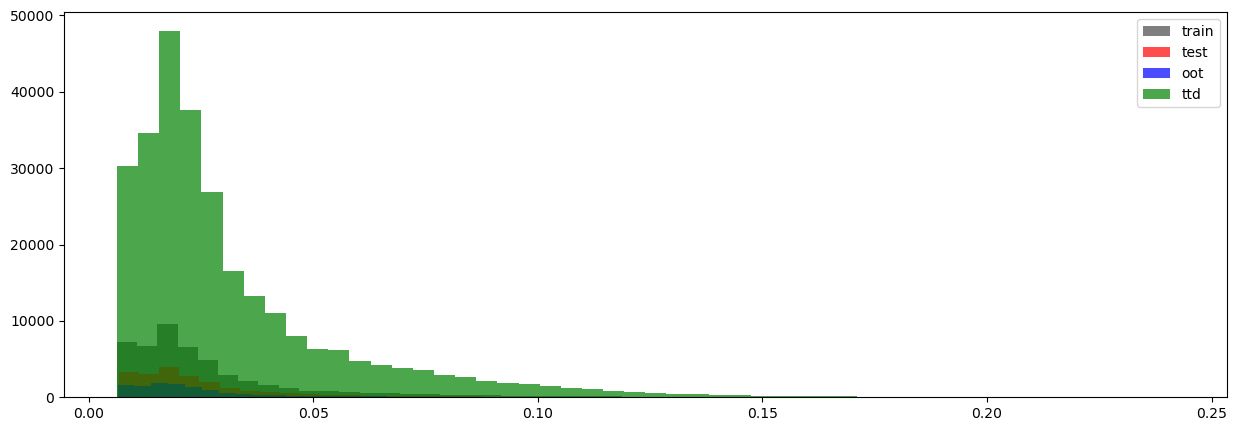

In [168]:
import matplotlib.pyplot as plt
plt.figure(figsize= (15, 5))
plt.hist(Train['p1'], bins= 50, label= 'train', color= 'black', alpha= 0.5)
plt.hist(Test['p1'], bins= 50, label= 'test', color= 'red', alpha= 0.7)
plt.hist(Oot['p1'], bins= 50, label= 'oot', color= 'blue', alpha= 0.7)
plt.hist(TTD['p1'], bins= 50, label= 'ttd', color= 'green', alpha= 0.7)
plt.legend()
plt.show()

In [169]:
Train['p1'].value_counts(dropna= False).head()

p1
0.019754    245
0.018042    242
0.007348    218
0.015849    213
0.016531    199
Name: count, dtype: int64

In [170]:
df_bv= pd.DataFrame()

for col in col_list:
    print(col)
    ### Train
    temp_tr= Train.groupby(col).agg(
        bad_count_tr= ('bad_flag', 'sum'),
        bad_rate_tr= ('bad_flag', 'mean'),
                                p1_bad_rate_tr= ('p1', 'mean'),
                                   volume_tr= ('unique_id', 'count')).reset_index()
    temp_tr.columns= ['Bucket', 'Train_BadCount', 'Train_BadRate', 'Train_P1', 'Train_Count']
    temp_tr.insert(0, 'variable', col)
    
    # temp_tr= temp_tr.sort_values(by= ['bad_rate_tr']).reset_index(drop= True)
    # temp_tr['bad_rate_rank_tr']= range(1, len(temp_tr)+1)
    # temp_tr= temp_tr.sort_values(by= ['p1_bad_rate_tr']).reset_index(drop= True)
    # temp_tr['p1_bad_rank_tr']= range(1, len(temp_tr)+1)
    
    ### Test
    temp_te= Test.groupby(col).agg(
        bad_count_te= ('bad_flag', 'sum'),
        bad_rate_te= ('bad_flag', 'mean'),
                                p1_bad_rate_te= ('p1', 'mean'),
                                  volume_te= ('unique_id', 'count')).reset_index()
    temp_te.columns= ['Bucket', 'Test_BadCount', 'Test_BadRate', 'Test_P1', 'Test_Count']
    #temp_te['variable']= col
    
    # temp_te= temp_te.sort_values(by= ['bad_rate_te']).reset_index(drop= True)
    # temp_te['bad_rate_rank_te']= range(1, len(temp_te)+1)
    # temp_te= temp_te.sort_values(by= ['p1_bad_rate_te']).reset_index(drop= True)
    # temp_te['p1_bad_rank_te']= range(1, len(temp_te)+1)
    
    ### Concatenating
    temp= temp_tr.merge(temp_te, on= ['Bucket'], how= 'left')
    # temp= temp.sort_values(by= ['bucket']).reset_index(drop= True)
    temp= Bucket_Order(temp)
    # display(temp)
    
    df_bv= pd.concat([df_bv, temp]).reset_index(drop= True)
    
    del temp, temp_tr, temp_te

inquiryauto12month
inquirynonshortterm12month
inquirytelcom12month
inquiryshortterm12month
sourcenonderogcount
addrinputtimenewest
sourcecredheadertimeoldest
educationattendance
addrlastmovetaxratiodiff
addrinputlengthofres
educationprogramattended
businessassociation
sourcenonderogcount12month
addrchangecount24month
inquirycollections12month
addrcurrenttractratio
addrinputdeedmailing
addrinputavmratio12monthprior
assetpropnewestsaleprice
inquirybanking12month
addrinputtimeoldest
educationinstitutionprivate
addrcurrenttimenewest
assetpropsalepurchaseratio
assetownership
addrcurrentdeedmailing
addrinputproblems
addrchangecount60month
addrcurrenttimelastsale
addrcurrentphoneservice
addronfilecollege
addrchangecount06month
assetpropsoldcount12month
assetpropevercount
addrchangecount03month
profliccount
subjectnewestrecord12month
subjectrecordtimenewest
shorttermloanrequest24month
sourcecredheadertimenewest


In [171]:
df_bv

,variable,Bucket,Train_BadCount,Train_BadRate,Train_P1,Train_Count,Test_BadCount,Test_BadRate,Test_P1,Test_Count,Is_Trend
0,inquiryauto12month,[0],843.0,0.020193,0.021028,41748,370.0,0.020746,0.020939,17835,Yes
1,inquiryauto12month,[1],456.0,0.063325,0.064119,7201,192.0,0.061069,0.062642,3144,Yes
2,inquirynonshortterm12month,[0],615.0,0.017901,0.018682,34355,298.0,0.020309,0.018673,14673,Yes
3,inquirynonshortterm12month,[1],684.0,0.046869,0.047815,14594,264.0,0.041865,0.047002,6306,Yes
4,inquirytelcom12month,[0],1186.0,0.024799,0.026736,47825,527.0,0.025737,0.026574,20476,Yes
5,inquirytelcom12month,[1],113.0,0.100534,0.054236,1124,35.0,0.069583,0.052219,503,Yes
6,inquiryshortterm12month,[0],1180.0,0.024831,0.026693,47522,508.0,0.024994,0.026495,20325,Yes
7,inquiryshortterm12month,[1],119.0,0.083392,0.049853,1427,54.0,0.082569,0.048754,654,Yes
8,sourcenonderogcount,"[-inf, 2.0)",521.0,0.035842,0.036530,14536,225.0,0.036273,0.036178,6203,Yes
9,sourcenonderogcount,"[2.0, 3.0)",564.0,0.030398,0.030718,18554,235.0,0.030186,0.030777,7785,Yes


In [172]:
for client in Train['client'].unique():
    print(client)
    get_risk_rank(model= xgbm_ln_auto_v2_hpt_best_1, 
                  data= Train[Train['client']== client], 
                  data_h2o= train_h2o[train_h2o['client']== client], 
                  target= 'bad_flag', 
                  cols_tuple= col_tuple_pass, 
                  score_col= 'p1', 
                  weight= 'conwt')
    

Guardian
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
7396 181.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.048700,0.219133,0.076299,1480,1395.0,85.0,5.74,20.01,19.33,46.96,27.63
1,0.028457,0.048699,0.036862,1479,1436.0,43.0,2.91,40.01,39.24,70.72,31.48
2,0.020533,0.028454,0.024206,1479,1459.0,20.0,1.35,60.01,59.46,81.77,22.31
3,0.015547,0.020533,0.017877,1479,1461.0,18.0,1.22,80.00,79.71,91.71,12.00
4,0.006678,0.015547,0.011555,1479,1464.0,15.0,1.01,100.00,100.00,100.00,0.00


{'Gini': 37.37, 'KS': 31.48}
GESA
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
8371 246.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.039218,0.195129,0.066652,1675,1563.0,112.0,6.69,20.01,19.24,45.53,26.29
1,0.026543,0.039187,0.031840,1674,1624.0,50.0,2.99,40.01,39.22,65.85,26.63
2,0.021013,0.026530,0.023743,1674,1637.0,37.0,2.21,60.00,59.37,80.89,21.52
3,0.016343,0.021008,0.018626,1674,1645.0,29.0,1.73,80.00,79.62,92.68,13.06
4,0.006866,0.016343,0.012618,1674,1656.0,18.0,1.08,100.00,100.00,100.00,0.00


{'Gini': 35.0, 'KS': 26.63}
Tower
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
9059 327.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.032710,0.174607,0.055115,1812,1665.0,147.0,8.11,20.00,19.07,44.95,25.88
1,0.022007,0.032690,0.026364,1812,1749.0,63.0,3.48,40.00,39.10,64.22,25.12
2,0.017179,0.022007,0.019342,1812,1757.0,55.0,3.04,60.01,59.22,81.04,21.82
3,0.013069,0.017165,0.015231,1812,1779.0,33.0,1.82,80.01,79.59,91.13,11.54
4,0.006361,0.013069,0.009894,1811,1782.0,29.0,1.60,100.00,100.00,100.00,0.00


{'Gini': 33.75, 'KS': 25.88}
SECU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
4874 218.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.047899,0.231375,0.078599,975,870.0,105.0,10.77,20.00,18.69,48.17,29.48
1,0.028733,0.047876,0.036541,975,930.0,45.0,4.62,40.01,38.66,68.81,30.15
2,0.020626,0.028712,0.024265,975,940.0,35.0,3.59,60.01,58.85,84.86,26.01
3,0.015785,0.020621,0.017987,975,953.0,22.0,2.26,80.02,79.32,94.95,15.63
4,0.006765,0.015778,0.011899,974,963.0,11.0,1.13,100.00,100.00,100.00,0.00


{'Gini': 40.510000000000005, 'KS': 30.15}
Numerica
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
5982 125.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.032281,0.196754,0.053812,1197,1137.0,60.0,5.01,20.01,19.41,48.0,28.59
1,0.023737,0.032281,0.027190,1196,1174.0,22.0,1.84,40.00,39.46,65.6,26.14
2,0.018779,0.023736,0.021185,1197,1182.0,15.0,1.25,60.01,59.64,77.6,17.96
3,0.014893,0.018779,0.016873,1196,1181.0,15.0,1.25,80.01,79.80,89.6,9.80
4,0.006361,0.014890,0.011250,1196,1183.0,13.0,1.09,100.00,100.00,100.0,0.00


{'Gini': 33.0, 'KS': 28.59}
Bethpage
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
3021 29.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.024830,0.160185,0.043409,605,592.0,13.0,2.15,20.03,19.79,44.83,25.04
1,0.017038,0.024830,0.020276,604,596.0,8.0,1.32,40.02,39.71,72.41,32.70
2,0.012644,0.017017,0.014811,604,602.0,2.0,0.33,60.01,59.83,79.31,19.48
3,0.009133,0.012644,0.010620,604,602.0,2.0,0.33,80.01,79.95,86.21,6.26
4,0.006973,0.009133,0.008134,604,600.0,4.0,0.66,100.00,100.00,100.00,0.00


{'Gini': 33.39, 'KS': 32.7}
Hawaii
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
845 3.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.036837,0.142326,0.059068,170,169.0,1.0,0.59,20.12,20.07,33.33,13.26
1,0.026150,0.036739,0.030212,168,166.0,2.0,1.19,40.00,39.79,100.00,60.21
2,0.021195,0.026149,0.023835,170,170.0,0.0,0.00,60.12,59.98,100.00,40.02
3,0.016814,0.021163,0.018949,169,169.0,0.0,0.00,80.12,80.05,100.00,19.95
4,0.006973,0.016787,0.013634,168,168.0,0.0,0.00,100.00,100.00,100.00,0.00


{'Gini': 53.400000000000006, 'KS': 60.21}
CPM
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
1913 56.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.030282,0.152407,0.051932,383,364.0,19.0,4.96,20.02,19.60,33.93,14.33
1,0.019955,0.030207,0.024614,383,364.0,19.0,4.96,40.04,39.20,67.86,28.66
2,0.014673,0.019955,0.017234,382,372.0,10.0,2.62,60.01,59.24,85.71,26.47
3,0.009669,0.014673,0.012137,383,379.0,4.0,1.04,80.03,79.64,92.86,13.22
4,0.006993,0.009668,0.008397,382,378.0,4.0,1.05,100.00,100.00,100.00,0.00


{'Gini': 33.07, 'KS': 28.66}
Arkansas
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
6582 93.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.028262,0.166991,0.049935,1317,1270.0,47.0,3.57,20.01,19.57,50.54,30.97
1,0.016994,0.028262,0.021792,1316,1292.0,24.0,1.82,40.00,39.48,76.34,36.86
2,0.011746,0.016994,0.014088,1317,1305.0,12.0,0.91,60.01,59.59,89.25,29.66
3,0.009054,0.011740,0.010322,1316,1313.0,3.0,0.23,80.01,79.83,92.47,12.64
4,0.006297,0.009054,0.007991,1316,1309.0,7.0,0.53,100.00,100.00,100.00,0.00


{'Gini': 44.05, 'KS': 36.86}
HFCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
688 16.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.029785,0.182807,0.051838,138,132.0,6.0,4.35,20.06,19.64,37.5,17.86
1,0.021166,0.029701,0.024812,138,136.0,2.0,1.45,40.12,39.88,50.0,10.12
2,0.015800,0.021143,0.018255,137,133.0,4.0,2.92,60.03,59.67,75.0,15.33
3,0.010581,0.015800,0.013146,138,134.0,4.0,2.90,80.09,79.61,100.0,20.39
4,0.007236,0.010581,0.008895,137,137.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 25.490000000000002, 'KS': 20.39}
NCU
xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%
218 5.0 1


,min_score,max_score,mean_score,total,Goods,Bads,Bad_Rate,Cum_Total,Cum_Good,Cum_Bad,KS
0,0.040160,0.166991,0.070306,44,42.0,2.0,4.55,20.18,19.72,40.0,20.28
1,0.023601,0.040086,0.029985,44,42.0,2.0,4.55,40.37,39.44,80.0,40.56
2,0.016343,0.023278,0.019607,43,43.0,0.0,0.00,60.09,59.62,80.0,20.38
3,0.011947,0.016278,0.014001,44,43.0,1.0,2.27,80.28,79.81,100.0,20.19
4,0.007276,0.011896,0.009352,43,43.0,0.0,0.00,100.00,100.00,100.0,0.00


{'Gini': 40.56, 'KS': 40.56}


### Basic Checks

In [173]:
TTD['funded_flag'].sum(), Train['funded_flag'].sum(), Test['funded_flag'].sum()

(67128.0, 48949.0, 20979.0)

In [174]:
TTD['id']= TTD['unique_id']+TTD['client']
Train['id']= Train['unique_id']+Train['client']
Test['id']= Test['unique_id']+Test['client']
Oot['id']= Oot['unique_id']+Oot['client']

In [175]:
TTD[TTD['id'].isin(Train[Train['client']!= 'CPM']['id'].unique())]['p1'].describe(), Train[Train['client']!= 'CPM']['p1'].describe()

(count    47036.000000
 mean         0.027550
 std          0.021993
 min          0.006297
 25%          0.014447
 50%          0.020621
 75%          0.031844
 max          0.231375
 Name: p1, dtype: float64,
 count    47036.000000
 mean         0.027550
 std          0.021993
 min          0.006297
 25%          0.014447
 50%          0.020621
 75%          0.031844
 max          0.231375
 Name: p1, dtype: float64)

In [176]:
import datetime

In [177]:
# Train[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Train_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Test[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Test_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# Oot[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_Oot_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)
# TTD[col_tuple_pass + ['p1']].to_csv(f'{path_to_save}{pref}_TTD_Auto_LN_V2_Scored_Data_{str(datetime.datetime.today().date())}.csv', index= False)

In [178]:
Train['fico_pb'].describe()

count    48804.000000
mean       669.404291
std        174.142054
min          0.000000
25%        653.000000
50%        703.000000
75%        754.000000
max        900.000000
Name: fico_pb, dtype: float64

In [179]:
TTD['fico_cut']= np.where(((TTD['fico_pb'].isnull()) |(TTD['fico_pb']<300)),"h.Missing",
                        np.where((TTD['fico_pb']>=300) &(TTD['fico_pb']<550),"a.300-550",
                                 np.where((TTD['fico_pb']>=550) &(TTD['fico_pb']<600),"a.550-600",
                                np.where((TTD['fico_pb']>=600) &(TTD['fico_pb']<630),"b.600-629",
                                    np.where((TTD['fico_pb']>=630) &(TTD['fico_pb']<660),"c.630-659",
                                        np.where((TTD['fico_pb']>=660) &(TTD['fico_pb']<690),"d.660-689",
                                            np.where((TTD['fico_pb']>=690) &(TTD['fico_pb']<715),"e.690-714",
                                                np.where((TTD['fico_pb']>=715) & (TTD['fico_pb']<740),"f.715-739",
                                                    np.where((TTD['fico_pb']>=740),"g.740+","h.Missing")))))))))

In [180]:
TTD.groupby('fico_cut').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approve_flag', 'sum'),
    funded= ('funded_flag', 'sum'),
    bad= ('bad_flag', 'sum'),
    avg_pd= ('p1', 'mean')
)

,ttd,approved,funded,bad,avg_pd
fico_cut,,,,,
a.300-550,17859,1522.0,958.0,73.0,0.045548
a.550-600,26018,6914.0,2751.0,214.0,0.040956
b.600-629,27559,11675.0,4001.0,233.0,0.036957
c.630-659,35809,17693.0,6994.0,296.0,0.033663
d.660-689,38632,21546.0,10073.0,285.0,0.030365
e.690-714,29391,18123.0,8894.0,162.0,0.027842
f.715-739,24377,16216.0,8260.0,107.0,0.026367
g.740+,49969,39315.0,21315.0,96.0,0.020805
h.Missing,25568,7254.0,3882.0,315.0,0.042047


In [181]:
TTD.shape

(275182, 148)